In [ ]:
import pandas as pd
from google.colab import drive
import numpy as np
import os, json, gc, re, random
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
%%time

!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
CPU times: user 39.7 ms, sys: 5.29 ms, total: 45 ms
Wall time: 5.24 s


In [ ]:
%%time

!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 97.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 1

In [ ]:
%%time

!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
CPU times: user 53.4 ms, sys: 5.62 ms, total: 59 ms
Wall time: 7.05 s


In [ ]:
%%time

!pip install tokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.6 MB/s eta 0:00:00
CPU times: user 49.2 ms, sys: 4.52 ms, total: 53.7 ms
Wall time: 5.63 s


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
veri=pd.read_excel("/content/gdrive/My Drive/Deneme/temiz.xlsx")

In [ ]:
del veri["Unnamed: 0"]

In [ ]:
veri = veri.dropna()

In [ ]:
veri = veri[["findings", "impression"]]
veri.columns = ['input_text', 'target_text']
veri

input_text  \
0      pa  and  lateral  views  of  the  chest  provi...   
1      as  compared  to  the  prior  examination  dat...   
2      a  triangular  opacity  in  the  right  lung  ...   
3      mild  to  moderate  enlargement  of  the  card...   
4      there  is  mild  pulmonary  edema  with  super...   
...                                                  ...   
36712  a  rightsided  portacath  terminates  at  the ...   
36713  there  is  no  evidence  of  pneumothorax  or ...   
36714  the  lungs  are  clear  without  focal  consol...   
36715  suspect  background  hyperinflation  as  can  ...   
36716  frontal  and  lateral  chest  radiographs  dem...   

                                             target_text  
0                      no  acute  intrathoracic  process  
1      no  evidence  of  acute  cardiopulmonary  process  
2      right  upper  lobe  pneumonia  or  mass  howev...  
3             no  radiographic  evidence  for  pneumonia  
4      mild  pulmonary  edema  with  superimposed  le...  
...                                                  ...  
36712                  no  acute  intrathoracic  process  
36713  no  evidence  of  pneumothorax  or  displaced ...  
36714                no  acute  cardiopulmonary  process  
36715  no  acute  pulmonary  process  identified  no ...  
36716                  hyperexpansion  no  consolidation  

[36707 rows x 2 columns]

In [ ]:
%%time

from simpletransformers.seq2seq import Seq2SeqModel

eval_df = veri.sample(frac=0.1, random_state=42)
train_df = veri.drop(eval_df.index)

model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "max_seq_length": 512,
    "train_batch_size": 8,
    "num_train_epochs": 4,
    "use_multiprocessing": False,
    "truncation": True,
    "tokenizer": True,
}
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer=AutoTokenizer.from_pretrained("algoprog/mimics-query-bart-base")
# Create a Bart-base model
model = Seq2SeqModel(encoder_decoder_type="bart",
                    encoder_decoder_name="algoprog/mimics-query-bart-base",
                    args=model_args)

CPU times: user 10.3 s, sys: 2.32 s, total: 12.7 s
Wall time: 30.4 s


In [ ]:
train_df

input_text  \
0      pa  and  lateral  views  of  the  chest  provi...   
1      as  compared  to  the  prior  examination  dat...   
2      a  triangular  opacity  in  the  right  lung  ...   
3      mild  to  moderate  enlargement  of  the  card...   
5      the  lungs  are  clear  of  consolidation  eff...   
...                                                  ...   
36712  a  rightsided  portacath  terminates  at  the ...   
36713  there  is  no  evidence  of  pneumothorax  or ...   
36714  the  lungs  are  clear  without  focal  consol...   
36715  suspect  background  hyperinflation  as  can  ...   
36716  frontal  and  lateral  chest  radiographs  dem...   

                                             target_text  
0                      no  acute  intrathoracic  process  
1      no  evidence  of  acute  cardiopulmonary  process  
2      right  upper  lobe  pneumonia  or  mass  howev...  
3             no  radiographic  evidence  for  pneumonia  
5                    no  acute  cardiopulmonary  process  
...                                                  ...  
36712                  no  acute  intrathoracic  process  
36713  no  evidence  of  pneumothorax  or  displaced ...  
36714                no  acute  cardiopulmonary  process  
36715  no  acute  pulmonary  process  identified  no ...  
36716                  hyperexpansion  no  consolidation  

[33036 rows x 2 columns]

In [ ]:
%%time

# Train the model
model.train_model(train_df)

# Evaluate the model
result = model.eval_model(eval_df)
print(result)

  0%|          | 0/33036 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/4130 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/4130 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/4130 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/4130 [00:00<?, ?it/s]

  0%|          | 0/3671 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/459 [00:00<?, ?it/s]

{'eval_loss': 0.05106094631129036}
CPU times: user 2h 26min 11s, sys: 49.7 s, total: 2h 27min 1s
Wall time: 2h 30min 17s


In [ ]:
cols = ['True Impression', 'Predicted Impression']
lst = []

In [ ]:
test_df = eval_df.sample(n=400)
outputdata = pd.DataFrame()
for idx, row in test_df.iterrows():

    plot = row['input_text']
    true_title = row['target_text']
    predicted_title = model.predict([plot])[0]
    lst.append([true_title,predicted_title])

    print(f'True Impression: {true_title}\n')
    print(f'Predicted Impression: {predicted_title}\n')
    print(f'Findings: {plot}\n\n\n')

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: previously  seen  regions  of  consolidation  have  essentially  resolved  no  evidence  of  acute  cardiopulmonary  process

Predicted Impression: no  definite  acute  cardiopulmonary  process

Findings: single  frontal  view  of  the  chest  when  compared  to  prior  there  has  been  interval  resolution  of  the  opacities  seen  on  the  prior  chest  xray  vague  opacity  persists  at  the  left  lung  base  projecting  over  the  anterior  left  sixth  rib  thought  to  be  costochondral  calcification  and  is  unchanged  when  dating  back  to  the  cardiomediastinal  silhouette  is  within  normal  limits  no  acute  osseous  abnormalities





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  mild  pulmonary  edema  has  completely  resolved  2  left  moderate  pleural  effusion  and  right  small  pleural  effusion  are  stable

Predicted Impression: 1  mild  pulmonary  edema  has  completely  resolved   

Findings: mild  pulmonary  edema  has  completely  resolved  left  moderate  pleural  effusion  with  compressive  atelectasis  is  unchanged  right  pleural  effusion  is  minimal  moderate  cardiomegaly  is  stable  there  is  no  pneumothorax  rightsided  picc  line  ends  at  the  cavoatrial  junction





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  clear  the  cardiomediastinal  silhouette  is  normal  no  acute  osseous  abnormalities  identified  no  free  air  seen  below  the  diaphragm





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: frontal  and  lateral  views  of  the  chest  were  obtained  lungs  are  clear  without  focal  consolidation  no  pleural  effusion  or  pneumothorax  is  seen  the  cardiac  and  mediastinal  silhouettes  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  evidence  of  pneumonia  no  hyperinflation  or  atelectasis

Predicted Impression: normal  chest  radiograph

Findings: normal  heart  lungs  hila  mediastinum  and  pleural  surfaces





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: duallead  pacemaker  in  standard  position  with  leads  ending  in  the  right  atrium  and  right  ventricle  mild  cardiomegaly

Predicted Impression: mild  cardiomegaly  with  no  acute  cardiop

Findings: pa  and  lateral  views  of  the  chest  are  obtained  a  pulse  generator  seen  overlying  the  left  chest  with  two  leads  in  standard  position  one  terminating  in  the  right  atrium  and  the  other  terminating  in  the  right  ventricle  mild  cardiomegaly  is  noted  there  is  no  pneumothorax  pleural  effusion  or  pulmonary  edema





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: resolution  of  fluid  overload

Predicted Impression: no  evidence  of  acute  cardiopulmonary  process

Findings: previously  reported  mild  fluid  overload  has  apparently  resolved  lungs  demonstrate  baseline  abnormalities  related  to  emphysema  and  chronic  scarring  both  most  pronounced  in  the  upper  lobes  and  similar  in  appearance  to  a  baseline  chest  radiograph  of  cardiomediastinal  contours  are  also  stable  since  that  time  there  are  no  pleural  effusions  bones  are  diffusely  demineralized  right  internal  jugular  central  venous  catheter  remains  unchanged  in  position





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: there  is  no  focal  consolidation  pleural  effusion  or  pneumothorax  the  cardiomediastinal  and  hilar  contours  are  normal





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: lower  lower  lobe  pneumonia

Predicted Impression: subtle  retrocardiac  opacity  which  could  represent  atelect

Findings: compared  with  prior  radiographs  on  there  is  a  subtle  retrocardiac  opacity  there  is  bronchiectasis  of  the  right  lower  lobe  no  pleural  effusion  or  pneumothorax  is  seen  the  cardiac  and  mediastinal  silhouettes  are  unremarkable  a  rightsided  portacath  terminates  at  the  cavoatrial  junction





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  several  small  pulmonary  nodules  for  which  3  months  followup  radiographs  are  recommended  2  hyperinflated  lungs

Predicted Impression: 1  hyperinflated  lungs  with  several  small  pulmonary 

Findings: the  lungs  are  hyperinflated  and  several  small  pulmonary  nodules  are  seen  in  the  right  lung  for  which  3  month  followup  radiographs  are  recommended  there  is  a  small  welldemarcated  focal  opacity  in  the  left  lung  base  which  likely  represents  rounded  atelectasis  surgical  clips  are  noted  the  upper  abdomen  and  mediastinum  there  is  no  focal  consolidation  pleural  effusion  pneumothorax  or  pulmonary  edema  the  cardiomediastinal  silhouette  is  within  normal  limits





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  radiographic  evidence  for  acute  cardiopulmonary  process    findings  were  conveyed  by  dr  to  dr   telephone  at  312pm  on   min  after  discovery

Predicted Impression: no  acute  cardiopulmonary  process

Findings: as  compared  to  the  prior  examination  there  has  been  minimal  interval  change  redemonstrated  is  a  rightsided  picc  line  seen  terminating  in  the  mid  svc  the  lungs  are  essentially  clear  without  focal  consolidation  pleural  effusion  pneumothorax  or  pulmonary  edema  the  heart  size  is  top  normal  mediastinal  and  hilar  contours  are  stable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: minimal  patchy  bibasilar  opacities  likely  atelectasis  no  focal  consolidation  noted

Predicted Impression: minimal  bibasilar  atelectasis

Findings: the  cardiac  mediastinal  and  hilar  contours  are  normal  pulmonary  vasculature  is  normal  no  focal  consolidation  pleural  effusion  or  pneumothorax  is  present  minimal  patchy  bibasilar  opacities  likely  reflect  areas  of  atelectasis  no  acute  osseous  abnormalities  are  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: pa  and  lateral  chest  radiographs  demonstrate  no  focal  consolidation  pleural  effusion  or  pneumothorax  the  cardiomediastinal  silhouette  is  normal





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  evidence  of  acute  disease

Predicted Impression: no  evidence  of  acute  disease

Findings: the  cardiac  mediastinal  and  hilar  contours  appear  unchanged  including  mild  cardiomegaly  leftward  rotation  of  the  cardiac  and  mediastinal  structures  appears  similar  the  lungs  appear  clear  there  are  no  pleural  effusions  or  pneumothorax  mild  degenerative  changes  are  similar  along  the  thoracic  spine





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: evidence  of  copd  no  active  disease

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  somewhat  hyperexpanded  bronchovascular  markings  are  prominent  there  is  no  focal  consolidation  streaky  density  at  the  right  base  likely  represents  scarring  there  is  biapical  pleural  thickening  slightly  more  pronounced  on  the  right  the  heart  is  normal  in  size  the  aorta  is  calcified  mediastinal  structures  are  otherwise  unremarkable  the  bony  thorax  is  grossly  intact





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: hyperinflated  lungs  without  radiographic  evidence  for  pneumonia

Predicted Impression: no  radiographic  evidence  for  acute  cardiopulmonary  process

Findings: the  lungs  are  hyperinflated  no  focal  consolidation  pleural  effusion  pneumothorax  or  pulmonary  edema  is  seen  heart  and  mediastinal  contours  are  within  normal  limits  with  aortic  knob  calcification  and  aortic  tortuosity  old  left  rib  fractures  are  noted





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: ng  tube  in  satisfactory  position  clear  lungs

Predicted Impression: appropriate  placement  of  the  nasogastric  tube  within 

Findings: the  tip  of  a  right  ij  central  venous  catheter  projects  over  the  mid  svc  the  last  radiograph  obtained  demonstrates  appropriate  placement  of  the  nasogastric  tube  within  the  stomach  there  is  no  pneumothorax  the  lungs  are  clear  the  heart  and  mediastinum  are  within  normal  limits  despite  the  projection  regional  bones  and  soft  tissues  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: endotracheal  tube  terminates  at  the  level  of  the  carina  and  should  be  withdrawn  3  cm  bibasilar  opacifications  atelectasis  versus  infection  in  the  appropriate  clinical  setting

Predicted Impression: endotracheal  tube  terminating  at  the  level  of

Findings: single  portable  chest  radiograph  demonstrates  placement  of  endotracheal  tube  terminating  at  the  level  of  the  carina  and  should  be  withdrawn  at  least  3  cm  to  terminate  at  the  level  of  the  clavicle  cardiomediastinal  and  hilar  contours  are  unremarkable  bibasilar  opacifications  left  greater  than  right  may  represent  atelectasis  though  infection  is  not  excluded  no  pleural  effusion  or  pneumothorax  present





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  process

Predicted Impression: small  bilateral  pleural  effusions  and  copd  no 

Findings: normal  heart  size  mediastinal  and  hilar  contours  there  are  small  bilateral  pleural  effusions  no  focal  consolidations  or  pneumothorax  the  lungs  are  hyperinflated  and  may  reflect  some  degree  of  copd  bilateral  symmetric  nodular  opacities  overlying  the  lower  chest  likely  correspond  to  nipple  shadows  unchanged  from  prior





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: stable  cardiomegaly  no  definite  signs  of  edema  or  pneumonia

Predicted Impression: no  acute  intrathoracic  process

Findings: ap  portable  upright  view  of  the  chest  there  is  no  focal  consolidation  effusion  or  pneumothorax  the  heart  size  is  moderately  enlarged  not  significantly  changed  mediastinal  contour  stable  and  within  normal  limits  imaged  osseous  structures  are  intact





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: dobbhoff  tube  likely  within  the  stomach

Predicted Impression: 1  nasogastric  tube  positioned  appropriately  2  no 

Findings: esophageal  catheter  courses  below  the  diaphragm  and  is  coiled  in  the  left  upper  quadrant  likely  within  the  stomach  there  has  been  interval  placement  of  a  gastrostomy  tube  with  three  anchors  projecting  over  the  pigtail  and  tip  projecting  over  the  left  upper  quadrant  umbilical  jewelry  is  noted  the  lung  fields  are  clear  without  focal  consolidation  pleural  effusion  pneumothorax  or  pulmonary  edema  heart  and  mediastinal  contours  are  within  normal  limits





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  pulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  cardiomediastinal  and  hilar  contours  are  within  normal  limits  no  chf  focal  infiltrate  or  consolidation  pleural  effusion  or  pneumothorax  detected





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: background  changes  of  atelectasis  and  pulmonary  vascular  congestion    increased  opacity  at  the  right  lung  base  suspicious  for  superimposed  infection

Predicted Impression: 1  increased  opacity  at  the  right  lung  base  is

Findings: even  allowing  for  the  projection  there  is  mild  cardiomegaly  there  is  persistent  left  lower  lobe  atelectasis  increased  opacity  at  the  right  lung  base  is  more  conspicuous  than  on  the  prior  study  given  the  lack  of  associated  volume  loss  appearances  are  suspicious  for  superimposed  infection  there  is  persistent  prominence  of  the  bilateral  hila  with  mild  pulmonary  vascular  congestion  no  pneumothorax  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: cardiomegaly  and  likely  chronic  changes  in  the  lungs  mid  to  lower  thoracic  vertebral  body  height  loss  is  age  indeterminate

Predicted Impression: cardiomegaly  without  overt  pulmonary  edema

Findings: right  chest  wall  dual  lead  pacing  device  is  seen  with  lead  tips  in  the  right  atrium  and  right  ventricle  streaky  bibasilar  opacities  are  potentially  secondary  to  atelectasis  or  scarring  there  is  no  consolidation  or  effusion  the  cardiac  silhouette  is  moderately  enlarged  atherosclerotic  calcifications  are  noted  at  the  aortic  arch  degenerative  changes  identified  at  the  right  shoulder  mid  to  lower  thoracic  vertebral  body  height  loss  is  age  indeterminate





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: left  lower  lung  opacity  could  either  be  a  focal  area  of  atelectasis  or  even  a  lung  nodule  it  could  not  be  seen  before  the  chest  xray  of    if  warranted  ct  scan  could  be  done  to  assess  this  abnormality      there  is  no  significant  change  since  in  chronic  pulmonary  vessel  cephalization  and  loculated  pleural  effusion  on  the  right          the  results  have  been  posted  to  radiology  dashboard  for  direct  notification  to  referring  physician

Predicted Impression: 1  moderate  loculated  right  pleural  effusion  is 

Findings: pulmonary  vascular  cephalization  is  chronic  moderate  loculated  right  pleural  effusion  going  into  the  fissure  is  stable  22  mm  opacity  projects  at  the  left  lung  base  unchanged  since  but  could  not  be  clearly  seen  before  that  mildtomoderate  cardiomegaly  is  unchanged  the  patient  is  status  post  fusion  with  posterior  screws  at  t6  through  t9  leve

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  intrathoracic  process

Findings: pa  and  lateral  views  of  the  chest  were  obtained  demonstrating  clear  lungs  bilaterally  no  focal  consolidation  effusion  pneumothorax  is  seen  cardiomediastinal  silhouette  is  normal  bony  structures  are  intact  no  free  air  below  the  right  hemidiaphragm  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: large  hiatal  hernia  subtle  opacity  in  the  left  lung  base  may  represent  pneumonia  or  aspiration

Predicted Impression: 1  vague  opacity  at  the  left  lung  base  which

Findings: pa  and  lateral  views  of  the  chest  were  provided  a  large  retrocardiac  opacity  containing  an  airfluid  level  is  compatible  with  a  known  hiatal  hernia  there  is  a  vague  opacity  at  the  left  lung  base  which  could  represent  pneumonia  otherwise  the  lungs  appear  clear  there  may  be  a  tiny  left  pleural  effusion  no  pneumothorax  heart  size  appears  stable  mediastinal  contour  appears  unchanged  the  bony  structures  are  intact





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  appropriate  positioning  of  endotracheal  nasogastric  and  left  subclavian  central  venous  catheter    2  in  the  setting  of  low  lung  volumes  bibasilar  opacities  may  reflect  atelectasis  however  superimposed  consolidation  especially  at  the  right  base  can not  be  excluded

Predicted Impression: 1  endotracheal  tube  terminates  38  cm  above

Findings: endotracheal  tube  approximately  terminates  38  cm  above  the  carina  ng  tube  is  in  the  stomach  left  subclavian  central  venous  catheter  tip  is  in  the  lower  svc  cardiomediastinal  silhouette  is  unremarkable  lung  volumes  are  low  there  is  pulmonary  vascular  engorgement  basilar  opacities  may  represent  atelectasis  however  superimposed  consolidation  can not  be  excluded  especially  at  the  right  base  no  large  pleural  effusion  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: small  bilateral  pleural  effusions  increased  from  no  pneumonia  or  edema

Predicted Impression: 1  no  pneumonia  2  small  bilateral  pleural  effusions

Findings: frontal  and  lateral  views  of  the  chest  were  obtained  there  is  no  focal  consolidation  or  pneumothorax  small  bilateral  pleural  effusions  have  increased  from  pulmonary  edema  has  resolved  heart  size  is  top  normal  cardiac  pacemaker  leads  are  unchanged  in  position  mediastinal  silhouette  and  hilar  contours  are  normal  aside  from  unchanged  mild  aortic  tortuosity  degenerative  change  in  the  thoracic  spine  is  similar  to  the  prior  study





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: mildtomoderate  bibasilar  atelectasis  with  pleural  effusion  is  unchanged

Predicted Impression: 1  unchanged  bibasilar  atelectasis  with  pleural

Findings: mildtomoderate  bibasilar  atelectasis  with  pleural  effusion  is  unchanged  there  is  no  new  lung  opacity  there  is  no  pneumothorax  mediastinal  and  cardiac  contours  are  normal  ng  tube  is  in  adequate  position  and  bowel  loop  distention  was  better  assessed  in  todays  abdomen  chest  xray





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  clear  of  focal  consolidation  pleural  effusion  or  pneumothorax  the  heart  size  is  normal  the  mediastinal  contours  are  normal





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  intrathoracic  process

Findings: pa  and  lateral  views  of  the  chest  provided  midline  sternotomy  wires  again  noted  as  well  as  mediastinal  clips  a  dialysis  catheter  is  unchanged  with  its  tip  in  the  expected  location  of  the  cavoatrial  junction  the  lungs  appear  clear  there  is  no  focal  consolidation  effusion  or  pneumothorax  previously  noted  effusions  have  resolved  the  cardiomediastinal  silhouette  is  normal  imaged  osseous  structures  are  intact  no  free  air  below  the  right  hemidiaphragm  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: stable  examination

Predicted Impression: no  significant  change  in  the  appearance  of  the

Findings: findings  appears  stable  the  left  chest  tube  is  unchanged  in  position  there  is  no  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  no  appreciable  pneumothorax    2  interval  increase  in  the  diameter  of  the  azygos  vein  raises  concern  for  either  right  heart  failure  or  a  pericardial  effusion      were  dw  nurse  who  agreed  to  share  the  information  with  the  team  by  dr  by  phone  at  1p  on  the  day  of  the  exam

Predicted Impression: no  acute  intrathoracic  abnormalities  identified

Findings: the  heart  size  is  top  normal  there  has  been  interval  removal  of  a  leftsided  subclavian  line  there  has  been  an  interval  increase  in  the  volume  of  the  azygos  vein  tracheostomy  tube  appears  to  be  in  appropriate  position  no  new  focal  consolidations  concerning  for  pneumonia  identified  there  is  no  pleural  effusion  there  is  no  appreciable  pneumothorax  the  visualized  osseous  structures  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: stable  appearance  of  the  chest  on  portable  single  view  examination  with  no  interval  change  since 

Predicted Impression: no  evidence  of  new  pulmonary  infiltrates  in  this 

Findings: ap  single  view  of  the  chest  has  been  obtained  with  patient  in  sitting  semiupright  position  comparison  is  made  with  the  next  preceding  similar  study  of  a  rightsided  subclavian  approach  central  venous  line  is  again  recognized  seen  to  terminate  slightly  higher  than  it  did  before  in  the  lower  svc  there  is  no  pneumothorax  comparison  of  the  two  portable  chest  examinations  do  not  show  any  new  pulmonary  parenchymal  abnormality  the  lateral  pleural  sinuses  remain  free  and  heart  size  and  mediastinal  structures  are  within  normal  limits  comparison  is  extended  to  the  next  previous  pa  and  lateral  chest  examination  of  there  was  no  evidence  of  any  focal  pulmonary  infiltrates  at  that

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormality

Predicted Impression: no  acute  cardiopulmonary  abnormality

Findings: the  lungs  are  normally  expanded  and  clear  the  cardiomediastinal  silhouette  hilar  contours  and  pleural  surfaces  are  normal  there  is  no  pleural  effusion  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  right  lower  lobe  and  right  middle  lobe  opacities  are  concerning  for  infectious  pneumonia  2  interval  worsening  moderate  pulmonary  vascular  congestion  and  mild  pulmonary  edema

Predicted Impression: 1  increased  pulmonary  vascular  congestion  and  mild  interstitial 

Findings: cardiomegaly  pulmonary  vascular  congestion  and  mild  interstitial  pulmonary  edema  have  increased  from  the  prior  study  airspace  opacity  within  the  right  lower  and  right  middle  lobes  is  concerning  for  superimposed  pneumonia  there  is  no  pneumothorax  or  pleural  effusion





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: pa  and  lateral  chest  radiographs  demonstrate  no  focal  consolidation  pleural  effusion  or  pneumothorax  the  cardiomediastinal  silhouette  is  normal  again  seen  is  old  rightsided  rib  deformity  cholecystectomy  clips  are  noted  in  the  right  upper  quadrant





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: cardiomegaly  vascular  plethora  which  is  possibly  very  slightly  improved    opacity  at  left  base  consistent  with  collapse  and  consult  andor  consolidation  probably  with  some  degree  of  pleural  fluid  allowing  for  differences  in  positioning  this  is  overall  similar    new  patchy  opacity  at  the  right  base  could  reflect  atelectasis  but  a  focus  of  aspiration  pneumonitis  or  early  pneumonic  infiltrate  can not  be  excluded    mild  blunting  of  the  right  costophrenic  angle  again  noted  possibly  slightly  larger  consistent  with  a  small  right  pleural  effusion    no  pneumothorax  detected

Predicted Impression: 1  left  lower  lobe  collapse  andor  consolidation  with 

Findings: lordotic  positioning  lungs  are  overinflated  consistent  with  copd  cardiomediastinal  silhouette  is  probably  unchanged  allowing  for  differences  in  positioning  again  seen  is  dense  opacity  in  the  lower  third  of  left

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: as  above

Predicted Impression: no  acute  intrathoracic  process

Findings: pa  and  lateral  views  of  the  chest  provided  faint  areas  of  scarring  again  noted  in  the  periphery  of  the  right  mid  lung  otherwise  the  lungs  are  clear  no  pleural  effusion  or  pneumothorax  cardiomediastinal  silhouette  is  stable  with  an  unfolded  thoracic  aorta  scoliosis  again  noted





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: interval  enlargement  of  the  right  pleural  effusion  and  pulmonary  vascular  congestion  please  note  that  underlying  infection  at  the  right  lung  base  can not  be  excluded

Predicted Impression: interval  enlargement  of  a  rightsided  pleural  eff

Findings: since  prior  there  has  been  interval  enlargement  of  a  rightsided  pleural  effusion  which  is  now  moderate  to  large  with  associated  atelectasis  left  chest  wall  triple  lead  pacing  device  is  again  noted  there  is  no  leftsided  effusion  linear  opacity  in  the  left  lower  lung  is  likely  atelectasis  versus  scarring  there  is  vascular  congestion  lungs  are  otherwise  clear  of  consolidation  previously  seen  pneumothorax  is  no  longer  visualized





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: stable  mild  pulmonary  edema

Predicted Impression: mild  pulmonary  edema  has  not  significantly  changed  since

Findings: mild  pulmonary  edema  has  not  significantly  changed  since  mild  widening  of  the  cardiomediastinal  contours  is  likely  due  to  mediastinal  lipomatosis  no  pleural  effusion  or  pneumothorax  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormalities

Predicted Impression: findings  suggestive  of  mild  pulmonary  vascular  congestion  and 

Findings: the  heart  is  moderately  enlarged  similar  to  prior  there  is  dense  retrocardiac  opacity  that  could  be  due  to  volume  loss  or  infiltrate  there  is  mild  pulmonary  vascular  redistribution  there  are  no  definite  effusions





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process  punctate  hyperdense  metallic  density  in  the  left  upper  abdomen  please  correlate  clinically

Predicted Impression: no  acute  intrathoracic  process

Findings: ap  upright  and  lateral  views  the  chest  provided  lungs  are  clear  and  well  inflated  no  focal  consolidation  large  effusion  or  pneumothorax  cardiomediastinal  silhouette  is  normal  no  acute  osseous  abnormality  a  tiny  metallic  density  projecting  over  the  left  upper  abdomen  which  is  of  unclear  etiology  no  free  air  below  the  right  hemidiaphragm





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  clear  there  is  no  pleural  effusion  or  pneumothorax  the  heart  is  normal  in  size  and  normal  cardiomediastinal  contours





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  large  hiatal  hernia  2  bibasilar  atelectasis  worse  on  the  right  although  right  infrahilar  aspiration  or  concurrent  pneumonia  in  the  setting  of  the  known  large  hiatal  hernia  can not  be  definitely  excluded  without  a  lateral  view  3  no  edema

Predicted Impression: 1  streaky  opacities  at  the  left  lung 

Findings: right  infrahilar  and  lower  lobe  streaky  opacities  with  air  bronchograms  are  most  likely  atelectasis  with  associated  slight  elevation  of  the  right  hemidiaphragm  as  also  noted  on  the  prior  chest  radiograph  and  ct  streaky  opacities  at  the  left  lung  base  are  less  prominent  but  also  likely  represent  atelectasis  also  noted  previously  large  retrocardiac  opacity  with  scattered  focal  areas  of  rounded  lucencies  are  most  consistent  with  the  known  large  hiatal  hernia  containing  loops  of  bowel  and  mesenteric  fat  best  appreciated  on  recent  ct  and  perhaps 

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  well  expanded  and  clear  without  evidence  of  lobar  consolidation  pleural  effusion  pneumothorax  or  pulmonary  edema  the  cardiomediastinal  silhouette  is  within  normal  limits





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  evidence  of  acute  cardiopulmonary  disease

Predicted Impression: no  evidence  of  acute  cardiopulmonary  disease

Findings: the  heart  is  normal  in  size  the  mediastinal  and  hilar  contours  appear  within  normal  limits  there  is  no  pleural  effusion  or  pneumothorax  the  lungs  appear  clear





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  right  internal  jugular  central  venous  catheter  tip  in  the  low  svc  no  pneumothorax  2  low  lung  volumes  with  bibasilar  atelectasis

Predicted Impression: minimal  pulmonary  engorgement  without  frank  pulmonary edema

Findings: right  internal  jugular  central  venous  catheter  tip  terminates  in  the  low  svc  no  pneumothorax  is  present  lung  volumes  are  low  with  patchy  opacities  in  the  lung  bases  most  likely  reflective  of  atelectasis  heart  size  is  top  normal  the  aorta  is  minimally  tortuous  hilar  contours  are  unremarkable  pulmonary  vasculature  demonstrates  minimal  engorgement  without  frank  pulmonary  edema  no  focal  consolidation  or  pleural  effusion  is  demonstrated  there  are  no  acute  osseous  abnormalities





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: right  internal  jugular  central  line  unchanged  in  position  stable  cardiac  and  mediastinal  contours  lungs  remain  well  inflated  without  evidence  of  focal  airspace  consolidation  pleural  effusions  pulmonary  edema  or  pneumothorax

Predicted Impression: right  subclavian  picc  line  unchanged  in  position

Findings: portable  ap  upright  chest  radiograph  at  0502  is  submitted





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: new  opacities  are  seen  at  the  bilateral  bases  left  greater  than  right  and  in  the  setting  of  very  low  lung  volumes  may  represent  atelectasis  pneumonia  or  a  combination

Predicted Impression: new  opacities  at  the  bilateral  bases  left  greater

Findings: portable  semiupright  radiograph  of  the  chest  demonstrates  very  low  lung  volumes  with  resulting  bronchovascular  crowding  new  opacities  are  seen  at  the  bilateral  bases  left  greater  than  right  and  in  the  setting  of  very  low  lung  volumes  may  represent  atelectasis  pneumonia  or  a  combination  heart  size  is  normal  there  is  no  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormality

Predicted Impression: no  acute  cardiopulmonary  abnormality

Findings: cardiac  mediastinal  and  hilar  contours  are  normal  a  vascular  stent  is  seen  in  the  left  brachiocephalic  vein  lungs  are  clear  and  the  pulmonary  vasculature  is  normal  no  pleural  effusion  or  pneumothorax  is  seen  there  is  resorption  of  the  right  distal  clavicle  which  may  be  due  to  prior  surgery  or  trauma





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: the  tip  of  the  right  picc  line  projects  over  the  mid  svc    mild  right  lower  lobe  atelectasis

Predicted Impression: interval  removal  of  the  endotracheal  tube  no

Findings: interval  removal  of  the  endotracheal  tube  the  tip  of  the  right  picc  line  extends  to  the  mid  svc  no  focal  consolidation  pleural  effusion  or  pneumothorax  identified  mild  right  basilar  atelectasis  the  appearance  of  the  cardiac  silhouette  is  unchanged





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  appropriate  positioning  of  all  support  devices    2  no  acute  intrathoracic  abnormality

Predicted Impression: status  post  endotracheal  tube  placement  with  tip 

Findings: a  single  portable  frontal  supine  view  of  the  chest  was  obtained  the  patient  is  status  post  endotracheal  tube  placement  with  tip  approximately  18  cm  above  the  carina  ng  tube  tip  is  below  the  diaphragm  but  not  fully  imaged  the  cardiac  silhouette  is  likely  accentuated  by  low  lung  volumes  and  the  ap  supine  technique  the  lungs  are  clear  without  focal  consolidation  pleural  effusion  or  pneumothorax  linear  left  basilar  opacity  likely  represents  atelectasis  there  is  no  large  effusion  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  pleuropulmonary  disease

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  cardiomediastinal  shadow  is  normal  no  airspace  consolidation  no  pleural  effusions





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  evidence  of  pneumothorax

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  heart  size  mediastinal  and  hilar  contours  are  normal  the  lungs  are  clear  without  pleural  effusion  focal  consolidation  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  change

Predicted Impression: no  change

Findings: compared  to  the  prior  study  there  is  no  significant  interval  change





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  evidence  of  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  well  expanded  and  clear  there  is  mild  cardiomegaly  but  the  cardiomediastinal  and  hilar  contours  are  unremarkable  otherwise  there  is  no  pleural  effusion  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: unchanged  bibasilar  atelectasis  and  small  left  pleural  effusion

Predicted Impression: persistent  left  basilar  atelectasis  with  associated  small

Findings: frontal  and  lateral  chest  radiographs  were  obtained  there  is  persistent  left  basilar  atelectasis  with  an  associated  small  left  pleural  effusion  streaky  atelectasis  in  the  right  lower  lung  base  is  unchanged  no  pneumothorax  or  pulmonary  edema  is  seen  the  cardiomediastinal  contours  are  stable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process  mild  cardiomegaly

Predicted Impression: no  acute  cardiopulmonary  process

Findings: there  is  no  focal  consolidation  pleural  effusion  or  pneumothorax  there  is  mild  cardiomegaly  the  bones  are  intact





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormality

Predicted Impression: no  acute  cardiopulmonary  abnormality

Findings: heart  size  is  normal  the  mediastinal  and  hilar  contours  are  normal  the  pulmonary  vasculature  is  normal  lungs  are  clear  no  pleural  effusion  or  pneumothorax  is  seen  there  are  no  acute  osseous  abnormalities





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: right  lower  lobe  pneumonia

Predicted Impression: right  lower  lobe  consolidation  worrisome  for  pneumonia

Findings: frontal  and  lateral  views  of  the  chest  were  obtained  right  lower  lobe  consolidation  is  worrisome  for  pneumonia  the  left  lung  is  clear  there  is  no  pleural  effusion  or  pneumothorax  the  cardiac  silhouette  is  top  normal  mediastinal  and  hilar  contours  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormality

Predicted Impression: no  acute  cardiopulmonary  abnormality

Findings: rightsided  portacath  tip  terminates  in  the  uppermid  svc  heart  size  is  normal  coronary  artery  and  left  carotid  artery  stents  are  noted  mediastinal  and  hilar  contours  are  within  normal  limits  pulmonary  vasculature  is  normal  lungs  are  clear  no  focal  consolidation  pleural  effusion  or  pneumothorax  is  present  remote  fractures  of  multiple  left  posterior  ribs  are  again  seen  as  well  as  deformities  of  both  mid  clavicles





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: clear  lungs  with  no  evidence  of  pneumonia

Predicted Impression: no  significant  change  since  the  prior  study

Findings: the  rightsided  picc  line  and  right  subclavian  dialysis  catheter  are  unchanged  in  position  the  patient  has  had  prior  median  sternotomy  a  feeding  tube  terminates  in  the  stomach  there  is  no  pneumothorax  moderate  cardiomegaly  is  unchanged  the  lungs  are  clear





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: slightly  decreased  density  of  right  lung  consolidation  no  other  significant  change

Predicted Impression: 1  persistent  large  right  consolidation  secondary  to  pneumonia  and

Findings: an  endotracheal  tube  enteric  catheter  and  left  approach  central  venous  catheter  are  in  unchanged  expected  position  a  large  right  consolidation  secondary  to  probable  pneumonia  and  associated  moderate  effusion  appears  slightly  less  dense  though  continue  to  occupy  almost  the  entire  right  lung  left  basilar  opacity  persists  and  may  continue  to  represent  a  second  focus  of  infection  bilateral  hilar  prominence  may  be  due  to  vascular  congestion  or  reactive  adenopathy  the  mediastinal  contour  appears  similar





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process  no  pneumoperitoneum

Predicted Impression: no  acute  intrathoracic  process

Findings: a  small  left  gastric  air  bubble  is  present  the  heart  size  is  normal  the  hilar  and  mediastinal  contours  are  within  normal  limits  there  is  no  pneumothorax  focal  consolidation  or  pleural  effusion  no  air  is  seen  under  the  right  hemidiaphragm





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: mild  cardiomegaly

Predicted Impression: mild  cardiomegaly  otherwise  unremarkable

Findings: pa  and  lateral  views  of  the  chest  were  provided  lung  volumes  are  low  the  lungs  are  clear  bilaterally  without  focal  consolidation  effusion  or  pneumothorax  the  heart  appears  mildly  enlarged  the  imaged  bony  structures  are  intact  no  free  air  is  seen  below  the  right  hemidiaphragm





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  evidence  of  acute  disease  status  post  endotracheal  intubation  orogastric  tube  terminating  in  the  distal  esophagus  if  gastric  placement  is  desired  advancing  the  tube  by  at  least  10  cm  is  suggested

Predicted Impression: status  post  endotracheal  intubation  no  evidence 

Findings: the  patient  is  intubated  the  endotracheal  tube  terminates  about  55  cm  above  the  carina  an  orogastric  tube  terminates  probably  just  short  of  the  left  hemidiaphragmatic  inlet  a  streaky  left  mid  lung  opacity  suggests  minor  atelectasis  otherwise  the  lungs  appear  clear  within  the  limitations  of  technique  there  is  no  definite  pleural  effusion  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  new  opacity  along  the  right  middle  lobe  as  well  as  a  generalized  opacity  overlying  the  midtolower  left  lung  raises  concern  for  an  infectious  process    2  spiculated  left  hilar  opacity  with  retraction  of  the  adjacent  parenchyma  is  again  concerning  for  a  malignant  process  or  represent  posttreatment  scarring  however  comparison  with  outside  prior  cross  sectional  studies  or  a  new  chest  ct  is  recommended  for  further  evaluation

Predicted Impression: 1  left  hilar  spiculated  opacity  with  retraction 

Findings: again  the  overall  chest  anatomy  is  distorted  by  severe  levoconvex  thoracic  scoliosis  redemonstrated  is  a  left  hilar  spiculated  opacity  with  evidence  of  retraction  of  the  adjacent  parenchyma  and  left  lung  volume  loss  demonstrating  slight  interval  progression  compared  to  the  prior  exam  from  there  is  a  consolidation  along  the  right  middle  lobe  as  well  

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: new  moderate  right  pneumothorax  without  tension  physiology  ng  tube  with  its  port  at  or  near  the  ge  junction  no  clear  radiographic  evidence  for  aspiration  pneumonia

Predicted Impression: 1  moderate  sized  right  pneumothorax  without  mediast

Findings: again  seen  are  right  rib  fractures  of  the  posterior  aspects  of  t4  through  t7  better  appreciated  on  ct  dated  new  however  is  a  moderate  sized  right  pneumothorax  without  mediastinal  shift  small  bilateral  pleural  effusions  are  best  seen  on  the  lateral  which  may  or  may  not  have  associated  atelectasis  cardiomediastinal  silhouette  is  unchanged  colon  distention  is  again  seen  ng  tube  has  its  port  around  the  ge  junction





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormality

Predicted Impression: no  acute  cardiopulmonary  abnormality

Findings: heart  size  is  normal  mediastinal  and  hilar  contours  are  within  normal  limits  lungs  are  clear  pulmonary  vascularity  is  normal  no  pleural  effusion  or  pneumothorax  is  present  no  acute  osseous  abnormalities  are  present





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: chest  tube  in  appropriate  positioning  with  small  right  apical  pneumothorax

Predicted Impression: 1  small  right  apical  pneumothorax  2  no

Findings: a  chest  tube  is  seen  within  the  right  pleural  space  in  appropriate  positioning  low  lung  volumes  there  is  a  small  apical  pneumothorax  heart  size  is  normal  the  mediastinal  and  hilar  contours  are  normal  the  pulmonary  vasculature  is  normal  lungs  are  clear  no  pleural  effusion  is  seen  there  are  no  acute  osseous  abnormalities





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: stable  cardiomegaly  no  signs  of  pneumonia

Predicted Impression: cardiomegaly  otherwise  unremarkable

Findings: pa  and  lateral  views  of  the  chest  provided  aicd  unchanged  with  lead  extending  to  the  region  the  right  ventricle  midline  sternotomy  wires  and  mediastinal  clips  are  again  noted  cardiomediastinal  silhouette  is  stable  with  moderate  cardiomegaly  again  noted  the  lungs  are  clear  there  is  no  focal  consolidation  effusion  or  pneumothorax  imaged  osseous  structures  are  intact  no  free  air  below  the  right  hemidiaphragm  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: dobbhoff  tube  enters  the  stomach  courses  towards  the  right  then  coils  back  to  near  ge  junction

Predicted Impression: dobbhoff  tube  terminates  in  the  stomach  coils 

Findings: dobbhoff  tube  enters  the  stomach  courses  towards  the  right  then  coils  back  to  near  ge  junction  bibasilar  atelectasis  is  unchanged  cardiomediastinal  silhouette  is  normal  size





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormality

Predicted Impression: no  acute  cardiopulmonary  abnormality

Findings: heart  size  is  normal  with  mild  tortuosity  of  the  thoracic  aorta  hilar  contours  are  unremarkable  lungs  are  clear  pleural  surfaces  are  clear  without  effusion  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: moderate  left  pleural  effusion  status  post  thoracentesis  no  pneumothorax

Predicted Impression: moderate  left  pleural  effusion  increased  compared  to  prior

Findings: a  single  upright  portable  radiograph  of  the  chest  was  acquired  a  moderate  left  pleural  effusion  is  increased  in  size  compared  to  prior  radiographs  from  with  comparison  to  the  most  recent  study  from  earlier  today  not  possible  given  the  upright  technique  on  the  current  study  versus  the  decubitus  technique  previously  there  is  no  pneumothorax  the  right  lung  is  clear  the  heart  size  is  difficult  to  accurately  assess  mediastinal  contours  are  normal





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: bilateral  subcentimeter  lower  lobe  nodules  are  stable  since    no  new  opacities  are  identified

Predicted Impression: 1  no  evidence  of  acute  cardiopulmonary  process 

Findings: pa  and  lateral  views  of  the  chest  demonstrate  a  5  mm  nodule  in  the  right  lower  lobe  and  and  a  small  nodule  in  the  left  lower  lobe  which  are  unchanged  since  the  prior  ct  from  no  focal  consolidation  pleural  effusion  pulmonary  edema  or  pneumothorax  is  present  the  cardiomediastinal  silhouette  is  stable  no  new  nodules  or  masses  are  identified





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: subtle  opacities  in  the  lower  lobes  bilaterally  may  represent  early  pneumonia  in  the  correct  clinical  setting

Predicted Impression: subtle  nodular  opacities  in  the  lower  lob

Findings: there  are  subtle  nodular  opacities  in  the  lower  lobes  bilaterally  the  cardiac  contour  is  unremarkable  there  is  tortuosity  of  the  thoracic  aorta  there  is  no  pleural  effusion  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: unchanged  cardiomegaly  without  acute  chest  abnormality

Predicted Impression: moderate  cardiomegaly  without  acute  chest  abnormality

Findings: frontal  and  lateral  chest  radiographs  demonstrate  clear  lungs  without  pleural  effusion  or  pneumothorax  the  cardiac  silhouette  is  moderately  enlarged  note  is  made  of  calcification  of  the  aortic  knob  there  is  a  moderate  scoliosis  of  the  thoracic  spine





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  no  focal  consolidation  worrisome  for  pneumonia    2  no  evidence  of  pulmonary  edema    3  multiple  calcified  pleural  plaques  suggestive  of  prior  asbestos  exposure

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  heart  size  is  normal  with  tortuosity  of  the  thoracic  aorta  with  which  contains  mural  atherosclerotic  calcifications  the  hilar  contours  are  unremarkable  lungs  are  clear  without  focal  consolidation  worrisome  for  pneumonia  the  hilar  contours  are  normal  a  rightsided  pectoral  implanted  single  lead  pacer  is  unchanged  in  position  again  noted  are  multiple  bilateral  calcified  pleural  plaques  there  is  no  pleural  effusion  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: a  left  upper  pleural  opacity  is  again  seen  stable  over  multiple  priors  there  is  no  focal  consolidation  pleural  effusion  pulmonary  edema  or  pneumothorax  the  heart  and  mediastinal  contours  are  normal





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormality

Predicted Impression: no  acute  cardiopulmonary  abnormality

Findings: heart  size  is  normal  the  mediastinal  and  hilar  contours  are  normal  the  pulmonary  vasculature  is  normal  lungs  are  hyperinflated  but  clear  no  pleural  effusion  or  pneumothorax  is  seen  there  are  no  acute  osseous  abnormalities





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  evidence  of  pneumonia

Predicted Impression: no  acute  intrathoracic  process

Findings: differences  in  cardiomediastinal  silhouette  likely  related  to  ap  position  there  is  left  basilar  atelectasis  there  is  no  focal  consolidations  suspicious  for  pneumonia  there  is  no  pleural  effusion  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: patchy  opacity  in  the  right  middle  lobe  suggestive  of  pneumonia  in  the  appropriate  clinical  context

Predicted Impression: patchy  opacity  in  the  right  middle  lung  is 

Findings: the  inspiratory  lung  volumes  are  appropriate  patchy  opacity  in  the  right  middle  is  better  seen  on  the  lateral  view  the  pulmonary  vasculature  is  not  engorged  the  cardiac  silhouette  is  normal  in  size  the  mediastinal  and  hilar  contours  are  within  normal  limits  the  trachea  is  midline  there  is  no  free  air  beneath  the  right  hemidiaphragm  no  acute  osseous  abnormality  is  detected





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: large  right  perihilar  mass  as  on  prior  linear  right  basilar  opacities  most  suggestive  of  atelectasis

Predicted Impression: large  right  perihilar  mass  not  significantly  changed  more

Findings: frontal  and  lateral  views  of  the  chest  large  right  perihilar  mass  is  again  seen  and  not  significantly  changed  more  extensive  streaky  right  basilar  opacities  are  seen  which  may  be  due  to  atelectasis  especially  given  relative  elevation  of  the  right  hemidiaphragm  perhaps  slightly  more  so  than  on  prior  tracheal  stent  is  identified  the  left  lung  is  grossly  clear  the  cardiomediastinal  silhouette  is  unchanged  no  acute  osseous  abnormalities





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  intrathoracic  process

Findings: pa  and  lateral  views  of  the  chest  provided  there  is  no  focal  consolidation  effusion  or  pneumothorax  the  cardiomediastinal  silhouette  is  normal  imaged  osseous  structures  are  intact  no  free  air  below  the  right  hemidiaphragm  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: enteric  tube  curling  in  the  stomach  with  its  tip  near  the  gastroesophageal  junction  recommend  repositioning

Predicted Impression: nasogastric  tube  in  appropriate  position  no  acute 

Findings: a  nasogastric  tube  is  seen  curling  in  the  stomach  with  its  tip  near  the  gastroesophageal  junction  the  lungs  are  clear  without  focal  consolidation  pleural  effusion  or  pneumothorax  the  heart  is  normal  in  size  there  is  no  overt  pulmonary  edema





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: left  lower  lobe  atelectasis

Predicted Impression: low  lung  volumes  with  streaky  retrocardiac  opacity 

Findings: lung  volumes  are  low  with  crowding  of  bronchovascular  markings  streaky  retrocardiac  opacity  is  most  compatible  with  atelectasis  there  are  no  pleural  effusions  or  pneumothorax  biapical  pleural  parenchymal  scarring  is  noted  heart  size  is  top  normal  to  mildly  enlarged  the  aorta  is  tortuous  and  calcified  there  are  severe  degenerative  changes  at  the  right  glenohumeral  joint  with  boneonbone  contact  subchondral  sclerosis  and  cyst  formation  total  left  glenohumeral  prosthesis  is  also  present  partially  imaged





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  pathology

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  cardiomediastinal  and  hilar  contours  are  normal  there  is  elevation  of  the  right  hemidiaphragm  no  consolidation  pleural  effusion  or  pneumothorax  is  seen  linear  atelectasis  is  seen  in  the  left  lung  base





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: lines  and  tubes  as  described    patchy  retrocardiac  density  and  small  left  effusion  are  overall  similar  to  the  prior  study

Predicted Impression: 1  et  tube  in  standard  position  2  patchy 

Findings: an  et  tube  is  present  the  tip  lies  approximately  re  04  cm  above  the  carina  an  ng  tube  is  present  the  tip  and  sideport  extend  beneath  the  diaphragm  overlying  the  upper  stomach  right  ij  central  line  tip  is  again  seen  to  overlie  the  upper  right  atrium  no  pneumothorax  is  detected  inspiratory  volumes  are  slightly  low  there  is  probable  mild  cardiomegaly  accentuated  by  lordotic  positioning  patchy  retrocardiac  opacity  and  blunting  of  the  left  costophrenic  angle  is  again  seen  overall  similar  to  the  prior  study  equivocal  minimal  subsegmental  atelectasis  the  right  lung  base  lungs  are  otherwise  grossly  clear  no  right  effusionno  chf





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: enlarged  cardiac  silhouette  no  focal  consolidation  pleural  effusion  or  overt  pulmonary  edema

Predicted Impression: cardiomegaly  without  overt  pulmonary  edema

Findings: frontal  and  lateral  chest  radiograph  demonstrates  unremarkable  mediastinal  and  hilar  contours  heart  size  is  enlarged  with  left  ventricular  configuration  no  evidence  of  overt  pulmonary  edema  no  focal  consolidation  is  evident  no  pleural  effusion  or  pneumothorax  mild  multifocal  degenerative  changes  noted  along  the  thoracic  spine





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  mild  congestive  heart  failure  increased  from    2  left  lower  lobe  consolidation  concerning  for  pneumonia

Predicted Impression: 1  increased  left  lower  lobe  opacity  concerning  for  pneumonia

Findings: moderate  cardiomegaly  mediastinal  vascular  engorgement  and  mild  pulmonary  edema  are  increased  from  the  increased  left  lower  lobe  opacity  projects  over  the  spine  concerning  for  pneumonia  less  likely  combination  of  atelectasis  and  trace  pleural  effusion





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  evidence  of  decompensated  chf

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  clear  there  is  severe  cardiomegaly  and  a  rightsided  aortic  arch  which  are  unchanged  from  prior  studies  an  aicd  and  its  leads  are  unchanged  there  is  no  pneumothorax  there  is  no  pleural  effusion  pulmonary  vascularity  is  mildly  prominent  without  frank  pulmonary  edema





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  evidence  of  acute  disease  hyperinflation

Predicted Impression: no  evidence  of  acute  disease

Findings: the  heart  is  normal  in  size  the  mediastinal  and  hilar  contours  appear  unchanged  there  is  no  pleural  effusion  or  pneumothorax  the  lungs  appear  hyperinflated  the  lungs  are  clear  bony  structures  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  no  acute  cardiopulmonary  process  2  no  displaced  rib  fractures

Predicted Impression: no  acute  cardiopulmonary  process

Findings: no  displaced  rib  fractures  are  detected  the  lungs  are  symmetrically  well  expanded  without  focal  consolidation  pleural  effusion  or  pneumothorax  the  pulmonary  vasculature  is  not  engorged  the  cardiac  silhouette  mediastinal  and  hilar  contours  are  within  normal  limits  the  trachea  is  midline  there  is  no  free  air  beneath  the  right  hemidiaphragm





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: vague  opacities  projecting  over  the  right  lung  potentially  atelectasis  infection  or  other  etiology  clinical  correlation  is  suggested  no  other  visualized  acute  process

Predicted Impression: vague  opacities  projecting  over  the  right  lung 

Findings: vague  opacities  project  over  the  right  lung  nonspecific  potentially  atelectasis  noting  underlying  infection  or  other  acute  process  is  possible  the  left  lung  is  grossly  clear  with  the  limitation  of  overlying  external  devices  cardiomediastinal  silhouette  is  within  normal  limits  no  acute  osseous  abnormality  is  identified





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  evidence  of  injury

Predicted Impression: no  evidence  of  acute  cardiopulmonary  disease

Findings: the  cardiac  mediastinal  and  hilar  contours  appear  stable  for  aside  from  some  increase  in  the  size  of  the  heart  which  is  probably  borderline  in  size  allowing  for  pectus  excavatum  there  is  no  pleural  effusion  or  pneumothorax  the  bones  are  probably  demineralized  no  fracture  is  identified





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: left  subclavian  approach  portacath  with  tip  in  the  lower  svc    no  pneumothorax

Predicted Impression: left  subclavian  approach  port  with  tip  in 

Findings: a  left  subclavian  approach  port  has  been  placed  with  tip  demonstrated  within  the  lower  svc  there  is  no  evidence  of  pneumothorax  the  lungs  are  essentially  clear  with  minimal  atelectasis  in  the  retrocardiac  region  there  are  no  pleural  effusions  the  cardiomediastinal  and  hilar  contours  demonstrate  mild  cardiomegaly  and  tortuosity  of  the  thoracic  aorta





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  interval  improvement  in  previously  noted  mild  pulmonary  edema  since    2  persistent  small  right  apical  pneumothorax  3  unchanged  bilateral  small  pleural  effusions  and  bibasilar  atelectasis  since    4  an  airfluid  level  projects  over  the  right  mainstem  bronchus  likely  representing  the  neo  esophagus

Predicted Impression: 1  interval  improvement  in  pulmonary  edema  with  persistent 

Findings: the  patient  is  status  post  minimally  invasive  esophagectomy  interval  improvement  in  bilateral  predominantly  perihilar  interstitial  opacities  likely  improving  pulmonary  edema  there  is  persistence  of  a  small  right  apical  pneumothorax  stable  since  prior  exam  bilateral  small  pleural  effusions  and  bibasilar  atelectasis  are  similar  to  prior  study  the  heart  size  is  unchanged  a  right  pleural  catheter  is  in  standard  placement  an  airfluid  level  projects  over  the  right  mainstem  bronchus

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  no  radiographic  evidence  of  pneumonia    2  hyperexpanded  lungs  suggestive  of  copd

Predicted Impression: no  acute  cardiopulmonary  process

Findings: lungs  are  hyperinflated  but  grossly  clear  cardiomediastinal  contours  are  within  normal  limits  and  without  change  there  is  no  pleural  effusion  or  pneumothorax  extreme  lateral  right  hemi  thorax  is  not  included  on  the  radiograph  precluding  assessment  of  the  ribs  and  peripheral  pleural  surfaces  in  this  region





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: right  internal  jugular  central  venous  catheter  tip  ends  in  the  low  svc  no  evidence  of  pneumothorax

Predicted Impression: new  central  venous  catheter  tip  projects  over  the

Findings: new  central  venous  catheter  tip  projects  over  the  low  svc  there  is  no  evidence  of  pneumothorax  the  cardiomediastinal  silhouette  is  normal  there  is  no  pleural  effusion





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: left  greater  than  right  pleural  effusions

Predicted Impression: bilateral  effusions  moderate  on  the  right  and  small

Findings: ap  and  lateral  views  of  the  chest  lower  lung  volumes  seen  on  the  current  exam  there  are  bilateral  effusions  moderate  on  the  right  and  smalltomoderate  on  the  left  superiorly  the  lungs  are  clear  cardiomediastinal  silhouette  is  accentuated  by  low  lung  volumes  atherosclerotic  calcifications  seen  at  the  arch  multiple  rightsided  rib  fractures  laterally  appear  old  there  is  no  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  cardiomediastinal  and  hilar  contours  are  within  normal  limits  the  lungs  are  clear  without  focal  consolidation  pleural  effusion  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: correct  positioning  of  ng  tube  the  exam  is  otherwise  unchanged

Predicted Impression: 1  ng  tube  in  distal  gastric  cavity  and

Findings: ap  single  view  of  the  chest  shows  diffuse  multiple  bilateral  rounded  pulmonary  nodules  overall  unchanged  since  chest  xray  on  likely  malignant  heart  size  is  normal  mild  vascular  congestion  is  unchanged  left  subclavian  portacath  is  unchanged  with  tip  ending  at  atriocaval  junction  new  ng  tube  has  been  placed  with  tip  ending  in  distal  gastric  cavity  and  sidehole  in  proximal  gastric  cavity  there  is  no  left  pleural  effusion  right  pleural  effusion  is  minimal  if  any  there  is  no  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: enteric  tube  coiled  with  tip  in  the  upper  esophagus  at  the  time  of  this  dictation  subsequent  radiograph  shows  repositioning

Predicted Impression: enteric  tube  coiled  with  tip  terminating  in  the

Findings: heart  size  is  stable  mild  vascular  congestion  is  present  lung  volumes  are  low  but  there  is  no  focal  consolidation  concerning  for  pneumonia  enteric  tube  is  present  coiled  with  tip  terminating  in  the  upper  esophagus





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  disease

Predicted Impression: no  acute  cardiopulmonary  abnormality

Findings: cardiac  size  within  the  normal  limits  tortuosity  of  the  aorta  and  brachiocephalic  artery  is  present  the  lung  fields  are  clear  no  evidence  of  aspiration  is  present  no  failure  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormality

Predicted Impression: no  acute  cardiopulmonary  abnormality

Findings: heart  size  is  normal  the  mediastinal  and  hilar  contours  are  normal  the  pulmonary  vasculature  is  normal  lungs  are  clear  no  pleural  effusion  or  pneumothorax  is  seen  there  are  no  acute  osseous  abnormalities





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  cardiomegaly  with  no  vascular  congestion  raises  the  possibility  of  underlying  cardiomyopathy  or  pericardial  effusion    2  increased  density  in  right  lower  lobe  not  appreciated  on  the  lateral  view  in  the  appropriate  clinical  setting  may  suggest  pneumonia

Predicted Impression: 1  increased  opacification  at  the  right  lower  lobe

Findings: the  heart  size  is  enlarged  and  there  is  no  evidence  of  vascular  congestion  the  hilar  and  mediastinal  contours  are  normal  increased  opacification  at  the  left  lung  base  is  consistent  with  volume  loss  in  the  lower  lobe  and  effusion  there  is  an  increased  opacification  at  the  right  lower  lobe  seen  in  the  frontal  view  but  not  appreciated  on  the  lateral  view  there  is  a  small  right  pleural  effusion





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process  moderate  cardiomegaly

Predicted Impression: no  acute  cardiopulmonary  process

Findings: left  portacath  terminates  in  the  proximal  right  atrium  the  lungs  are  well  expanded  and  clear  cardiomediastinal  silhouette  is  moderately  enlarged  there  is  no  pneumothorax  or  pleural  effusion





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: interval  improvement  of  the  left  pulmonary  edema  and  atelectasis  the  et  tube  remains  in  good  position

Predicted Impression: improved  leftsided  pulmonary  edema  with  minimal  residual 

Findings: the  nasogastric  tube  has  been  removed  the  et  tube  is  in  good  position  the  leftsided  asymmetric  pulmonary  edema  has  improved  minimal  left  residual  basal  atelectasis  no  pneumothorax  the  cardiomediastinal  silhouette  is  compared  with  the  prior  there  is  barium  seen  within  the  stomach





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: low  lung  volumes  with  mild  bibasilar  atelectasis  moderate  size  hiatal  hernia

Predicted Impression: low  lung  volumes  with  bibasilar  atelectasis 

Findings: low  lung  volumes  exaggerate  the  size  of  the  cardiac  silhouette  which  appears  mild  to  moderately  enlarged  a  moderate  size  hiatal  hernia  is  again  demonstrated  mediastinal  and  hilar  contours  are  similar  with  crowding  of  bronchovascular  structures  no  overt  pulmonary  edema  is  demonstrated  streaky  opacities  in  the  lung  bases  likely  reflect  areas  of  atelectasis  with  no  focal  consolidation  identified  no  pleural  effusion  or  pneumothorax  is  present  compression  deformities  of  several  vertebral  bodies  at  the  thoracolumbar  junction  remain  unchanged





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  radiographic  explanation  for  chest  pain

Predicted Impression: no  evidence  of  pneumonia

Findings: cardiomediastinal  silhouette  normal  there  is  no  pleural  effusion  or  pneumothorax  hilar  contours  are  unremarkable  there  is  no  focal  lung  consolidation





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: normal  chest  radiograph

Predicted Impression: no  acute  cardiopulmonary  process

Findings: no  acute  focal  consolidation  nodules  pulmonary  edema  or  pleural  effusion  is  noted  the  cardiac  silhouette  and  mediastinal  contours  are  normal





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  well  expanded  and  show  linear  platelike  atelectasis  in  the  left  lower  lobe  the  cardiomediastinal  silhouette  hilar  contours  and  pleural  surfaces  are  normal  no  pleural  effusion  or  pneumothorax  is  present  surgical  clips  are  noted  in  the  left  axilla





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: small  left  pleural  effusion  is  new  since  given  history  of  rib  trauma  this  could  represent  hemorrhage  from  a  slow  bleed    given  the  left  lower  rib  trauma  consider  ultrasound  or  ct  evaluation  of  the  spleen  findings  were  discussed  with  dr  via  phone  at 

Predicted Impression: small  left  pleural  effusion  new  since 

Findings: two  pa  and  one  lateral  chest  radiographs  were  obtained  a  small  left  pleural  effusion  is  new  since  no  consolidation  or  pneumothorax  is  present  cardiac  and  mediastinal  contours  are  normal  no  displaced  rib  fracture  is  identified





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormality

Predicted Impression: no  acute  cardiopulmonary  abnormality

Findings: leftsided  aicd  device  is  noted  with  single  lead  terminating  in  the  right  ventricle  rightsided  portacath  tip  terminates  in  the  mid  low  svc  heart  size  is  normal  multiple  coronary  artery  stents  are  noted  mediastinal  and  hilar  contours  are  within  normal  limits  pulmonary  vasculature  is  not  engorged  lungs  are  clear  no  pleural  effusion  or  pneumothorax  is  seen  mild  to  moderate  degenerative  changes  are  noted  in  the  thoracic  spine





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: leftward  mediastinal  shift  secondary  to  left  lower  lobe  collapse    the  et  tube  is  in  standard  position  left  and  right  internal  jugular  vein  catheters  end  in  the  upper  svc  the  enteric  tube  extends  into  the  stomach  can not  of  view

Predicted Impression: 1  leftward  mediastinal  shift  secondary  to  left 

Findings: heart  size  is  mildly  enlarged  there  is  leftward  mediastinal  shift  secondary  to  left  lower  lobe  collapse  there  is  mild  pulmonary  vascular  congestion  moderate  right  pleural  effusion  is  unchanged  the  endotracheal  tube  is  4  cm  above  the  carina  the  left  ij  catheter  ends  in  the  upper  svc  the  right  ij  catheter  ends  in  the  upper  svc  the  enteric  tube  extends  into  the  stomach  and  out  of  view  there  is  no  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: possible  mild  interstitial  edema  otherwise  unremarkable    limited  exam

Predicted Impression: mild  edema  limited  exam  due  to  underpenet

Findings: pa  and  lateral  views  of  the  chest  are  provided  large  body  habitus  and  underpenetrated  technique  somewhat  limits  evaluation  for  subtle  edema  there  is  no  large  consolidation  to  raise  concern  for  pneumonia  mild  edema  may  be  present  no  large  effusion  or  pneumothorax  is  seen  the  heart  and  mediastinal  contours  appear  normal  bony  structures  are  intact





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: interval  increase  in  moderate  right  pleural  effusion  there  is  also  suggestion  of  a  small  left  pleural  effusion  at  this  time  known  pulmonary  metastases  are  again  identified  along  with  mediastinal  lymphadenopathy

Predicted Impression: interval  increase  in  size  of  right  pleural  eff

Findings: previously  noted  loculated  right  pleural  effusion  has  increased  in  size  there  is  also  now  evidence  of  a  small  left  pleural  effusion  numerous  pulmonary  nodules  consistent  with  metastases  are  again  noted  there  is  increased  fullness  of  the  right  hilum  consistent  with  known  lymphadenopathy  in  the  region





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  clear  without  consolidation  effusion  or  edema  the  cardiomediastinal  silhouette  is  within  normal  limits  atherosclerotic  calcifications  noted  at  the  aortic  arch  no  acute  osseous  abnormalities  calcific  densities  projecting  over  the  left  breast  are  again  noted





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: new  mild  central  pulmonary  vascular  prominence  but  no  overt  edema  no  focal  consolidations

Predicted Impression: mild  central  pulmonary  vascular  prominence  but  no  overt 

Findings: there  is  new  mild  central  pulmonary  vascular  prominence  but  no  overt  edema  no  pleural  effusion  or  pneumothorax  is  present  the  heart  size  is  topnormal  the  hilar  and  mediastinal  contours  remain  within  normal  limits  no  focal  consolidation  is  seen  linear  opacities  at  the  lung  bases  are  most  compatible  with  atelectasis





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  evidence  of  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  well  inflated  and  clear  the  cardiomediastinal  silhouette  hilar  contours  and  pleural  surfaces  are  normal  there  is  no  pleural  effusion  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  radiographic  evidence  for  acute  cardiopulmonary  process

Predicted Impression: no  radiographic  evidence  for  acute  cardiopulmonary  process

Findings: no  focal  consolidation  pleural  effusion  pneumothorax  or  pulmonary  edema  is  detected  heart  and  mediastinal  contours  are  within  normal  limits





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: central  pulmonary  vascular  engorgement  without  overt  edema

Findings: the  heart  size  is  top  normal  the  hilar  and  mediastinal  contours  are  within  normal  limits  multiple  sternal  wires  and  mediastinal  clips  denote  prior  cabg  central  pulmonary  vessels  are  engorged  however  there  is  no  overt  edema  there  is  no  pneumothorax  focal  consolidation  or  pleural  effusion  bibasilar  atelectasis  is  present





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormalities

Predicted Impression: no  acute  cardiopulmonary  abnormalities

Findings: cardiomediastinal  contours  are  stable  patient  is  status  post  heart  transplant  the  lungs  are  clear  there  is  no  pneumothorax  or  pleural  effusion  sternal  wires  are  aligned  multiple  clips  in  the  mediastinum  are  noted





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: mild  pulmonary  edema  patchy  left  basilar  opacity  may  reflect  atelectasis  but  infection  or  aspiration  can not  be  excluded  in  the  correct  clinical  setting

Predicted Impression: mild  pulmonary  edema  with  patchy  left  basilar

Findings: cardiac  silhouette  size  is  mildly  enlarged  the  aorta  is  diffusely  calcified  and  tortuous  there  is  mild  pulmonary  edema  with  perihilar  haziness  and  vascular  indistinctness  no  large  pleural  effusion  or  pneumothorax  is  present  however  the  left  costophrenic  angle  is  excluded  from  the  field  of  view  more  focal  patchy  left  basilar  opacity  could  reflect  atelectasis  but  infection  or  aspiration  is  not  excluded  no  acute  osseous  abnormalities  detected





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: resolving  pulmonary  edema  increased  large  right  pleural  effusion  with  adjacent  right  middle  and  lower  lobe  opacities  which  may  represent  atelectasis  with  or  without  coexisting  pneumonia

Predicted Impression: 1  interval  improvement  in  pulmonary  edema  with  increasing 

Findings: previously  noted  mild  pulmonary  edema  has  improved  but  a  large  right  pleural  effusion  has  apparently  increased  in  size  with  adjacent  right  middle  and  lower  lobe  lung  opacification  a  small  left  pleural  effusion  is  also  seen  the  cardiac  and  mediastinal  contours  are  unchanged  with  calcification  of  the  aortic  knob  again  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: retrocardiac  atelectasis  no  pneumonia

Predicted Impression: left  lower  lobe  pneumonia    these  findings  were  discussed

Findings: there  is  opacification  at  the  left  lung  base  corresponding  to  the  retrocardiac  space  on  the  lateral  view  also  seen  on  the  prior  study  there  is  no  focal  consolidation  concerning  for  pneumonia  no  significant  pleural  effusion  or  pneumothorax  is  detected  the  pulmonary  vasculature  is  not  engorged  and  there  is  no  overt  pulmonary  edema  the  cardiac  silhouette  is  top  normal  in  size  but  stable  the  mediastinal  and  hilar  contours  are  within  normal  limits





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  traumatic  findings

Predicted Impression: no  acute  intrathoracic  process

Findings: pa  and  lateral  views  of  the  chest  were  provided  the  lungs  are  clear  and  well  expanded  there  is  no  focal  consolidation  effusion  or  pneumothorax  the  heart  and  the  mediastinal  contour  appear  normal  no  definite  evidence  of  acute  fracture  no  free  air  below  the  right  hemidiaphragm





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: mild  pulmonary  edema  with  moderate  cardiomegaly

Predicted Impression: mild  pulmonary  edema  and  cardiomegaly

Findings: frontal  and  lateral  views  of  the  chest  were  obtained  lung  volumes  are  low  exaggerating  heart  size  and  bronchovascular  markings  cardiomegaly  is  moderate  and  the  left  atrium  is  enlarged  similar  to  prior  increased  interstitial  markings  are  compatible  with  mild  pulmonary  edema  no  pleural  effusion  or  pneumothorax  there  is  slight  leftward  deviation  of  the  trachea  compatible  with  thyroid  gland  enlargement  the  osseous  structures  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: lungs  are  wellexpanded  and  clear  cardiomediastinal  and  hilar  contours  are  unremarkable  there  is  no  pneumothorax  pleural  effusion  or  consolidation  incidental  note  is  made  of  a  leftsided  cervical  rib





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: new  left  lingular  opacity  is  concerning  for  pneumonia  in  the  appropriate  clinical  setting

Predicted Impression: new  left  lingular  opacity  is  concerning  for  pneumonia 

Findings: a  new  left  lingular  opacity  is  concerning  for  pneumonia  in  the  correct  clinical  setting  the  right  lung  is  clear  no  effusions  the  cardiomediastinal  and  hilar  contours  are  normal





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: left  base  linear  atelectasis  scarring    moderate  to  severe  compression  of  a  vertebral  body  at  the  thoracolumbar  junction  new  since  ct  but  of  otherwise  indeterminate  age

Predicted Impression: moderate  to  severe  compression  of  vertebral  body  at 

Findings: patient  is  rotated  somewhat  to  the  right  left  base  linear  atelectasisscarring  is  seen  the  left  hemidiaphragm  is  somewhat  elevated  with  gaseous  distension  of  the  stomach  beneath  no  large  pleural  effusion  or  pneumothorax  is  seen  cardiac  and  mediastinal  silhouettes  are  unremarkable  there  is  moderate  to  severe  compression  of  vertebral  body  at  the  thoracolumbar  junction  new  since  but  of  otherwise  indeterminate  age





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  focal  pneumonia

Predicted Impression: 1  no  focal  consolidation  2  emphysema  3 

Findings: lung  volumes  are  slightly  low  with  bibasilar  atelectasis  no  focal  consolidation  edema  or  pneumothorax  slight  increase  lucency  in  the  left  upper  and  mid  hemithorax  is  likely  secondary  to  emphysema  which  is  more  severe  in  the  left  lung  as  seen  on  the  ct  chest  from  the  thoracic  aorta  is  tortuous  or  ectatic  aortic  knob  calcifications  are  mild  the  heart  is  probably  normal  in  size  given  the  lower  lung  volumes  sclerotic  nonaggressive  appearing  lesion  is  incompletely  imaged  in  the  right  proximal  humerus  but  was  also  seen  partially  in  most  likely  an  enchondroma  less  likely  bone  infarct





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: possible  pneumonia  right  midlung  lateral  view  recommended    chronic  right  lower  lobe  atelectasis    probable  emphysema

Predicted Impression: 1  emphysema  with  right  upper  lobe  opacity 

Findings: cardiomediastinal  and  hilar  contours  are  stable  emphysema  is  particularly  severe  in  the  right  upper  lobe  persistent  opacity  at  the  base  of  the  right  lobe  medially  is  a  region  of  chronic  unexplained  atelectasis  there  is  also  a  region  of  relative  increased  in  the  right  midlung  which  should  be  evaluated  with  at  least  a  lateral  view  to  determine  if  there  is  a  subtle  pneumonia  or  an  artifact  of  overlying  soft  tissue  no  pleural  effusion  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: interval  decrease  in  extent  of  the  patchy  opacities  in  the  left  lower  lung  zone    new  blunting  of  both  costophrenic  angles  may  reflect  small  bilateral  pleural  effusions

Predicted Impression: 1  the  tip  of  the endotracheal  tube  projects

Findings: the  tip  of  the  endotracheal  tube  projects  over  the  mid  thoracic  trachea  a  feeding  tube  extends  into  the  stomach  the  tip  of  the  left  internal  jugular  central  venous  catheter  projects  over  the  mid  svc  the  lungs  are  markedly  hyperexpanded  there  are  persisting  but  decreased  left  lower  lung  zone  patchy  opacities  blunting  of  both  costophrenic  angles  are  noted  which  may  reflect  small  bilateral  pleural  effusions  or  pleural  thickening  no  pneumothorax  identified  the  size  the  cardiomediastinal  silhouette  is  within  normal  limits





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  interval  worsening  of  now  moderatesevere  diffuse  pulmonary  edema  2  small  bilateral  pleural  effusions  3  stable  moderatesevere  cardiomegaly

Predicted Impression: interval  removal  of  swanganz  catheter  with  interval

Findings: interval  removal  of  a  swanganz  catheter  left  pectoral  pacemaker  is  noted  with  acute  intact  leads  seen  terminating  in  unchanged  locations  interval  increase  in  the  degree  of  bilateral  hilar  prominence  pulmonary  edema  and  small  bilateral  pleural  effusions  compatible  with  volume  overload  there  is  no  pneumothorax  moderatesevere  cardiomegaly  is  unchanged  from  prior  examination





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: improvement  in  known  right  hydro  pneumothorax  with  improved  aeration  of  the  right  lung  base

Predicted Impression: mild  improvement  in  right  hydropneumothorax  with

Findings: mild  improvement  in  known  right  hydropneumothorax  with  improved  aeration  of  the  right  lung  base  the  right  pigtail  pleural  catheter  appears  to  be  slightly  moved  in  positioning  the  left  lung  is  essentially  clear  the  heart  size  is  unchanged  no  pulmonary  edema





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process  based  on  this  film  performed  with  low  inspiratory  effort

Predicted Impression: low  lung  volumes  without  definite  acute  cardiopulmonary 

Findings: frontal  and  lateral  views  of  the  chest  are  compared  to  previous  exam  from  as  on  prior  extremely  low  lung  volumes  are  seen  there  is  secondary  crowding  of  the  bronchovascular  markings  there  is  no  confluent  consolidation  or  effusion  cardiomediastinal  silhouette  is  stable  as  are  the  osseous  and  soft  tissue  structures





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: persistent  small  apical  rightsided  pneumothorax  and  resolution  of  leftsided  pneumothorax

Predicted Impression: interval  resolution  of  leftsided  pneumothorax  small 

Findings: frontal  and  lateral  radiographs  of  the  chest  demonstrate  persistent  postoperative  changes  consistent  with  right  middle  lobectomy  leftsided  pleural  effusion  has  decreased  in  size  and  now  is  tiny  there  has  been  interval  resolution  of  the  leftsided  pneumothorax  a  small  right  apical  pneumothorax  persists  cardiomediastinal  and  hilar  contours  are  unchanged





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  pneumonia

Predicted Impression: no  acute  cardiopulmonary  process

Findings: lungs  are  hyperinflated  similar  to  priorthere  is  no  focal  consolidation  no  pleural  effusion  or  pneumothorax  is  seen  the  cardiac  and  mediastinal  silhouettes  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  evidence  of  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: there  is  no  focal  consolidation  pleural  effusion  pulmonary  edema  or  pneumothorax  the  cardiomediastinal  contour  is  normal





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: opacity  in  the  right  lower  lobe  corresponds  to  an  area  felt  to  represent  bronchial  mucoid  impaction  on  ct  from  the  same  day  no  other  focal  consolidation  identified

Predicted Impression: 1  no  acute  cardiopulmonary  process  2  right 

Findings: frontal  and  lateral  chest  radiographs  demonstrate  a  normal  cardiomediastinal  silhouette  and  fairly  wellaerated  lungs  an  opacity  in  the  lower  right  lung  corresponds  to  an  opacity  seen  on  ct  chest  from  the  same  day  felt  to  represent  bronchial  mucoid  impaction  no  other  focal  consolidation  is  identified  there  is  no  pleural  effusion  or  pneumothorax  the  visualized  upper  abdomen  is  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: resolved  left  lower  lobe  atelectasis

Predicted Impression: 1  improved  aeration  of  the  left  lung  base 

Findings: the  tracheostomy  tube  is  unchanged  in  position  cervical  spinal  fixation  hardware  is  incompletely  imaged  there  is  significantly  improved  aeration  of  the  left  lung  base  and  definition  of  the  left  hemidiaphragm  compatible  with  resolved  left  lower  lobe  atelectasis  there  is  no  pleural  effusion  or  pneumothorax  the  pulmonary  vasculature  is  not  engorged  the  cardiomediastinal  and  hilar  contours  are  within  normal  limits





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  pneumonia

Predicted Impression: 1  no  acute  cardiopulmonary  process  2  moderate 

Findings: again  noted  is  elevation  of  the  right  hemidiaphragm  and  enlargement  of  the  central  pulmonary  arteries  lung  volumes  are  low  and  thoracic  kyphosis  is  marked  abnormal  mineralization  of  the  thoracic  spine  is  compatible  with  longstanding  renal  osteodystrophy  scarring  is  seen  at  the  bilateral  bases  heart  is  moderately  enlarged  aorta  is  tortuous  no  pneumothorax  pleural  effusion  or  consolidation





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process  no  displaced  fracture  seen  however  if  there  is  clinical  concern  for  rib  or  sternal  fracture  dedicated  sternal  rib  series  or  chest  ct  are  more  sensitive  and  should  be  considered    some  degenerative  changes  seen  at  the  lower  thoracic  spine  with  possible  subtle  anterior  widening  of  a  disc  space  correlate  clinically  for  acuity  if  focal  symptoms  related  to  this  level  ct  would  provide  further  evaluation

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  clear  without  focal  consolidation  no  pleural  effusion  or  pneumothorax  is  seen  the  cardiac  silhouette  is  topnormal  mediastinal  hilar  contours  are  unremarkable  breast  tissue  seen  overlying  the  right  hemi  thorax  but  not  the  left  no  displaced  fracture  is  seen  however  if  there  is  clinical  concern  for  rib  or  sternal  fracture  dedicated  sternal  and  r

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: the  exam  is  unchanged  with  et  tube  in  adequate  position

Predicted Impression: 1  tube  is  in  adequate  position  5  cm  above

Findings: et  tube  is  in  adequate  position  5  cm  above  carina  ng  tube  is  below  carina  there  is  unchanged  small  bilateral  pleural  effusion  with  atelectasis  mediastinal  and  cardiac  contours  are  normal  there  is  no  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: findings  suggesting  mild  vascular  congestion

Predicted Impression: no  evidence  of  acute  disease

Findings: opacities  projecting  over  the  left  chest  appear  geographic  and  most  suggestive  of  pleural  plaques  unchanged  since  the  earliest  radiographs  available  the  patient  is  status  post  coronary  artery  bypass  graft  surgery  the  lung  volumes  are  low  the  right  major  fissure  appears  thickened  it  is  also  difficult  to  exclude  a  small  pleural  effusion  on  the  right  the  right  hemidiaphragm  shows  similar  mild  elevation  there  is  no  pneumothorax  the  cardiac  mediastinal  and  hilar  contours  appear  unchanged





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  well  inflated  and  clear  heart  size  and  mediastinal  contours  are  normal  there  is  no  pleural  effusion  or  pneumothorax  osseous  structures  are  intact





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  left  greater  than  right  small  pleural  effusion    2  mild  hyperexpansion  of  lungs  suggestive  of  chronic  pulmonary  disease

Predicted Impression: small  bilateral  pleural  effusions  with  adjacent  atelectasis

Findings: bilateral  small  pleural  effusions  with  adjacent  atelectasis  more  prominent  on  the  left  otherwise  the  lungs  are  clear  no  focal  pulmonary  consolidation  pulmonary  edema  or  pneumothorax  stable  hyperexpansion  the  lungs  with  associated  flattening  of  the  diaphragms  stable  bilateral  apical  pleural  scarring  the  cardiomediastinal  silhouette  and  hila  are  normal





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  significant  change  in  small  pulmonary  cystic  structures    these  could  be  seen  with  acute  processes  such  as  septic  emboli  but  could  be  seen  with  more  chronic  processes  such  as  bronchiectasis  pneumatoceles  or  potentially  cavitating  nodules  associated  with  inflammatory  processes  such  as  langerhans  cell  histiocytosis  correlation  with  clinical  findings  is  recommended

Predicted Impression: no  evidence  of  acute  disease

Findings: the  heart  is  normal  in  size  the  mediastinal  and  hilar  contours  appear  within  normal  limits  there  is  no  pleural  effusion  or  pneumothorax  a  few  ring  shadows  are  again  noted  in  the  upper  lungs  two  on  each  side  otherwise  the  lung  fields  appear  clear  bony  structures  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  intrathoracic  process

Findings: chest  pa  and  lateral  radiographs  demonstrate  unremarkable  mediastinal  hilar  and  cardiac  contours  lungs  are  clear  no  pleural  effusion  or  pneumothorax  evident





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  intrathoracic  abnormality

Findings: pa  and  lateral  chest  radiographs  demonstrate  clear  lungs  bilaterally  cardiomediastinal  and  hilar  contours  are  within  normal  limits  there  is  no  pleural  effusion  or  pneumothorax  imaged  osseous  structures  and  upper  abdomen  are  without  an  acute  abnormality





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  radiopaque  structure  overlying  the  upper  dilated  esophagus  of  unclear  etiology  but  possibly  representing  persistent  foreign  body  within  the  esophagus  2  pulmonary  edema  with  rightsided  pleural  effusion  3  asymmetric  enlargement  of  the  right  hilum  for  which  comparison  to  prior  chest  radiograph  is  necessary  to  further  evaluate

Predicted Impression: 1  dilated  upper  thoracic  esophagus  2 

Findings: the  upper  thoracic  esophagus  is  dilated  and  a  1 cm  radiopaque  structure  can  be  seen  overlying  this  location  which  may  represent  an  ingested  foreign  body  bilateral  pulmonary  edema  and  a  rightsided  pleural  effusion  are  noted  heart  size  is  normal  there  is  asymmetric  enlargement  of  the  right  hilum  for  which  a  prior  comparison  is  not  available  for  review  there  is  no  pneumothorax  atherosclerotic  calcifications  in  the  aortic  arch  are  noted  an  ivc  filter  is  in  plac

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  clear  without  focal  consolidation  no  pleural  effusion  or  pneumothorax  is  seen  the  cardiac  and  mediastinal  silhouettes  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: increased  heart  size  and  worsening  pulmonary  vascular  congestion  since  consistent  with  cardiac  decompensation

Predicted Impression: 1  worsening  of  pulmonary  vascular  congestion  2  unchanged  bilateral

Findings: tracheostomy  remains  in  satisfactory  position  and  right  picc  line  ends  in  the  mid  svc  bilateral  pleural  effusions  and  moderate  bibasilar  atelectasis  are  unchanged  from  2  days  ago  the  heart  size  is  larger  compared  with  2  days  ago  and  pulmonary  vascular  congestion  has  worsened  since  similar  in  appearance  to  no  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: chf

Predicted Impression: new  pulmonary  vascular  congestion  and  small  bilateral  pleural 

Findings: the  heart  size  continues  to  be  moderately  enlarged  there  is  new  pulmonary  vascular  redistribution  and  small  bilateral  pleural  effusions  there  is  volume  loss  at  both  bases  again  seen  is  the  tips  stent  projecting  over  the  right  upper  quadrant





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: there  is  no  focal  consolidation  pleural  effusion  or  pneumothorax  the  cardiomediastinal  silhouette  is  unremarkable  there  are  no  acute  skeletal  abnormalities





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  intrathoracic  process

Findings: pa  and  lateral  views  of  the  chest  provided  the  lungs  are  clear  there  is  no  focal  consolidation  effusion  or  pneumothorax  the  cardiomediastinal  silhouette  is  unchanged  with  an  unfolded  thoracic  aorta  imaged  osseous  structures  are  intact  no  free  air  below  the  right  hemidiaphragm  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: persistent  low  lung  volumes  and  basilar  atelectasis

Predicted Impression: low  lung  volumes  with  bibasilar  atelectasis

Findings: a  single  ap  portable  upright  view  of  the  chest  is  provided  the  patient  appears  rotated  lung  volumes  remain  low  and  bibasilar  opacities  probably  represent  atelectasis  there  is  no  focal  consolidation  large  pleural  effusion  or  pneumothorax  the  cardiomediastinal  contour  is  stable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: frontal  and  lateral  chest  radiographs  demonstrate  a  normal  cardiomediastinal  silhouette  and  wellaerated  lungs  without  focal  consolidation  pleural  effusion  or  pneumothorax  the  visualized  upper  abdomen  is  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  no  acute  cardiac  or  pulmonary  findings    2  evidence  of  copd    3  possible  trace  bilateral  pleural  effusions  unchanged

Predicted Impression: no  acute  cardiopulmonary  process

Findings: as  before  the  patient  is  status  post  midline  sternotomy  and  cabg  hyperexpansion  of  the  lungs  is  longstanding  there  is  minimal  bilateral  lower  lung  scarringatelectasis  the  lungs  are  otherwise  clear  the  heart  size  is  normal  the  mediastinal  contours  are  normal  aortic  calcifications  are  noted  blunting  of  the  posterior  costophrenic  angles  could  be  due  to  trace  bilateral  pleural  effusions  not  significantly  changed  there  is  no  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  no  evidence  of  pneumonia    2  questionable  retrosternal  opacity  on  lateral  view  for  which  repeat  lateral  view  with  improved  positioning  is  recommended  for  initial  further  evaluation

Predicted Impression: subtle  rounded  opacity  projecting  over  the  retrosternal 

Findings: cardiomediastinal  contours  are  normal  on  the  frontal  radiograph  lungs  and  pleural  surfaces  are  clear  on  the  lateral  view  a  subtle  rounded  opacity  projects  in  the  retrosternal  region  measuring  approximately  3  cm  in  craniocaudad  dimension  considering  the  slightly  obliqued  positioning  on  the  lateral  view  this  could  potentially  represent  superimposition  of  the  patients  breast  prosthesis  rather  than  a  true  lung  or  mediastinal  abnormality  there  are  no  pleural  effusions  or  acute  skeletal  findings





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  change

Predicted Impression: no  change

Findings: compared  to  the  prior  study  there  is  no  significant  interval  change  with  the  exception  of  removal  of  the  rightsided  picc  line  lung  volumes  are  slightly  low  with  crowding  at  the  bases  but  no  definite  infiltrate





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: frontal  and  lateral  views  of  the  chest  were  obtained  no  focal  consolidation  pleural  effusion  or  evidence  of  pneumothorax  is  seen  the  aortic  knob  remains  calcified  the  cardiac  and  mediastinal  silhouettes  are  unremarkable  there  is  no  overt  pulmonary  edema





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: mild  bibasilar  atelectasis

Predicted Impression: bibasilar  atelectasis

Findings: heart  size  is  mildly  enlarged  the  aorta  is  tortuous  unchanged  and  demonstrates  diffuse  atherosclerotic  calcifications  mediastinal  and  hilar  contours  are  is  similar  the  pulmonary  vasculature  is  normal  streaky  opacities  in  the  lung  bases  likely  reflect  areas  of  atelectasis  no  focal  consolidation  pleural  effusion  or  pneumothorax  is  present  there  are  multilevel  degenerative  changes  in  the  thoracic  spine





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  hyperinflated  lungs  suggesting  chronic  obstructive  pulmonary  disease  with  likely  bibasilar  atelectasis  illdefined  nodular  opacity  projecting  over  the  lateral  right  lung  base  on  the  frontal  view  could  relate  to  a  nipple  shadow  thus  recommend  repeat  with  nipple  markers  if  finding  does  not  correlate  with  the  nipple  markers  then  chest  ct  would  be  recommended  to  assess  for  underlying  pulmonary  nodule    2  multiple  old  posterior  rightsided  rib  fractures

Predicted Impression: 1  hyperinflation  suggesting  chronic  obstructive  pulmonary  disease 

Findings: frontal  and  lateral  views  of  the  chest  were  obtained  the  lungs  are  hyperinflated  suggesting  chronic  obstructive  pulmonary  disease  the  patient  is  rotated  to  the  left  there  is  thoracolumbar  scoliosis  bibasilar  atelectasis  is  seen  there  is  nodularity  along  the  lateral  right  lung  base  best  seen  on  the  frontal  view

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  intrathoracic  process

Findings: pa  and  lateral  views  of  the  chest  provided  midline  sternotomy  wires  and  mediastinal  clips  are  again  noted  there  is  no  focal  consolidation  effusion  or  pneumothorax  the  cardiomediastinal  silhouette  is  normal  imaged  osseous  structures  are  intact  no  free  air  below  the  right  hemidiaphragm  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  leftsided  picc  line  is  in  the  mid  to  lower  svc    2  small  right  effusion

Predicted Impression: 1  no  evidence  of  pneumonia  2  small  right  ple

Findings: heart  is  normal  in  size  and  cardiomediastinal  contour  is  unremarkable  lungs  are  symmetrically  expanded  and  clear  a  small  right  pleural  effusion  is  possible  there  is  no  pneumothorax  an  irregular  bony  coalition  between  the  posterior  right  and  8th  ribs  likely  corresponds  to  healed  fractures  there  is  interval  removal  of  the  left  internal  jugular  central  venous  catheter  leftsided  picc  terminates  in  the  mid  to  lower  svc





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  no  acute  cardiac  or  pulmonary  process  with  unchanged  minimal  bilateral  lower  lung  atelectasis    2  enlargement  of  the  hila  right  greater  than  left  could  be  lymphadenopathy  or  may  relate  to  arterial  hypertension  not  significantly  changed  close  radiographic  followup  is  recommended

Predicted Impression: 1  unchanged  mild  bilateral  lower  lung  atelectasis  

Findings: the  endotracheal  tube  ends  23  cm  above  the  level  of  the  carina  not  significantly  changed  an  enteric  catheter  courses  below  the  level  of  the  diaphragm  and  out  of  the  field  of  view  inferiorly  there  is  minimal  bilateral  lower  lung  atelectasis  not  significantly  changed  there  is  no  focal  consolidation  the  heart  size  is  normal  enlargement  of  the  hila  right  greater  than  left  is  not  significantly  changed  there  are  no  pleural  effusions  no  pneumothorax  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  intrathoracic  process

Findings: 2  views  were  obtained  of  the  chest  the  lungs  are  hyperexpanded  but  clear  there  is  no  pleural  effusion  or  pneumothorax  the  heart  is  normal  in  size  with  normal  mediastinal  and  hilar  contours  lumbar  fusion  hardware  is  incompletely  assessed





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: bilateral  pleural  effusions  with  overlying  atelectasis  new  increased  compared  to  the  prior  study    interval  advancement  of  enteric  tube  now  courses  below  the  diaphragm  out  of  the  field  of  view

Predicted Impression: enteric  tube  has  been  advanced  and  now  courses 

Findings: enteric  tube  has  been  advanced  and  now  courses  below  the  diaphragm  out  of  the  field  of  view  endotracheal  tube  is  stable  position  right  internal  jugular  central  venous  catheter  terminates  in  the  low  svc  low  lung  volumes  persist  there  is  interval  development  of  bilateral  pleural  effusions  with  overlying  atelectasis  cardiac  and  mediastinal  silhouettes  are  grossly  stable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  right  lower  lobe  pneumonia  cavitation  suspected  small  right  pleural  effusion  2  increase  in  size  of  the  heart

Predicted Impression: 1  heterogeneous  right  lower  lobe  opacity  with  some 

Findings: again  seen  is  heterogeneous  illdefined  opacity  in  the  right  lower  lobe  with  some  central  lucency  though  not  as  well  seen  compared  to  the  exam  from  the  day  before  small  pleural  effusion  on  the  right  is  also  likely  the  left  lung  is  mostly  clear  heart  size  is  large  and  have  increased  in  size  compared  to  the  day  beforemediastinal  and  hilar  contours  are  unchanged  there  is  no  evidence  for  pulmonary  edema  or  pneumothoraxleftsided  picc  terminates  in  the  cavoatrial  junction  or  right  atrium  unchanged  from  prior  sternotomy  wires  and  surgical  clips  are  intact  and  unchanged





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  definite  acute  cardiopulmonary  process  no  free  intraperitoneal  air

Predicted Impression: no  acute  cardiopulmonary  process

Findings: single  upright  view  of  the  chest  and  upper  abdomen  no  prior  relatively  low  lung  volumes  are  seen  the  lungs  however  are  grossly  clear  the  cardiomediastinal  silhouette  is  within  normal  limits  given  low  inspiratory  effort  no  acute  osseous  abnormality  identified  no  free  air  is  seen  below  the  diaphragm





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  signs  of  pneumonia  or  other  acute  intrathoracic  process

Predicted Impression: no  acute  intrathoracic  process

Findings: pa  and  lateral  views  of  the  chest  provided  demonstrate  no  focal  consolidation  effusion  or  pneumothorax  cardiomediastinal  silhouette  is  normal  bony  structures  are  intact  no  free  air  below  the  right  hemidiaphragm





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  no  acute  cardiopulmonary  process  bibasilar  atelectasis  is  significantly  improved  with  increased  lung  volume    2  a  small  left  pleural  effusion  is  improved

Predicted Impression: 1  improved  bibasilar  atelectasis  with  increased 

Findings: pa  and  lateral  views  of  the  chest  provided  bibasilar  atelectasis  is  significantly  improved  with  increased  lung  volume  the  lungs  are  otherwise  clear  no  pneumothorax  small  left  pleural  effusion  is  improved  hilar  and  cardiomediastinal  contours  are  normal





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: pneumomediastinum  with  significant  subcutaneous  gas  extending  into  the  neck  and  chest  wall  right  greater  than  left  no  visualized  pneumothorax

Predicted Impression: 1  pneumomediastinum  tracking  up  in  the 

Findings: single  portable  view  of  the  chest  no  prior  there  is  evidence  of  pneumomediastinum  along  the  left  side  of  the  heart  and  tracking  up  in  the  superior  mediastinum  and  soft  tissues  of  the  neck  extensive  subcutaneous  gas  seen  overlying  the  right  greater  than  the  left  chest  wall  the  lungs  are  grossly  clear  there  is  no  definite  pneumothorax  there  is  no  definite  focal  consolidation  cardiomediastinal  silhouette  is  within  normal  limits





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  significant  interval  change  of  bibasilar  parenchymal  opacities  compatible  with  pneumonia  in  the  proper  clinical  setting  recommend  repeat  after  treatment  to  document  resolution

Predicted Impression: bilateral  basilar  patchy  opacities  which  could 

Findings: pa  and  lateral  views  of  the  chest  are  compared  to  previous  exam  from  compared  with  prior  there  has  been  no  significant  interval  change  again  seen  are  bilateral  basilar  patchy  opacities  the  lung  apices  are  clear  and  there  is  no  effusion  the  cardiomediastinal  silhouette  is  unremarkable  as  are  the  osseous  and  soft  tissue  structures





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: interval  placement  of  pigtailtype  catheter  at  the  right  lung  base  with  considerable  reexpansion  of  the  right  lung  a  residual  right  apical  pneumothorax  remains  visible    2  nodular  densities  in  the  left  lung  these  correspond  to  nodular  presumed  metastatic  lesions  seen  in  left  lung  on  a  chest  ct  from 

Predicted Impression: 1  pigtail  catheter  placement  with  substantial  reexpansion

Findings: compared  with  at  0105  a  pigtailtype  catheter  has  been  placed  overlying  the  lateral  base  of  the  right  lung  there  has  been  considerable  reexpansion  of  the  lung  in  the  right  lung  apex  a  much  smaller  pneumothorax  remains  visible  there  is  some  residual  platelike  atelectasis  at  the  right  lung  base  there  has  been  considerable  reexpansion  of  the  atelectasis  seen  along  the  right  heart  border  chain  sutures  in  the  region  of  the  right  hilum  are  now  newly  visible  at  the  

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process  large  hiatal  hernia  unchanged

Predicted Impression: no  acute  intrathoracic  process

Findings: ap  upright  and  lateral  chest  radiographs  were  obtained  the  lungs  are  slightly  low  in  volume  but  in  total  clear  aside  from  linear  left  basilar  and  hazy  right  basilar  opacities  in  total  unchanged  from  multiple  previous  examinations  opacity  on  the  lateral  is  likely  due  to  large  hiatal  hernia  there  is  no  pleural  effusion  or  pneumothorax  the  heart  is  normal  in  size  with  tortuous  aortic  contour  dual  lead  pacemaker  median  sternotomy  wires  and  valvular  prosthesis  are  demonstrated





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: mildtomoderate  cardiomegaly  enlarged  main  pulmonary  artery  contour  and  prominence  of  central  pulmonary  arteries  which  may  reflect  potentially  pulmonary  arterial  hypertension  no  evidence  for  congestive  heart  failure  however

Predicted Impression: findings  suggesting  mild  to  moderate  pulmonary  vascular  congestion 

Findings: the  heart  is  mild  to  moderately  enlarged  the  main  pulmonary  artery  contour  is  also  somewhat  prominent  which  may  suggest  pulmonary  arterial  enlargement  central  pulmonary  arteries  are  mildly  prominent  the  aortic  arch  is  calcified  there  is  no  pleural  effusion  or  pneumothorax  the  lungs  appear  clear  mild  degenerative  changes  are  noted  along  the  mid  thoracic  spine





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiac  or  pulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  clear  the  heart  size  is  normal  mediastinal  contours  are  normal  there  are  no  pleural  abnormalities  degenerative  changes  of  the  thoracic  spine  are  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: as  above

Predicted Impression: 1  et  tube  58  cm  above  the  carina 

Findings: the  et  tube  lies  approximately  58  cm  above  the  carina  slightly  above  the  clavicular  heads  an  ng  tube  is  present  tip  extending  beneath  diaphragm  off  film  left  ij  central  line  tip  overlies  the  distal  svc  near  the  svcra  junction  no  pneumothorax  is  detected  again  seen  is  extensive  parenchymal  opacity  in  both  lungs  worse  on  the  right  patchy  opacity  at  the  right  base  is  probably  slightly  worse  opacity  at  the  left  base  may  also  be  slightly  worse  as  left  hemidiaphragm  is  now  less  distinct





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: moderate  bilateral  effusions  and  moderate  pulmonary  edema    please  note  that  superimposed  infection  at  the  bases  would  be  difficult  to  exclude

Predicted Impression: moderate  bilateral  pleural  effusions  and  bibasilar 

Findings: ap  and  lateral  views  of  the  chest  indistinct  pulmonary  vascular  markings  are  seen  bilaterally  there  are  moderate  bilateral  pleural  effusions  the  cardiomediastinal  silhouette  is  not  well  assessed  due  to  the  bibasilar  opacities  but  is  at  least  slightly  enlarged  surgical  clips  project  over  the  mid  upper  abdomen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: left  internal  jugular  central  venous  catheter  terminates  in  the  region  of  the  mid  to  lower  svc  without  evidence  of  pneumothorax

Predicted Impression: left  internal  jugular  central  venous  catheter  terminates

Findings: left  internal  jugular  central  venous  catheter  appears  to  terminate  in  the  region  of  the  mid  to  lower  svc  without  evidence  of  pneumothorax  lung  volumes  are  low  the  cardiac  and  mediastinal  silhouettes  are  grossly  stable  given  differences  in  lung  volume  no  definite  focal  consolidation  is  seen  there  is  no  pleural  effusion





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: patchy  left  base  opacity  most  likely  due  to  atelectasis  but  consolidation  due  to  infection  is  not  excluded  in  the  appropriate  clinical  setting    no  pulmonary  edema

Predicted Impression: left  base  opacity  is  most  likely  due  to  at

Findings: left  base  opacity  is  most  likely  due  to  atelectasis  but  consolidation  due  to  infection  is  not  excluded  in  the  appropriate  clinical  setting  no  pleural  effusion  or  pneumothorax  is  seen  cardiac  silhouette  is  topnormal  to  mildly  enlarged  mediastinal  contours  are  unremarkable  no  overt  pulmonary  edema  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  intrathoracic  process

Findings: ap  upright  and  lateral  views  of  the  chest  were  obtained  previously  noted  pleural  effusions  have  cleared  and  there  is  improved  aeration  in  the  lower  lungs  no  focal  consolidation  effusion  or  pneumothorax  is  seen  signs  of  chf  heart  and  mediastinal  contours  appear  normal  bony  structures  are  intact





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: copd  no  acute  cardiopulmonary  process

Predicted Impression: 1  hyperinflated  lungs  with  diffuse  hyperlucency

Findings: the  lungs  are  overinflated  with  diffuse  hyperlucency  flattening  of  the  diaphragm  and  widening  of  the  retrosternal  clear  space  changes  of  median  sternotomy  and  coronary  artery  bypass  grafting  are  seen  heart  size  is  top  normal  the  aorta  is  tortuous  and  calcified  there  are  no  pleural  effusions  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: mild  interval  decreased  consolidation  in  the  left  lung    reviewed  with  dr 

Predicted Impression: 1  interval  improvement  in  the  left  axillary  consolidation 

Findings: there  is  interval  mild  decreased  consolidation  in  the  left  axillary  region  a  right  jugular  line  has  been  removed  there  is  mild  persistent  pulmonary  vascular  redistribution  mild  bibasilar  opacities  are  unchanged  no  pneumothorax  the  remainder  of  the  study  is  unchanged





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  right  picc  tip  in  the  svc    2  small  right  pleural  effusion  with  right  basilar  opacity  likely  atelectasis    3  left  upper  lobe  rounded  opacity  unchanged

Predicted Impression: 1  unchanged  small  right  pleural  effusion  with  right

Findings: rightsided  picc  tip  terminates  in  the  svc  heart  size  is  normal  mediastinal  and  hilar  contours  are  unremarkable  small  right  pleural  effusion  with  right  basilar  opacity  likely  reflecting  atelectasis  is  re  demonstrated  known  left  upper  lobe  rounded  lesion  measuring  approximately  2  cm  is  unchanged  compared  to  the  prior  ct  from  remainder  of  the  left  lung  is  clear  no  leftsided  pleural  effusion  is  present  there  is  no  pneumothorax  catheter  is  seen  projecting  over  the  right  upper  quadrant  of  the  abdomen  drains  are  seen  within  the  biliary  system





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  interval  change

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  heart  remains  enlarged  there  is  no  focal  consolidation  pleural  effusion  or  pneumothorax  there  is  no  pulmonary  edema





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  findings  in  the  chest

Findings: ap  upright  and  lateral  views  of  the  chest  are  provided  clips  in  the  neck  are  again  noted  likely  reflecting  prior  thyroid  resection  calcified  lymph  nodes  are  noted  projecting  over  the  mediastinum  lungs  are  clear  without  focal  consolidation  effusion  or  pneumothorax  heart  and  mediastinal  contours  appear  normal  calcification  along  the  tracheobronchial  tree  is  noted  bony  structures  appear  intact





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  radiographic  evidence  of  injury

Predicted Impression: no  evidence  of  acute  disease

Findings: the  heart  is  normal  in  size  the  mediastinal  and  hilar  contours  appear  within  normal  limits  the  lung  volumes  are  low  the  lungs  appear  clear  there  are  no  pleural  effusions  or  pneumothorax  bony  structures  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  signs  of  pneumonia  limited  exam  due  to  low  lung  volumes

Predicted Impression: low  lung  volumes  with  subtle  lower  lungopacities 

Findings: portable  ap  upright  chest  radiograph  obtained  lung  volumes  are  low  with  bronchovascular  crowding  likely  accounting  for  the  subtle  lower  lung  opacities  there  is  no  definite  sign  of  pneumonia  or  chf  no  pleural  effusion  or  pneumothorax  is  seen  the  heart  and  mediastinal  contours  appear  normal  bony  structures  are  intact





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  right  lower  lobe  consolidation  likely  a  combination  of  atelectasis  or  consolidation  with  pleural  effusion    2  6  mm  nodule  in  the  aerated  right  upper  lobe  of  unclear  clinical  significance  but  attention  to  this  area  suggested  on  followup  exams    3  endotracheal  and  esophageal  tubes  in  appropriate  position

Predicted Impression: limited  study  due  to  rightward  rotation  of  the 

Findings: assessment  is  limited  due  to  rightward  rotation  of  the  patient  allowing  for  this  limitation  there  is  opacification  of  the  right  lower  lung  likely  due  to  a  combination  of  atelectasis  given  volume  loss  with  rightward  mediastnal  shift  to  the  right  and  possible  pleural  effusion  small  nodular  opacities  are  seen  in  the  aerated  portion  of  the  right  lung  potentially  vessels  on  end  the  left  lung  is  clear  there  is  no  leftsided  effusion  there  is  no  evidence  of  pneumothorax  

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  large  left  pneumothorax  with  no  tension    2  otherwise  no  new  acute  cardiopulmonary  process

Predicted Impression: 1  ett  is  approximately  62  cm  above  the 

Findings: the  ett  is  approximately  62  cm  above  the  carina  the  left  subclavian  central  venous  catheter  terminates  in  cavoatrial  junction  the  enteric  tube  extends  into  the  stomach  and  out  of  view  bilateral  chest  tubes  are  in  satisfactory  position  large  left  pneumothorax  with  no  tension  the  right  lung  is  clear  no  pneumothorax  no  pleural  effusion  mediastinal  silhouette  is  unchanged





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: nasogastric  tube  tip  within  the  stomach  no  acute  cardiopulmonary  process

Predicted Impression: nasogastric  tube  tip  and  side  port  within 

Findings: nasogastric  tube  tip  and  side  port  appear  to  be  within  the  stomach  heart  size  is  normal  minimal  atherosclerotic  calcifications  are  seen  at  the  aortic  knob  mediastinal  and  hilar  contours  are  unremarkable  lungs  are  clear  no  pleural  effusion  or  pneumothorax  is  present  moderate  degenerative  changes  are  seen  within  the  thoracic  spine





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: frontal  and  lateral  views  of  the  chest  were  obtained  singlelead  leftsided  aicd  is  again  seen  with  lead  extending  to  the  expected  position  of  the  right  ventricle  no  focal  consolidation  pleural  effusion  or  evidence  of  pneumothorax  is  seen  cardiac  and  mediastinal  silhouettes  are  stable  with  the  cardiac  silhouette  top  normal  to  mildly  enlarged





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: normal  chest  radiograph  no  pneumothorax

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  wellexpanded  and  clear  no  pleural  effusion  or  pneumothorax  heart  size  mediastinal  contour  and  hila  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  there  is  mild  pulmonary  edema  2  the  rest  is  unchanged

Predicted Impression: 1  new  mild  pulmonary  edema  2  unchanged  retrocard

Findings: the  tracheostomy  is  in  adequate  position  at  44  cm  above  the  carina  the  rightsided  picc  line  is  ending  in  the  lower  superior  vena  cava  new  increased  interstitial  markings  bilaterally  compatible  with  a  mild  pulmonary  edema  stability  since  the  end   of  the  retrocardiac  opacity  probably  compatible  with  atelectasis  mild  left  pleural  effusion  a  gastrostomy  is  seen  and  there  is  still  a  curvilinear  collection  of  air  in  the  upper  abdomen  compatible  with  residual  mild  free  air  no  pneumothorax  mediastinal  and  cardiac  contour  unchanged





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  intrathoracic  process

Findings: pa  and  lateral  views  of  the  chest  provided  lungs  appear  hyperinflated  there  is  no  focal  consolidation  effusion  or  pneumothorax  the  cardiomediastinal  silhouette  is  normal  imaged  osseous  structures  are  intact  no  free  air  below  the  right  hemidiaphragm  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  unchanged  positioning  of  the  ett  and  right  picc  line  2  low  lung  volumes  but  no  evidence  of  acute  cardiopulmonary  process

Predicted Impression: 1  ett  terminates  within  2  cm  of  the

Findings: the  ett  terminates  within  2  cm  of  the  carina  with  neck  flexion  right  picc  in  the  mid  svc  low  lung  volumes  linear  opacity  in  the  left  retrocardiac  region  is  unchanged  and  represents  scarring  lungs  are  otherwise  clear  heart  size  is  stable  the  mediastinal  and  hilar  contours  are  stable  the  pulmonary  vasculature  is  normal  no  pleural  effusion  or  pneumothorax  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  substantial  interval  change  from  the  previous  study  similar  appearance  of  opacity  in  the  right  upper  lobe  and  superior  segment  of  the  right  lower  lobe  compatible  with  known  malignancy  and  associated  collapse  streaky  opacities  in  the  left  lung  base  may  reflect  areas  of  atelectasis  though  infection  can not  be  completely  excluded

Predicted Impression: right  upper  lobe  and  superior  segment  of  the  right

Findings: cardiac  and  mediastinal  contours  are  unchanged  with  the  heart  size  is  within  normal  limits  rightward  shift  of  mediastinal  structures  due  to  rightsided  volume  loss  is  again  noted  with  similar  appearance  of  opacity  in  the  right  upper  lobe  and  superior  segment  of  the  right  lower  lobe  right  upper  lobe  opacity  compatible  with  known  malignancy  and  associated  collapse  hilar  contours  are  unchanged  and  no  overt  pulmonary  edema  is  demonstrated  stre

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: copd  chronic  cardiomegaly  and  pulmonary  hypertension

Predicted Impression: 1  hyperlucency  with  flattening  of  the  he

Findings: the  lungs  are  hyperexpanded  with  diffuse  hyperlucency  flattening  of  the  hemidiaphragms  and  widening  of  the  anteroposterior  diameter  and  retrosternal  clear  space  moderate  enlargements  of  the  cardiac  silhouette  and  pulmonary  artery  are  unchanged  over  multiple  examinations  there  are  no  pleural  effusions  or  pneumothorax  multilevel  degenerative  changes  in  the  thoracic  spine





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: findings  as  above  raise  concern  for  effusions  basilar  atelectasis  and  mild  edema  difficult  to  exclude  an  early  lung  base  pneumonia

Predicted Impression: small  bilateral  effusions  with  bibasilar  atelectasis

Findings: ap  portable  upright  view  of  the  chest  dialysis  catheter  and  tracheostomy  tube  again  noted  lung  volumes  are  low  limiting  assessment  there  are  small  bilateral  effusions  with  bibasilar  opacities  likely  representing  atelectasis  mild  edema  is  likely  present  there  is  no  pneumothorax  overall  cardiomediastinal  silhouette  appears  grossly  stable  the  imaged  bony  structures  appear  intact





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  abnormality

Predicted Impression: no  acute  intrathoracic  abnormality

Findings: pa  and  lateral  chest  radiograph  demonstrate  no  focal  consolidation  convincing  for  pneumonia  cardiomediastinal  and  hilar  contours  are  within  normal  limits  there  is  no  pleural  effusion  or  pneumothorax  visualized  osseous  structures  demonstrates  no  acute  abnormality  no  air  under  the  right  hemidiaphragm  is  identified





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormalities  specifically  no  evidence  of  pneumothorax    these  findings  were  discussed  with  dr  at  450  pm  by  dr    by  telephone  on  the  day  of  the  exam

Predicted Impression: no  acute  abnormalities  identified  to  explain  patients  symptoms

Findings: the  heart  size  is  mildly  enlarged  unchanged  compared  to  the  prior  exam  the  hilar  and  mediastinal  contours  are  unremarkable  the  lungs  are  well  expanded  and  clear  there  is  no  evidence  of  pleural  effusion  or  pneumothorax  the  visualized  osseous  structures  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  change

Predicted Impression: no  change

Findings: compared  to  the  prior  study  there  is  no  significant  interval  change





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: diffuse  interstitial  opacities  in  both  lungs  with  more  confluent  areas  in  the  left  mid  lower  and  right  infrahilar  regions  the  areas  of  confluence  are  slightly  more  pronounced  than  on  the  prior  study  the  appearance  is  concerning  for  infectious  infiltrates  the  possibility  of  developing  pulmonary  edema  can not  be  entirely  excluded  but  is  considered  less  likely  in  the  absence  of  significant  pleural  effusion

Predicted Impression: 1  increased  interstitial  markings  in  the  left  mid 

Findings: again  seen  are  diffuse  increased  interstitial  markings  opacities  in  left  mid  and  lower  and  right  infrahilar  regions  are  more  confluent  on  this  exam  possibly  somewhat  accentuated  by  technical  differences  the  cardiomediastinal  silhouette  is  grossly  unchanged  the  aorta  is  again  noted  to  be  densely  calcified  the  azygos  vein  is  dilated  measuring  18  mm  slightly  increased  co

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  radiographic  evidence  for  acute  cardiopulmonary  process  no  pneumonia

Predicted Impression: no  acute  cardiopulmonary  process

Findings: frontal  and  lateral  chest  radiographs  were  obtained  a  rightsided  central  line  terminates  in  the  lower  svc  the  lungs  are  fully  expanded  and  clear  the  cardiomediastinal  silhouette  hilar  contours  and  pleural  surfaces  are  normal  there  is  no  pleural  effusion  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: diffuse  bilateral  airspace  opacities  with  differential  diagnosis  including  severe  noncardiogenic  pulmonary  edema  ards  severe  multifocal  infection  or  aspiration  pulmonary  hemorrhage  not  excluded  probable  left  pleural  effusion    endotracheal  tube  in  appropriate  position

Predicted Impression: 1  endotracheal  tube  terminates  49  cm  above

Findings: endotracheal  tube  terminates  approximately  49  cm  above  level  the  carina  enteric  tube  courses  below  the  diaphragm  on  the  field  of  view  right  internal  jugular  central  venous  catheter  terminates  in  the  proximal  svc  without  evidence  of  pneumothorax  there  diffuse  bilateral  airspace  opacities  with  differential  diagnosis  including  severe  noncardiogenic  pulmonary  edema  ards  severe  multifocal  infection  or  aspiration  pulmonary  hemorrhage  not  excluded  there  is  likely  a  left  pleural  effusion  cardiac  and  mediastinal  silhouettes  are  unrem

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  radiographic  evidence  of  pneumonia

Predicted Impression: no  acute  cardiopulmonary  process

Findings: pa  and  lateral  views  of  the  chest  were  reviewed  and  compared  to  the  prior  studies  bibasilar  atelectasis  is  minimal  otherwise  the  lungs  are  clear  without  focal  consolidation  pulmonary  edema  pleural  effusion  or  pneumothorax  heart  size  is  top  normal  and  the  mediastinal  and  hilar  contours  are  normal  there  are  no  concerning  osseous  or  soft  tissue  lesions





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  clear  of  airspace  or  interstitial  opacity  the  cardiomediastinal  silhouette  is  unremarkable  no  pleural  effusions  or  pneumothorax  heterogeneous  appearance  of  the  bones  and  compression  fractures  related  to  known  multiple  myeloma





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  change

Predicted Impression: no  change

Findings: compared  to  the  prior  study  there  is  no  significant  interval  change





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: frontal  and  lateral  views  of  the  chest  the  lungs  are  clear  of  focal  consolidation  effusion  or  pulmonary  vascular  congestion  the  cardiomediastinal  silhouette  is  stable  and  notable  for  dense  mitral  annular  calcifications  accentuated  thoracic  kyphosis  is  again  noted  with  hypertrophic  changes  in  the  spine





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  intrathoracic  process

Findings: pa  and  lateral  views  of  the  chest  provided  lungs  are  hyperinflated  there  is  no  focal  consolidation  effusion  or  pneumothorax  the  cardiomediastinal  silhouette  is  normal  imaged  osseous  structures  are  intact  no  free  air  below  the  right  hemidiaphragm  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  pneumothorax

Predicted Impression: stable  multifocal  consolidations  interstitial  edema  and  card

Findings: the  portable  ap  chest  radiograph  supporting  tubes  and  lines  are  in  stable  position  there  is  no  pneumothorax  again  noted  are  multifocal  consolidations  interstitial  edema  and  cardiomegaly





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: compared  to  the  prior  study  the  amount  of  fluid  overload  appears  worsened

Predicted Impression: worsened  pulmonary  edema  and  moderate  left  effusion

Findings: the  heart  is  moderately  enlarged  there  is  pulmonary  vascular  redistribution  and  patchy  areas  of  alveolar  infiltrate  there  is  a  moderatesized  left  effusion  and  small  right  effusion  there  is  volume  loss  in  both  lower  lobes  dual  lead  pacemaker  unnchaged





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: two  pa  views  and  a  single  lateral  view  of  the  chest  were  obtained  for  a  total  of  three  exposures  the  lungs  are  well  expanded  and  clear  with  no  evidence  of  pneumothorax  pleural  effusion  pulmonary  edema  or  focal  consolidation  the  cardiomediastinal  silhouette  is  unremarkable  there  is  no  evidence  of  subdiaphragmatic  free  air  a  gastrojejunostomy  tube  is  seen  in  the  left  upper  quadrant





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  worsening  moderate  pulmonary  edema  2  increased  size  of  moderate  bilateral  pleural  effusions  with  right  chest  tube  in  place  no  definite  pneumothorax  3  widening  of  the  mediastinum  likely  due  to  underlying  lymphadenopathy  and  fluid  calcified  mediastinal  lymph  nodes  compatible  with  prior  granulomatous  disease  4  worsening  consolidative  opacities  in  the  lung  bases  which  may  reflect  atelectasis  and  or  infection

Predicted Impression: 1  moderate  pulmonary  edema  appears  worse  in  the 

Findings: the  patient  is  status  post  median  sternotomy  cardiac  silhouette  size  is  mildly  enlarged  and  unchanged  in  configuration  calcified  mediastinal  lymph  nodes  are  re  demonstrated  compatible  prior  granulomatous  disease  calcification  of  the  pericardium  is  also  re  demonstrated  the  mediastinum  remains  widened  compatible  with  underlying  lymphadenopathy  and  fluid  moderate  pulmonary  edema

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormality  no  displaced  fracture  identified  if  there  is  continued  concern  for  a  rib  fracture  consider  a  dedicated  rib  series

Predicted Impression: no  acute  cardiopulmonary  abnormality

Findings: heart  size  is  normal  aorta  is  tortuous  the  mediastinal  and  hilar  contours  are  otherwise  unremarkable  lungs  are  clear  no  focal  consolidation  pleural  effusion  or  pneumothorax  no  acute  osseous  abnormality  is  seen  including  no  displaced  rib  fractures





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: persistent  elevation  of  the  right  hemidiaphragm  and  rightsided  atelectasis  no  new  focal  consolidation    mild  pulmonary  vascular  congestion  appears  slightly  improved  as  compared  to  the  prior  study

Predicted Impression: slight  interval  improvement  in  mild  pulmonary  vascular  congestion 

Findings: there  is  persistent  elevation  of  the  right  hemidiaphragm  and  rightsided  atelectasis  no  new  focal  consolidation  is  seen  hilar  contours  are  stable  mild  pulmonary  vascular  congestion  appears  slightly  improved  as  compared  to  the  prior  study  linear  radiodensity  projecting  to  the  right  of  midline  in  the  mid  chest  is  stable  since  at  least  and  appears  to  relate  to  a  heavily  calcified  ascending  aorta  radiopaque  bullet  again  projects  over  the  left  chest  wall  axillary  soft  tissues  as  seen  on  multiple  priors





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  well  expanded  without  focal  consolidation  pleural  effusion  or  pneumothorax  the  heart  is  top  normal  in  size  with  normal  cardiomediastinal  silhouette  with  post  cabg  changes  as  before





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: final  image  showing  the  dobbhoff  tube  within  the  stomach

Predicted Impression: dobbhoff  tube  in  the  lower  esophagus  and

Findings: portable  frontal  radiograph  of  the  chest  obtained  at  3  point  time  points  the  initial  image  demonstrates  the  dobbhoff  tube  in  the  lower  esophagus  the  second  image  shows  the  dobbhoff  tube  at  the  region  of  the  ge  junction  and  the  third  image  demonstrates  a  dobbhoff  tube  within  the  stomach  otherwise  there  is  no  significant  change  from  1  hour  prior





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  intrathoracic  process

Findings: pa  and  lateral  views  of  the  chest  are  obtained  patient  is  slightly  rotated  to  her  left  the  lungs  appear  clear  bilaterally  without  focal  consolidation  effusion  or  pneumothorax  cardiomediastinal  silhouette  appears  normal  and  stable  bony  structures  appear  intact





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  intrathoracic  process

Findings: pa  and  lateral  views  of  the  chest  provided  blunting  at  the  right  cp  angle  likely  reflects  pleural  thickening  the  lungs  are  clear  there  is  no  focal  consolidation  effusion  or  pneumothorax  the  cardiomediastinal  silhouette  is  normal  imaged  osseous  structures  are  intact  no  free  air  below  the  right  hemidiaphragm  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: moderatetolarge  left  and  smalltomoderate  right  pleural  effusions  are  essentially  unchanged  since  exam  bibasilar  opacities  likely  represent  combination  of  pleural  effusions  and  compressive  atelectasis  underlying  consolidation  difficult  to  exclude

Predicted Impression: 1  moderatetolarge  left  pleural  effusion  is

Findings: frontal  and  lateral  views  of  the  chest  demonstrate  low  lung  volumes  moderatetolarge  left  pleural  effusion  is  unchanged  since  exam  smalltomoderate  right  pleural  effusion  is  also  stable  bibasilar  opacities  likely  represent  compressive  atelectasis  cardiac  size  is  difficult  to  assess  due  to  adjacent  pleural  effusions  and  is  likely  enlarged  hilar  and  mediastinal  silhouettes  are  unchanged  intrathoracic  aorta  and  mitral  annulus  calcifications  are  noted  there  is  no  pneumothorax  perihilar  vascular  congestion  is  noted  the  patient  is  status  post  medial  ster

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: right  iinternal  jugular  central  venous  catheter  terminating  at  cavoatrial  junction  no  pneumothorax  or  pleural  effusion

Predicted Impression: interval  placement  of  a  rightsided  central  venous 

Findings: interval  placement  of  rightsided  central  venous  catheter  terminating  at  the  cavoatrial  junction  no  pneumothorax  or  pleural  effusion  present  slightly  decreased  lung  volumes  compared  to  prior  examination  otherwise  lungs  are  clear  cardiomediastinal  and  hilar  borders  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: there  is  presumably  a  layering  pleural  effusion  at  the  right  lung  base  the  left  lower  lung  zone  is  better  aerated  than  on  the  prior  study    there  is  cephalized  flow  of  the  vascular  distribution  however  that  is  likely  due  to  recumbency

Predicted Impression: 1  no  definite  displaced  fracture  2  right  lower  lung

Findings: please  note  the  lateral  aspect  of  the  lower  chest  wall  was  excluded  from  view  illdefined  opacity  is  again  noted  at  the  right  lower  lung  similar  to  the  prior  exam  there  is  slightly  better  definition  of  the  left  hemidiaphragm  relative  to  the  prior  exam  a  nodular  density  projects  in  the  left  upper  lung  between  the  posterior  aspects  of  the  left  fifth  and  sixth  ribs  there  is  no  focal  consolidation  aortic  tortuosity  with  calcified  plaque  throughout  is  again  seen  there  are  prominent  bilateral  pulmonary  arteries  the  cardiac  silhouet

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: frontal  and  lateral  views  of  the  chest  are  compared  to  previous  exam  from  linear  opacity  is  again  seen  in  the  right  mid  lung  suggestive  of  atelectasis  versus  scar  the  lungs  are  otherwise  clear  there  is  no  effusion  cardiomediastinal  silhouette  is  within  normal  limits  osseous  and  soft  tissue  structures  are  again  notable  for  degenerative  changes  at  the  right  acromioclavicular  joint





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: blunted  right  posterior  costophrenic  angle  likely  indicative  of  a  small  pleural  effusion  otherwise  no  acute  cardiopulmonary  abnormality

Predicted Impression: trace  right  pleural  effusion  otherwise  no  acute  card

Findings: the  heart  size  is  normal  the  mediastinal  and  hilar  contours  are  unchanged  with  slight  unfolding  of  the  thoracic  aorta  the  pulmonary  vascularity  is  normal  and  the  lungs  are  clear  blunting  of  the  posterior  costophrenic  sulcus  on  the  right  may  suggest  the  presence  of  a  trace  right  pleural  effusion  there  is  no  pneumothorax  multilevel  degenerative  changes  are  noted  in  the  thoracic  spine





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  no  pneumonia  2  pacemaker  leads  terminate  in  the  right  atrium  and  right  ventricle

Predicted Impression: no  acute  cardiopulmonary  process

Findings: lungs  are  hyperinflated  but  clear  cardiomediastinal  and  hilar  contours  are  unremarkable  a  pacemaker  device  is  present  with  leads  ending  in  the  right  atrium  and  right  ventricle  allowing  for  slight  differences  in  patient  positioning  there  has  been  no  significant  interval  change  in  the  appearance  of  the  pacemaker  or  associated  leads  there  is  no  pneumothorax  pleural  effusion  or  consolidation





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: normal  chest  radiographs

Predicted Impression: no  acute  cardiopulmonary  process

Findings: frontal  and  lateral  views  of  the  chest  were  obtained  the  lungs  are  well  expanded  and  clear  without  focal  consolidation  pleural  effusion  or  pneumothorax  heart  size  is  normal  mediastinal  silhouette  and  hilar  contours  are  normal





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  evidence  of  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: frontal  and  lateral  views  of  the  chest  demonstrate  normal  lung  volumes  no  focal  consolidation  pleural  effusion  or  pneumothorax  is  seen  the  hilar  and  mediastinal  silhouettes  are  unremarkable  heart  size  is  normal  there  is  no  pulmonary  edema





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: new  opacity  overlying  the  left  heart  border  recommend  oblique  views  for  further  evaluation  this  could  represent  lingular  pneumonia  or  possibly  cardiac  aneurysm

Predicted Impression: new  opacity  at  the  left  lung  base  which  may

Findings: there  is  the  new  opacity  a  the  overlying  the  left  heart  border  no  pleural  effusion  or  pneumothorax  mediastinal  hilar  contours  are  normal





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  significant  changes  compared  to  the  prior  study

Predicted Impression: persistent  right  mid  and  lower  lobe  opacities 

Findings: pa  and  lateral  chest  radiographs  were  obtained  cardiomediastinal  silhouette  is  unchanged  compared  to  the  prior  study  previosuly  seen  opacity  in  the  left  lower  lobe  is  improved  however  there  are  persistent  areas  of  opacification  within  the  right  mid  and  lower  lobes  likely  from  atelectasis  no  significant  pleural  effusions  and  no  pneumothorax  clips  are  again  noted  over  the  mediastinum





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: bibasilar  patchy  and  linear  opacities  potentially  atelectasis  but  aspiration  or  infection  can not  be  excluded  left  diaphragmatic  elevation  due  to  marked  gaseous  distention  of  colonic  loops  of  bowel  in  the  left  upper  quadrant  of  the  abdomen  clinical  correlation  with  abdominal  examination  is  recommended  and  consider  further  assessment  with  abdominal  radiograph  or  ct  of  the  abdomen  if  necessary

Predicted Impression: 1  bibasilar  linear  and  patchy  opacities

Findings: heart  size  is  mildly  enlarged  the  aorta  remains  tortuous  calcified  bilateral  hilar  mediastinal  lymph  nodes  are  re  demonstrated  compatible  prior  granulomatous  disease  pulmonary  vasculature  is  not  engorged  bibasilar  linear  and  patchy  opacities  may  reflect  areas  of  atelectasis  chain  sutures  are  noted  in  the  right  lung  base  compatible  prior  wedge  resection  there  is  marked  gaseous  distention  of  colon

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: mild  vascular  congestion  enlarging  small  effusions  and  adjacent  atelectasis

Predicted Impression: worsening  mild  vascular  congestion  and  small  bilateral  eff

Findings: moderate  to  severe  cardiomegaly  is  stable  mild  vascular  congestion  has  increased  increasing  bilateral  opacities  right  greater  than  left  are  a  combination  of  small  effusions  and  adjacent  atelectasis  there  is  no  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: frontal  and  lateral  radiographs  of  the  chest  demonstrate  clear  lungs  the  cardiac  and  mediastinal  contours  are  normal  no  pleural  abnormality  is  detected





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: the  nasogastric  tube  terminates  in  the  stomach

Predicted Impression: 1  no  significant  interval  change  when  compared  to  the

Findings: slightly  suboptimal  study  as  the  patient  is  rotated  and  the  patients  mandible  projects  over  the  upper  lung  nonetheless  a  leftsided  picc  terminates  in  the  mid  svc  a  nasogastric  tube  terminates  in  the  stomach  limited  visualization  of  the  lung  parenchyma  is  grossly  unchanged  compared  to  the  prior  study  there  is  moderate  cardiomegaly  with  mild  pulmonary  vascular  congestion  and  left  lower  lobe  atelectasis





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  possible  resolution  of  prior  bibasilar  pneumonia  no  new  confluent  opacity  to  suggest  acute  infection  2  unchanged  probable  small  right  pleural  effusion  3  unchanged  moderatetosevere  cardiomegaly

Predicted Impression: 1  previously  described  increased  opacity  within  the  bilateral  lung

Findings: previously  described  increased  opacity  within  the  bilateral  lung  bases  appear  similar  to  prior  and  may  be  related  to  resolving  pneumonia  no  new  confluent  opacity  is  identified  there  is  no  vascular  congestion  or  overt  interstitial  edema  blunting  of  the  right  costophrenic  angle  is  stable  from  prior  may  reflect  a  small  unchanged  effusion  mediastinal  and  hilar  contours  are  within  normal  limits  moderatetosevere  cardiomegaly  appears  unchanged





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormalities

Predicted Impression: severe  cardiomegaly  no  acute  cardiopulmonary 

Findings: there  is  severe  cardiomegaly  there  appears  to  be  calcified  lymph  nodes  in  the  hila  the  lungs  are  clear  there  is  no  pneumothorax  or  pleural  effusion  there  is  sshaped  scoliosis





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  new  moderate  pulmonary  edema  with  stable  small  to  moderate  right  pleural  effusion  and  new  small  left  pleural  effusion  2  bilateral  lower  lobe  opacities  right  greater  than  left  is  worrisome  for  pneumonia  or  aspiration  pneumonia  3  ovoid  left  mid  lung  opacity  with  radiopaque  clip  is  consistent  with  known  malignancy

Predicted Impression: 1  new  small  left  pleural  effusion  2  bilateral

Findings: peribronchial  cuffing  with  cephalization  of  vasculature  and  mild  cardiomegaly  are  consistent  with  pulmonary  edema  a  persistent  small  to  moderate  right  pleural  effusion  is  noted  with  a  new  small  left  pleural  effusion  heterogeneous  opacities  within  bilateral  lower  lobes  right  greater  than  left  have  increased  since  prior  examination  and  may  be  partially  related  to  underlying  pulmonary  edema  however  right  lower  lobe  opacity  is  worrisome  for  pneumonia  or  aspiration  pn

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  definite  acute  cardiopulmonary  process  focal  opacity  projecting  over  the  right  lung  for  which  twoview  chest  xray  is  suggested  on  nonurgent  basis  to  further  evaluate

Predicted Impression: 1  focal  opacity  projecting  over  the  right  upper  lung

Findings: single  frontal  view  of  the  chest  no  prior  lungs  are  hyperinflated  linear  opacity  at  the  left  lung  base  is  suggestive  of  atelectasis  there  is  a  focal  approximately  1 cm  opacity  projecting  over  the  right  upper  lung  and  the  anterior  second  rib  lungs  are  otherwise  clear  cardiomediastinal  silhouette  is  within  normal  limits  atherosclerotic  calcifications  noted  at  the  aortic  arch  osseous  and  soft  tissue  structures  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  central  pulmonary  vascular  congestion  with  mild  edema  2  bilateral  moderate  pleural  effusions  3  multifocal  peripheral  opacities  which  may  reflect  new  consolidations

Predicted Impression: 1  bilateral  pleural  effusions  with  mild  edema 

Findings: pa  and  lateral  chest  radiographs  demonstrate  obscuration  of  bilateral  costophrenic  angles  by  moderate  sized  pleural  effusions  the  cardiomediastinal  silhouette  appears  stable  when  compared  to  prior  radiograph  dated  there  are  bilateral  focal  opacifications  within  the  right  upper  left  upper  and  left  mid  lung  zones  there  is  central  pulmonary  vascular  congestion  with  mild  edema  the  heart  size  is  top  normal  unchanged  since  the  study  osseous  structures  are  without  acute  abnormality





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: stable  appearance  of  the  chest  without  an  acute  abnormality  detected

Predicted Impression: no  acute  cardiopulmonary  process

Findings: single  supine  ap  portable  radiograph  through  the  chest  demonstrate  low  lung  volumes  with  atelectasis  or  scarring  at  the  bases  aortic  valve  is  again  identified  in  the  expected  position  no  focal  consolidation  convincing  for  pneumonia  is  identified  multilevel  compression  fractures  and  vertebroplasties  throughout  the  visualized  spine  are  noted  as  are  calcifications  through  the  splenic  artery  within  the  left  upper  abdomen  significant  degenerative  changes  involving  bilateral  shoulder  joints  noted  there  is  no  large  pleural  effusion  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: interval  resolution  of  mild  pulmonary  edema  no  evidence  of  pneumonia

Predicted Impression: no  acute  cardiopulmonary  process

Findings: again  seen  is  mild  cardiomegaly  with  interval  resolution  of  the  mild  pulmonary  edema  seen  previously  the  lungs  are  otherwise  clear  there  is  no  pneumothorax  or  pleural  effusion  the  remainder  of  the  examination  is  unchanged





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: linear  bibasilar  opacities  likely  reflecting  moderate  atelectasis  small  underlying  consolidation  can not  be  excluded

Predicted Impression: no  acute  intrathoracic  process

Findings: the  heart  size  is  top  normal  the  hilar  and  mediastinal  contours  are  within  normal  limits  there  is  no  pneumothorax  or  pleural  effusion  linear  bibasilar  densities  worst  at  the  left  base  likely  denote  moderate  atelectasis  although  an  underlying  small  consolidation  can not  be  excluded  multiple  right  sided  rib  fractures  are  unchanged





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: stable  to  slightly  improved  leftsided  moderate  pleural  effusion  compared  to  the  exam  from 

Predicted Impression: persistent  moderate  left  pleural  effusion  with  overlying

Findings: mild  cardiomegaly  is  persistent  moderate  left  pleural  effusion  is  largely  layering  overall  stable  to  slightly  improved  compared  to  the  prior  exam  there  is  no  evidence  of  pneumothorax  opacity  in  the  right  opacity  overlying  the  mid  left  lung  is  only  seen  on  the  frontal  view  with  no  correlate  on  the  lateral  view  and  is  likely  secondary  to  prominence  of  the  anterior  chest  wall  soft  tissue  overlying  the  mid  left  lung  the  visualized  osseous  structures  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process  12  cm  nodular  opacity  seen  posteriorly  on  the  lateral  view  for  which  a  nonurgent  followup  chest  ct  is  suggested

Predicted Impression: 1  hyperinflation  without  acute  cardiopulmonary  process 

Findings: the  lungs  are  hyperinflated  best  seen  on  the  lateral  view  overlying  1  of  the  lower  thoracic  vertebral  bodies  is  a  12  cm  nodular  opacity  it  is  not  clearly  localized  on  the  frontal  view  the  lungs  are  otherwise  clear  the  cardiomediastinal  silhouette  is  normal  no  acute  osseous  abnormalities





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: increased  moderate  pulmonary  edema  from  with  stable  small  right  and  smalltomoderate  left  pleural  effusions

Predicted Impression: 1  increased  moderate  pulmonary  edema  2  unchanged  small 

Findings: diffuse  scattered  opacities  throughout  both  lungs  are  compatible  with  increased  moderate  pulmonary  edema  from  the  most  recent  prior  study  of  small  right  pleural  effusion  and  smalltomoderate  left  pleural  effusions  are  unchanged  the  lung  volumes  remain  low  with  superimposed  bibasilar  atelectasis  no  pneumothorax  is  detected  the  cardiac  silhouette  is  top  normal  in  size  the  mediastinal  contours  are  unchanged  with  aortic  calcifications  noted





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: likely  right  lower  lobe  pneumonia  and  mild  fluid  overload

Predicted Impression: 1  heterogeneous  right  lower  lobe  opacity  concerning  for 

Findings: pa  and  lateral  views  of  the  chest  there  is  a  heterogeneous  opacity  in  the  right  lower  lobe  that  is  new  and  concerning  for  pneumonia  there  is  also  increase  in  mild  interstitial  opacity  diffusely  and  this  may  represent  mild  interstitial  edema  probably  small  right  pleural  effusion  left  lung  is  clear  be  mild  left  basilar  atelectasis  mediastinal  contours  are  normal  heart  size  is  normal  no  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: lower  lobe  opacity  likely  left  suspicious  for  pneumonia

Predicted Impression: left  lower  lobe  pneumonia

Findings: best  seen  on  the  lateral  view  is  increased  density  overlying  the  lower  spine  suspicious  for  pneumonia  this  is  likely  in  the  left  lower  lobe  the  lungs  otherwise  are  clear  cardiomediastinal  silhouette  is  stable  no  acute  osseous  abnormalities





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: pa  and  lateral  views  of  the  chest  were  compared  to  previous  exam  from  the  lungs  are  clear  of  focal  opacity  or  effusion  the  cardiomediastinal  silhouette  is  within  normal  limits  osseous  and  soft  tissue  structures  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: persistent  cardiomegaly  pulmonary  vascular  congestion  and  mild  edema  no  pleural  effusion  or  pneumothorax

Predicted Impression: mild  pulmonary  edema  and  cardiomegaly

Findings: there  is  substantial  but  stable  enlargement  of  the  cardiac  silhouette  a  tracheostomy  is  again  demonstrated  there  is  prominence  of  the  central  pulmonary  artery  as  well  as  evidence  of  pulmonary  vascular  congestion  and  mild  edema  streaky  atelectasis  is  seen  at  the  bases  bilaterally  no  pneumothorax  no  pleural  effusion





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: left  perihilar  and  bibasilar  alveolar  opacities  are  concerning  for  moderate  asymmetric  pulmonary  edema  but  pneumonia  is  not  excluded  follow  up  radiographs  after  diuresis  are  recommended

Predicted Impression: moderate  asymmetric  pulmonary  edema  but  pneumonia  is  not

Findings: there  is  mild  cardiomegaly  the  mediastinal  contour  is  unremarkable  left  perihilar  and  bibasilar  alveolar  opacities  are  noted  concerning  for  moderate  asymmetric  pulmonary  edema  but  pneumonia  is  not  excluded  no  large  pleural  effusion  or  pneumothorax  is  identified  there  are  no  acute  osseous  abnormalities





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  intrathoracic  process

Findings: pa  and  lateral  views  of  the  chest  were  obtained  demonstrating  clear  well  expanded  lungs  without  focal  consolidation  effusion  or  pneumothorax  heart  and  mediastinal  contours  appear  normal  bony  structures  are  intact  no  free  air  below  the  right  hemidiaphragm  is  seen  there  is  mild  degenerative  disease  in  the  mid  thoracic  spine





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: decrease  in  loculated  left  pleural  effusion  as  well  as  improved  aeration  at  left  lung  base    benign  bilateral  upper  lobe  lung  nodules

Predicted Impression: interval  decrease  in  size  of  left  pleural  eff

Findings: loculated  left  pleural  effusion  has  decreased  in  size  with  only  a  small  residual  effusion  remaining  adjacent  atelectasis  in  the  left  lower  lobe  and  lingula  has  also  improved  small  nodular  opacity  persists  at  the  level  of  the  third  left  anterior  rib  has  previously  been  shown  to  be  stable  since  favoring  either  a  granuloma  or  hamartoma  a  subcm  nodule  is  also  demonstrated  at  the  junction  of  the  right  third  anterior  and  right  seventh  posterior  ribs  consistent  with  a  benign  granuloma  on  prior  chest  ct  no  pleural  effusion  or  acute  skeletal  findings





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: mild  cardiomegaly  with  mild  interstitial  pulmonary  edema  with  tiny  left  pleural  effusion

Predicted Impression: mild  cardiomegaly  with  mild  pulmonary  edema

Findings: pa  and  lateral  views  of  the  chest  provided  multiple  clips  are  again  noted  in  the  left  axilla  the  heart  remains  mildly  enlarged  there  is  mild  interstitial  pulmonary  edema  with  mild  bibasilar  atelectasis  there  is  a  small  left  pleural  effusion  not  significantly  changed  from  prior  exam  mild  hilar  congestion  is  noted  mediastinal  contours  unremarkable  bony  structures  appear  intact





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: frontal  and  lateral  views  of  the  chest  the  lungs  are  clear  of  consolidation  effusion  or  pulmonary  vascular  congestion  cardiac  silhouette  is  top  normal  in  size  atherosclerotic  calcifications  seen  at  the  aortic  arch  mild  hypertrophic  changes  are  seen  in  the  spine  without  acute  osseous  abnormality





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  right  picc  terminates  in  the  superior  cavoatrial  junction      2  no  acute  cardiopulmonary  process

Predicted Impression: right  picc  terminates  in  the  superior  cavoatrial

Findings: pa  and  lateral  images  of  the  chest  the  right  picc  terminates  in  the  superior  cavoatrial  junction  the  lungs  are  well  expanded  and  clear  there  is  no  pleural  effusion  or  pneumothorax  the  cardiomediastinal  silhouette  is  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: low  lung  volumes  are  noted  particularly  on  the  frontal  view  the  lungs  however  are  clear  without  consolidation  effusion  or  vascular  congestion  the  cardiomediastinal  silhouette  is  within  normal  limits  no  acute  osseous  abnormalities  identified





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: small  bilateral  pleural  effusions  hyperinflation  otherwise  unremarkable  exam

Predicted Impression: small  bilateral  pleural  effusions  no  evidence  of  pneumonia

Findings: the  lungs  are  hyperinflated  but  clear  of  consolidation  there  are  small  bilateral  pleural  effusions  there  is  no  evidence  of  pulmonary  vascular  congestion  cardiomediastinal  silhouette  is  within  normal  limits  noting  atherosclerotic  calcifications  at  the  arch  osseous  and  soft  tissue  structures  are  notable  for  posterior  fixation  hardware  in  the  lumbar  spine  which  is  partially  visualized





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  evidence  of  pneumonia

Findings: the  lung  volumes  are  normal  normal  size  of  cardiac  silhouette  no  pleural  effusions  no  focal  parenchymal  opacity  suggesting  pneumonia  no  pulmonary  edema  no  pneumothorax  normal  hilar  and  mediastinal  contours  degenerative  changes  of  thoracic  spine





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: small  right  pneumothorax  following  right  upper  lobe  wedge  resection  decreased  in  size  since  prior  right  upper  lung  consolidation  is  new  since  priors  and  may  reflect  postsurgical  changes

Predicted Impression: 1  small  right  pneumothorax  has  decreased  in 

Findings: portable  upright  view  of  the  chest  demonstrates  three  rightsided  chest  tubes  small  right  pneumothorax  is  noted  which  has  decreased  in  size  since  prior  there  is  blunting  of  the  right  costophrenic  angle  suggestive  of  pleural  effusion  right  upper  lung  consolidation  is  new  since  prior  left  lung  is  essentially  clear  there  is  no  left  pleural  effusion  or  pneumothorax  hilar  and  mediastinal  silhouettes  are  unremarkable  the  heart  size  is  normal  there  is  no  pulmonary  edema





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: clear  lungs  with  no  evidence  of  pneumonia

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  clear  heart  size  is  top  normal  there  is  no  pneumothorax  stable  appearance  of  the  regional  soft  tissues  and  bones





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: stable  rll  and  possibly  rml  collapse

Predicted Impression: 1  right  middle  lobe  collapse  and  mild  left  ple

Findings: pa  and  lateral  chest  radiographs  are  obtained  heart  is  moderately  enlarged  cardiomediastinal  contours  are  normal  the  opacity  seen  in  the  right  lower  lobe  is  stable  right  hemidiaphragm  is  not  readily  visilble  and  the  opacity  extends  to  the  edge  of  the  right  major  fissure  on  the  lateral  view  reflecting  collapse  of  the  lower  lobe  with  possible  sparing  of  the  superior  segment  the  minor  fisure  is  not  readily  itenfied  raising  the  possibility  of  right  middle  lobe  collapse  as  well  mild  left  pleural  effusion  no  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  findings  in  the  chest

Predicted Impression: no  acute  intrathoracic  process

Findings: pa  and  lateral  views  of  the  chest  were  provided  demonstrating  no  focal  consolidation  effusion  or  pneumothorax  the  heart  and  mediastinal  contours  are  normal  the  imaged  osseous  structures  are  intact  no  free  air  below  the  right  hemidiaphragm  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  abnormality

Findings: rightsided  portacath  tip  terminates  within  the  svcright  atrial  junction  the  cardiac  mediastinal  and  hilar  contours  are  normal  lungs  are  clear  pulmonary  vasculature  is  normal  no  pleural  effusion  or  pneumothorax  is  present  no  acute  osseous  abnormality  is  identified





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: nasogastric  tube  passing  into  the  stomach  no  evidence  of  acute  cardiopulmonary  disease

Predicted Impression: nasogastric  tube  courses  below  the  inferior  margin 

Findings: a  nasogastric  tube  courses  into  the  stomach  its  distal  course  lies  below  the  inferior  margin  the  film  but  it  probably  terminates  in  the  stomach  contrast  is  seen  in  each  renal  collecting  system  without  dilatation  in  accordance  with  recent  administration  for  ct  the  lungs  appear  clear  there  is  no  pleural  effusion  or  pneumothorax  the  cardiac  mediastinal  and  hilar  contours  appear  within  normal  limits





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: frontal  and  lateral  views  of  the  chest  demonstrate  low  lung  volumes  which  accentuate  bronchovascular  markings  no  pleural  effusion  focal  consolidation  or  pneumothorax  is  seen  hilar  and  mediastinal  silhouettes  are  unremarkable  heart  size  is  top  normal  there  is  no  pulmonary  edema  linear  density  projecting  over  midline  neck  is  noted  likely  reflecting  a  safety  pin  which  is  external  to  the  patient  partially  imaged  upper  abdomen  is  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  evidence  of  pneumonia

Predicted Impression: no  acute  cardiopulmonary  process

Findings: upright  frontal  view  of  the  chest  was  obtained  the  heart  is  of  normal  size  with  stable  cardiomediastinal  contours  the  lungs  are  clear  without  focal  consolidation  no  pleural  effusion  or  pneumothorax  healed  posterolateral  left  sixth  fracture  similar  to  prior  no  radiopaque  foreign  body





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  moderate  pulmonary  edema  without  pleural  effusions  2  topnormal  heart  size

Predicted Impression: moderate  pulmonary  edema

Findings: there  is  moderate  pulmonary  edema  but  no  pleural  effusion  or  pneumothorax  heart  size  is  topnormal  stable  mediastinal  contours  are  within  normal  limits  osseous  structures  are  intact





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormality

Predicted Impression: no  acute  cardiopulmonary  abnormality

Findings: heart  size  is  normal  cardiomediastinal  silhouette  and  hilar  contours  are  unremarkable  lungs  are  clear  there  is  no  pleural  effusion  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  evidence  of  pulmonary  edema  pneumonia  or  pleural  effusions

Predicted Impression: no  acute  cardiopulmonary  process

Findings: frontal  and  lateral  radiographs  of  the  chest  show  intact  median  sternotomy  wires  with  appropriately  positioned  atrial  and  ventricular  icd  leads  lvad  device  is  seen  overlying  the  left  hemithorax  and  abdomen  the  lungs  are  clear  with  no  pleural  effusions  or  pneumothorax  the  lungs  are  hyperinflated  with  flattened  diaphragms  consistent  with  emphysema  heart  size  is  enlarged  with  a  tortuous  descending  aorta





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  well  expanded  and  clear  there  is  no  focal  consolidation  effusion  or  pneumothorax  cardiac  and  mediastinal  contours  are  normal  dualchamber  pacing  leads  from  a  left  chest  generator  are  in  unchanged  position





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: right  chest  port  with  the  tip  terminating  in  the

Findings: frontal  and  lateral  chest  radiographs  demonstrate  a  right  chest  port  with  the  tip  terminating  in  the  cavoatrial  junctionupper  right  atrium  the  cardiomediastinal  silhouette  is  normal  and  the  lungs  fairly  wellaerated  there  is  no  focal  consolidation  pleural  effusion  or  pneumothorax  minimally  increased  opacity  at  the  left  lung  base  likely  represents  atelectasis





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: as  above

Predicted Impression: ng  tube  tip  and  sideport  lie  beneath  the 

Findings: an  ng  tube  is  present  the  tip  and  sideport  lie  beneath  the  diaphragm  over  the  left  upper  mid  abdomen  the  previously  seen  curvilinear  lucency  about  the  gastric  bubble  is  not  appreciated  on  the  current  exam  and  could  represent  artifact  an  et  tube  is  present  the  carina  is  not  well  seen  but  the  tube  likely  lies  approximately  38  cm  above  the  carina  the  cardiomediastinal  and  parenchymal  findings  are  similar  to  the  prior  study





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  a  new  leftsided  basilar  chest  tube  with  decreased  pleural  effusion  and  a  small  left  pneumothorax    2  suggestion  of  slight  increased  opacity  in  the  right  parahilar  region  although  this  may  be  secondary  to  differences  in  technique

Predicted Impression: 1  small  leftsided  pneumothorax  measuring  up  to

Findings: there  is  a  leftsided  basilar  chest  tube  in  place  the  amount  of  pleural  effusion  appears  decreased  since  the  prior  examination  however  there  does  appear  to  be  a  small  leftsided  pneumothorax  measuring  up  to  8  mm  along  the  lateral  aspect  of  the  lung  there  is  persistence  of  mild  increased  opacity  in  the  left  retrocardiac  region  consistent  with  atelectasis  there  is  a  diffuse  alveolar  and  interstitial  process  involving  the  right  hemithorax  although  uncertain  whether  this  is  due  to  the  portable  technique  and  slightly  decreased  penetration  there  is

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: small  left  lower  lobe  consolidation  which  may  represent  atelectasis  aspiration  or  pneumonia

Predicted Impression: small  area  of  increased  density  in  the  left  lower

Findings: lung  volumes  are  low  a  small  area  of  increased  density  in  the  left  lower  lobe  may  represent  atelectasis  aspiration  or  infection  no  pleural  effusion  or  pneumothorax  is  detected  heart  and  mediastinal  contours  are  stable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: unchanged  mild  pulmonary  edema  and  bilateral  effusions

Predicted Impression: mild  pulmonary  edema  stable  since  the  prior  study

Findings: the  patient  has  had  a  right  axillary  dissection  and  right  lumpectomy  cardiac  silhouette  is  normal  in  size  there  is  suggestion  of  mild  pulmonary  edema  unchanged  from  the  prior  study  upward  tenting  of  the  medial  right  hemidiaphragm  is  stable  mildtomoderate  pleural  effusion  on  the  right  and  small  on  the  left  is  also  stable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  clear  without  focal  opacity  pulmonary  edema  pleural  effusion  or  pneumothorax  the  cardiac  and  mediastinal  contours  are  normal  no  acute  osseous  abnormality





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process  no  fractures  identified

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  cardiomediastinal  and  hilar  contours  are  within  normal  limits  the  lungs  are  clear  without  focal  consolidation  pleural  effusion  or  pneumothorax  no  fractures  are  identified





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  new  pulmonary  or  cardiovascular  abnormalities

Predicted Impression: no  evidence  of  acute  pulmonary  infiltrates  in  this 

Findings: pa  and  lateral  chest  views  were  obtained  with  patient  in  upright  position  analysis  is  performed  in  direct  comparison  with  the  next  preceding  similar  study  of  the  heart  size  is  normal  and  no  configurational  abnormality  is  identified  thoracic  aorta  of  normal  dimension  and  only  mildly  elongated  no  local  contour  abnormalities  are  identified  the  pulmonary  vasculature  is  not  congested  there  exists  however  an  irregular  peripheral  vascular  distribution  coinciding  with  hyperinflation  of  mostly  the  basal  lung  portions  with  low  positioned  and  flattened  diaphragms  some  linear  basal  densities  are  identified  and  consistent  with  peripheral  atelectasis  but  there  is  no  evidence  of  any  new  acute  parenchymal  infiltrates  anywhere  in  th

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  evidence  of  acute  cardiopulmonary  process

Predicted Impression: no  evidence  of  acute  cardiopulmonary  process

Findings: frontal  and  lateral  views  of  the  chest  demonstrate  normal  lung  volumes  there  is  no  pleural  effusion  focal  consolidation  or  pneumothorax  hilar  and  mediastinal  silhouettes  are  unremarkable  heart  size  is  normal  there  is  no  pulmonary  edema  partially  imaged  upper  abdomen  is  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: hypoinflated  lungs  with  left  lung  base  subsegmental  atelectasis

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  hemidiaphragms  are  mildly  elevated  and  the  lung  volumes  are  low  resulting  and  artificial  magnification  of  the  heart  and  mediastinum  as  well  as  left  lung  base  subsegmental  atelectasis  there  is  no  pneumothorax  or  pleural  effusion  regional  bones  and  soft  tissues  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: endotracheal  tube  and  right  subclavian  picc  line  are  unchanged  in  position  overall  cardiac  and  mediastinal  contours  are  stable  given  differences  in  positioning  streaky  linear  opacities  at  the  left  base  are  stable  either  representing  scarring  or  atelectasis  lungs  are  grossly  clear  no  evidence  of  pulmonary  edema  no  pneumothorax

Predicted Impression: interval  placement  of  a  nasogastric  tube  which

Findings: portable  upright  chest  at  0435  is  submitted





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: increased  small  left  pleural  effusion  and  atelectasis  unchanged  small  right  pleural  effusion  and  atelectasis

Predicted Impression: 1  moderate  right  pleural  effusion  with  associated  right

Findings: since  a  moderate  right  pleural  effusion  with  associated  right  basilar  atelectasis  is  unchanged  a  small  left  pleural  effusion  has  increased  and  left  basilar  atelectasis  persists  the  mid  and  upper  lung  fields  are  clear  mild  cardiomegaly  is  unchanged  no  pulmonary  vascular  congestion  or  pulmonary  edema  a  rightsided  picc  terminates  in  the  mid  svc  an  enteric  tube  passes  into  the  stomach  outside  the  field  of  view





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiothoracic  process

Predicted Impression: no  acute  cardiothoracic  process

Findings: the  lungs  are  clear  cardiomediastinal  silhouette  and  hila  are  normal  there  is  no  pleural  effusion  and  no  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: persistent  findings  compatible  with  chf  no  significant  improvement  during  the  latest  one  day  interval

Predicted Impression: stable  chest  findings  no  pneumothorax

Findings: ap  single  view  of  the  chest  has  been  obtained  with  patient  in  semiupright  position  comparison  is  made  to  the  next  preceding  similar  study  dated  the  findings  on  this  portable  chest  examination  are  unaltered  previously  identified  right  internal  jugular  approach  central  venous  line  remains  in  unchanged  position  cardiomegaly  as  before  hazy  densities  over  the  lung  bases  persist  the  pulmonary  vasculature  remains  congested  with  marked  perivascular  haze  as  before  no  pneumothorax  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  evidence  of  pneumonia

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  free  of  focal  consolidations  pleural  effusions  or  pneumothorax  cardiomediastinal  silhouette  is  within  normal  limits  no  acute  osseous  abnormalities  are  identified





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: moderate  sized  hiatal  hernia  no  acute  cardiopulmonary  abnormality

Predicted Impression: no  acute  cardiopulmonary  abnormality

Findings: heart  size  is  normal  moderate  hiatal  hernia  is  present  the  pulmonary  vasculature  is  normal  lung  volumes  are  relatively  low  lungs  are  clear  no  pleural  effusion  or  pneumothorax  is  seen  there  are  no  acute  osseous  abnormalities





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: stable  mild  cardiomegaly  no  evidence  of  pulmonary  edema    focal  asymmetrical  opacity  in  left  apex  for  which  further  evaluation  with  standard  pa  and  lateral  chest  radiographs  is  recommended

Predicted Impression: 1  unchanged  asymmetrical  opacity  at  the  left  first 

Findings: mild  cardiomegaly  is  unchanged  a  cardiac  conduction  device  is  contiguous  with  a  single  lead  which  appears  to  terminate  in  the  right  ventricle  unchanged  asymmetrical  opacity  at  the  junction  of  the  left  first  anterior  rib  and  medial  clavicle  is  not  fully  localizer  characterized  on  this  portable  radiograph  lungs  are  otherwise  remarkable  for  patchy  bibasilar  atelectasis  bilateral  pleural  effusions  are  small





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  abnormality

Predicted Impression: no  acute  intrathoracic  abnormality

Findings: cardiomediastinal  silhouette  is  within  normal  limits  lungs  are  clear  there  is  no  pleural  effusion  or  pneumothorax  bones  and  the  upper  abdomen  are  grossly  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  increased  bibasilar  opacification  on  the  right  greater  than  the  left  consistent  with  small  bilateral  pleural  effusions  with  associated  atelectasis  worse  in  the  right  middle  lobe  superimposed  pneumonia  can not  be  excluded  in  the  appropriate  clinical  setting  2  improved  aeration  at  the  right  upper  lobe  consistent  with  resolved  atelectasis  3  persistent  mild  pulmonary  edema

Predicted Impression: 1  small  bilateral  pleural  effusions  with  associated  at

Findings: opacifications  at  the  bilateral  bases  right  greater  than  the  left  likely  represent  small  bilateral  pleural  effusions  with  associated  atelectasis  now  with  worsening  right  middle  lobe  atelectasis  compared  to  the  right  upper  lobe  opacity  seen  on  the  preceding  radiograph  is  no  longer  present  which  likely  represents  resolved  right  upper  lobe  atelectasis  mild  pulmonary  edema  is  unchanged  no  pneumothorax  is 

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: severe  interstitial  pulmonary  edema

Predicted Impression: right  picc  terminates  in  the  right  subclav

Findings: portable  ap  chest  radiograph  rightsided  picc  probably  terminates  in  the  right  subclavian  pulmonary  vascular  congestion  and  severe  interstitial  edema  are  present  without  large  pleural  effusions  the  heart  size  is  not  enlarged  there  is  no  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: the  patient  is  status  post  median  sternotomy  the  nasogastric  tube  has  been  removed  overall  cardiac  and  mediastinal  contours  are  stable  interval  appearance  of  opacity  in  the  retrocardiac  region  which  may  reflect  early  pneumonia  or  aspiration  although  atelectasis  could  also  have  this  appearance  clinical  correlation  is  advised  no  pulmonary  edema  no  pneumothorax

Predicted Impression: interval  placement  of  a  nasogastric  tube  which

Findings: portable  ap  chest  radiograph  at  1845  is  submitted





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: mild  pulmonary  edema  and  small  left  pleural  effusion  retrocardiac  patchy  opacity  likely  atelectasis

Predicted Impression: mild  interstitial  pulmonary  edema  and  small  left 

Findings: assessment  is  slightly  limited  by  patient  rotation  and  oblique  positioning  moderate  enlargement  of  the  cardiac  silhouette  is  noted  aorta  is  tortuous  and  demonstrates  atherosclerotic  calcifications  mild  interstitial  pulmonary  edema  and  small  left  pleural  effusion  are  demonstrated  retrocardiac  patchy  opacity  is  most  likely  atelectasis  no  pneumothorax  is  present  multilevel  degenerative  changes  are  seen  within  the  thoracic  spine  which  is  diffusely  demineralized  with  findings  suggestive  of  a  severe  compression  deformity  within  the  uppermid  thoracic  spine





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process  chronic  left  ac  joint  separation

Predicted Impression: no  acute  intrathoracic  process

Findings: ap  portable  upright  view  of  the  chest  there  is  no  focal  consolidation  effusion  or  pneumothorax  the  cardiomediastinal  silhouette  is  normal  there  is  widening  of  the  left  acromioclavicular  joint  which  could  reflect  chronic  ac  joint  separation





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: low  lung  volumes  with  left  basilar  patchy  opacity  which  could  represent  atelectasis  infection  is  not  completely  excluded

Predicted Impression: minimal  patchy  opacity  within  the  left  lung  base

Findings: cardiac  silhouette  size  is  mildly  enlarged  the  aorta  is  mildly  tortuous  mediastinal  and  hilar  contours  are  unremarkable  and  the  pulmonary  vascularity  is  normal  there  is  minimal  patchy  opacity  within  the  left  lung  base  this  could  reflect  atelectasis  as  the  lung  volumes  are  slightly  low  no  pleural  effusion  or  pneumothorax  is  present  mild  degenerative  changes  of  the  thoracic  spine  are  present





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: central  venous  catheter  projects  from  the  inferior  field  of  view  with  tip  in  the  right  atrium  the  lungs  are  clear  the  cardiomediastinal  silhouette  is  within  normal  limits  aortic  nipple  is  incidentally  noted  no  acute  osseous  abnormalities  left  upper  extremity  graft  is  noted  as  well  as  right  upper  extremity  vascular  calcifications  versus  graft





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: cardiomegaly  improved  but  some  persistent  retrocardiac  opacity  which  could  be  atelectasis  if  clinical  concern  for  infection  consider  pa  and  lateral  if  patient  is  amenable  no  pulmonary  edema

Predicted Impression: improved  aeration  at  the  left  lung  base  with

Findings: when  compared  to  prior  there  has  been  improved  aeration  particularly  at  the  left  lung  base  the  lungs  are  grossly  clear  with  some  residual  retrocardiac  opacity  potentially  atelectasis  there  is  no  large  effusion  or  pulmonary  edema  chin  does  obscure  visualization  of  the  lung  apices  moderate  cardiomegaly  is  again  noted  no  acute  osseous  abnormalities  right  picc  is  no  longer  visualized





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  intrathoracic  process

Findings: pa  and  lateral  views  of  the  chest  were  obtained  previously  noted  picc  line  has  been  removed  midline  skin  have  also  been  removed  from  the  lower  chest  and  upper  abdomen  the  lungs  appear  clear  bilaterally  without  focal  consolidation  effusion  or  pneumothorax  the  heart  and  mediastinal  contours  appear  normal  the  imaged  osseous  structures  are  intact  no  free  air  below  the  right  hemidiaphragm  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormality

Predicted Impression: no  acute  cardiopulmonary  abnormality

Findings: heart  size  is  normal  the  aortic  knob  is  calcified  mediastinal  and  hilar  contours  are  within  normal  limits  pulmonary  vasculature  is  not  engorged  lungs  are  hyperinflated  without  focal  consolidation  no  pleural  effusion  or  pneumothorax  is  identified  mild  multilevel  degenerative  changes  are  seen  in  the  thoracic  spine





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: topnormal  to  mildly  enlarged  cardiac  silhouette  without  pulmonary  edema  or  focal  consolidation

Predicted Impression: topnormal  to  mildly  enlarged  cardiac  silhouette  no  focal 

Findings: no  focal  consolidation  is  seen  there  may  be  a  couple  punctate  scattered  calcified  granulomas  no  pleural  effusion  or  pneumothorax  is  seen  mediastinal  contours  are  unremarkable  the  cardiac  silhouette  is  topnormal  to  mildly  enlarged  no  pulmonary  edema  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: stable  mild  pulmonary  vascular  congestion  with  small  pleural  effusions

Predicted Impression: 1  mild  cardiomegaly  and  small  bilateral  ple

Findings: motion  degradation  on  the  lateral  view  limits  assesment  the  cardiomediastinal  and  hilar  contours  are  unchanged  with  mild  cardiomegaly  a  left  pacemaker  defibrillator  is  present  with  tips  terminating  in  the  right  atrium  and  right  ventricle  as  expected  there  are  small  bilateral  pleural  effusions  and  pulmonary  vascular  congestion  similar  compared  to  the  most  recent  prior  study  there  is  no  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: patchy  opacities  that  can  probably  be  explained  for  the  most  part  by  atelectasis  or  atelectasis  pneumonia  is  doubtful  although  difficult  to  entiredly  exclude

Predicted Impression: findings  suggesting  mild  to  moderate  pulmonary  edema  but

Findings: bilateral  chest  tubes  have  been  removed  the  cardiac  mediastinal  and  hilar  contours  appear  unchanged  including  mild  suspected  cardiomegaly  there  are  patchy  opacities  in  the  midtolower  lungs  with  platelike  and  streaky  morphologies  most  suggestive  of  residual  scarring  and  atelectasis  fissure  are  slightly  thickened  but  there  is  no  definite  pleural  effusion  there  is  no  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormalities  picc  line  tip  in  similar  location  compared  to  prior

Predicted Impression: no  acute  cardiopulmonary  abnormalities

Findings: the  rightsided  picc  line  is  again  seen  with  the  tip  in  the  proximal  svc  cardiomediastinal  contours  are  normal  the  lungs  are  clear  there  is  no  pneumothorax  or  pleural  effusion  the  osseous  structures  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: removal  of  endotracheal  and  enteric  tubes  interval  increase  in  right  mid  to  lower  lung  opacity  could  be  due  to  aspiration  or  worsening  infection

Predicted Impression: slight  interval  increase  in  right  mid  to  lower 

Findings: endotracheal  and  enteric  tubes  are  no  longer  seen  presumed  removed  in  the  interval  patient  is  somewhat  rotated  to  the  left  there  is  been  slight  interval  increase  in  right  mid  to  lower  lung  opacities  blunting  of  the  left  costophrenic  angle  persists  possibly  due  to  a  trace  pleural  effusion  cardiac  and  mediastinal  silhouettes  are  stable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: pa  and  lateral  views  of  the  chest  were  reviewed  the  cardiomediastinal  and  hilar  contours  are  normal  there  is  no  pleural  effusion  or  pneumothorax  lungs  are  well  expanded  and  clear  pulmonary  vasculature  is  within  normal  limits





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: evidence  of  volume  overload  including  new  large  bilateral  pleural  effusions  widened  vascular  pedicle  and  enlarged  heart

Predicted Impression: new  large  bilateral  pleural  effusions  with  associated  at

Findings: ap  view  of  the  chest  provided  lung  volume  are  low  there  are  new  large  pleural  effusions  bilaterally  which  opacifies  the  lower  lungs  and  probably  accompanies  atelectatic  changes  heart  size  appears  larger  compared  to  prior  study  the  vascular  pedicle  also  appears  slightly  widened  again  reflecting  increased  central  venous  pressure  the  right  ij  line  terminates  in  the  right  atrium  esophageal  drainage  tube  runs  into  the  stomach  and  out  of  view  a  small  bore  tube  with  multiple  fenestration  ends  in  lower  esophagus  just  above  the  gastroesophageal  junction





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: low  lung  volumes  with  mild  pulmonary  edema  no  lobar  consolidation

Predicted Impression: no  evidence  of  acute  cardiopulmonary  process

Findings: lines  and  tubes  left  upper  lateral  chest  wall  pacemaker  and  pacer  wires  appear  intact  lungs  low  lung  volumes  with  mild  vascular  prominence  without  lobar  consolidation  pleura  there  is  no  pleural  effusion  or  pneumothorax  mediastinum  there  is  cardiomegaly  and  aortic  knob  calcification  bony  thorax  sternotomy  sutures  and  multiple  surgical  clips  project  over  the  mediastinum  ekg  leads  project  over  the  chest  wall





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  a  widened  postoperative  mediastinum  is  improving  over  the  past  week  presumably  secondary  to  slowly  resolving  hematoma    2  small  left  pleural  effusion  decreased  over  the  past  week

Predicted Impression: improved  mediastinal  widening  with  persistent  small  left 

Findings: frontal  and  lateral  chest  radiographs  demonstrate  multiple  sternotomy  wires  again  seen  is  a  widened  mediastinum  which  is  improved  compared  to  prior  radiograph  presumably  secondary  to  slowly  resolving  hematoma  a  small  left  pleural  effusion  is  also  improved  cardiomegaly  is  unchanged  the  lung  fields  appear  clear  no  pneumothorax  or  bony  abnormality  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: improvement  in  the  pleural  effusions  the  study  with  persistent  cardiomegaly  pulmonary  vascular  congestion  and  interstitial  edema  new  since  the  osh  study  of 

Predicted Impression: 1  interval  improvement  in  chf  with  resolution  of 

Findings: two  views  are  compared  with  most  recent  study  of  and  previous  bedside  examination  of  there  has  been  some  interval  improvement  in  the  findings  of  chf  with  resolution  of  the  small  bilateral  pleural  effusions  and  fissural  fluid  however  there  is  persistent  cardiomegaly  pulmonary  vascular  congestion  and  interstitial  edema  there  is  persistent  diaphragm  flattening  which  does  not  appear  attributable  to  the  degree  of  thoracic  kyphosis  and  may  reflect  underlying  obstructive  lung  disease  note  there  is  no  evidence  of  underlying  interstitial  lung  disease  on  the  earliest  available  xgiip03  radiographs  dated  noted  is  atherosclerosis 

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: as  above

Predicted Impression: hilar  congestion  without  frank  edema  or  pneumonia

Findings: pa  and  lateral  views  of  the  chest  provided  lung  volumes  are  low  hila  appear  slightly  congested  no  frank  edema  or  signs  of  pneumonia  no  large  effusion  or  pneumothorax  cardiomediastinal  silhouette  within  normal  limits  left  humeral  head  prosthesis  noted  mild  to  moderate  degenerative  changes  in  the  thoracic  spine  noted





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: there  is  increase  opacity  in  the  right  apex  which  may  represent  scarring  versus  less  likely  mass  a  dedicated  chest  ct  is  recommended  for  evaluation      these  findings  were  communicated  by  dr  with  ed  qa  nurses  via  email  at  the  time  of  discovery  at  813  am  on 

Predicted Impression: increased  opacity  in  the  right  apex  which  may 

Findings: there  is  increase  opacity  in  the  right  apex  which  may  represent  scarring  versus  less  likely  mass  the  lungs  are  otherwise  clear  with  no  evidence  of  a  consolidation  effusion  or  pneumothorax  cardiac  and  mediastinal  silhouettes  are  normal  no  acute  fractures  are  identified





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: swanganz  catheter  terminating  within  a  right  pulmonary  artery  slighty  retracted  since  the  examination

Predicted Impression: no  pneumothorax

Findings: a  leftsided  pacemaker  projects  leads  into  right  ventricle  and  atrium  a  swanganz  catheter  terminates  within  the  right  pulmonary  artery  slighlty  retracted  from  the  prior  study  there  is  no  pneumothorax  or  focal  consolidation





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: appropriate  position  of  right  internal  jugular  central  venous  line    cardiomegaly  with  moderate  vascular  congestion

Predicted Impression: right  internal  jugular  central  venous  line  terminates 

Findings: there  has  been  interval  placement  of  a  right  internal  jugular  central  venous  line  which  terminates  along  the  distal  svc  the  cardiac  silhouette  continues  to  be  enlarged  with  moderate  vascular  congestion  no  pleural  effusion  or  pneumothorax  is  noted  no  focal  consolidation  is  noted





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: opacification  at  left  lung  base  likely  representing  an  effusion  with  atelectasis  pneumonia  could  be  considered  in  the  appropriate  clinical  setting

Predicted Impression: 1  new  left  basilar  opacity  which  could  represent 

Findings: in  comparison  to  the  prior  study  of  the  endotracheal  tube  left  subclavian  line  and  ng  tube  have  been  removed  hd  catheter  is  unchanged  in  position  mild  pulmonary  vascular  congestion  there  is  now  a  new  opacification  at  the  left  lung  base  which  silhouettes  the  left  hemidiaphragm  this  is  similar  in  appearance  to  but  was  not  seen  on  the  most  recent  cxr  of  and  likely  represents  a  small  effusion  with  atelectasis  but  pneumonia  can not  be  excluded  in  the  appropriate  clinical  setting  there  is  no  pneumothorax  a  surgical  suture  is  noted  at  the  left  lung  base  calcified  mediastinal  lymph  nodes  are  redemonstrated  better  evaluated  on

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: bilateral  perihilar  and  basilar  opacities  have  decreased  with  some  persistent  right  upper  lobe  opacities  small  bilateral  pleural  effusions  have  decreased  splenic  flexure  of  the  colon  is  airfilled  with  an  airfluid  level  suggesting  stasis  correlate  clinically

Predicted Impression: 1  right  picc  ends  in  the  low  svc

Findings: pa  and  lateral  views  of  the  chest  right  picc  ends  in  the  low  svc  better  lung  volumes  previously  seen  bibasilar  atelectasis  is  resolved  right  upper  lobe  opacities  have  decreased  likely  representing  some  residual  evidence  of  aspiration  mediastinal  and  hilar  contours  are  normal  no  pleural  effusion  or  pneumothorax  the  splenic  flexure  of  the  colon  is  airfilled  with  an  airfluid  level





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: unchanged  examination  with  stable  large  right  pleural  effusion  with  apical  extension  right  hilar  opacification  with  multiple  metastatic  pulmonary  nodules

Predicted Impression: large  right  pleural  effusion  with  extension  into  an

Findings: frontal  and  lateral  chest  radiographs  demonstrate  unchanged  examination  with  a  large  right  pleural  effusion  with  extension  into  an  incomplete  fissure  multiple  predominantly  peripheral  pulmonary  nodules  are  consistent  with  metastases  there  is  a  stable  irregular  right  hilar  mass  no  leftsided  effusion  is  present  no  new  pneumothorax  identified





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  signs  of  pneumonia  copdemphysema  noted

Predicted Impression: no  acute  findings  in  the  chest

Findings: ap  upright  and  lateral  views  of  the  chest  were  provided  the  lungs  are  hyperinflated  cervical  fixation  hardware  is  noted  in  the  lower  neck  old  right  mid  rib  cage  deformity  is  again  noted  there  is  no  focal  consolidation  effusion  or  pneumothorax  cardiomediastinal  silhouette  is  normal  bony  structures  appear  intact  there  is  no  acute  fracture  identified





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: cardiomegaly  mild  bibasilar  opacities  potentially  due  to  atelectasis  noting  infection  is  not  totally  excluded  probable  hiatal  hernia

Predicted Impression: streaky  left  greater  than  right  bibasilar  op

Findings: ap  and  lateral  views  of  the  chest  there  are  streaky  left  greater  than  right  bibasilar  opacities  elsewhere  the  lungs  are  clear  without  large  effusion  or  pulmonary  vascular  congestion  blunting  of  the  posterior  costophrenic  angles  may  be  due  to  trace  effusions  there  is  also  suggestion  of  a  hiatal  hernia  the  cardiac  silhouette  is  enlarged  no  acute  osseous  abnormalities  detected





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  evidence  of  acute  disease

Predicted Impression: no  evidence  of  acute  disease

Findings: the  heart  is  normal  in  size  the  mediastinal  and  hilar  contours  appear  within  normal  limits  there  is  no  pleural  effusion  or  pneumothorax  bony  structures  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  mild  interstitial  edema  trace  bilateral  pleural  effusions  and  mild  cardiomegaly      2  no  pneumothorax

Predicted Impression: prominent  interstitial  markings  compatible  with  pulmonary  edema 

Findings: prominent  interstitial  markings  are  identified  compatible  with  pulmonary  edema  with  fluid  within  the  fissures  the  cardiac  silhouette  is  mildly  enlarged  biapical  scarring  is  again  noted  known  pulmonary  nodules  seen  on  the  prior  ct  is  not  clearly  identified  on  this  study  trace  pleural  effusions  are  noted  there  is  no  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  mild  bibasilar  atelectasis    2  multiple  old  rightsided  rib  fractures  no  definite  acute  rib  fracture  seen  but  if  clinical  concern  persists  suggest  dedicated  rib  series  3  hiatal  hernia

Predicted Impression: no  acute  cardiopulmonary  process

Findings: frontal  and  lateral  views  of  the  chest  are  obtained  there  are  slightly  low  lung  volumes  mild  bibasilar  atelectasis  is  seen  no  definite  focal  consolidation  is  seen  there  is  no  large  pleural  effusion  or  pneumothorax  multiple  old  rightsided  rib  fractures  are  again  seen  the  cardiac  and  mediastinal  silhouettes  are  stable  evidence  of  a  hiatal  hernia  is  again  seen  with  airfluid  level  seen  on  the  lateral  view  hardware  is  partially  imaged  compression  deformities  at  the  thoracolumbar  junction  are  stable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  findings  in  the  chest

Findings: pa  and  lateral  views  of  the  chest  provided  demonstrate  no  focal  consolidation  effusion  or  pneumothorax  the  cardiomediastinal  silhouette  is  normal  bony  structures  are  intact  no  free  air  below  the  right  hemidiaphragm





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: low  lung  volumes  with  bibasilar  atelectasis  no  focal  consolidation  worrisome  for  pneumonia  no  interstitial  edema

Predicted Impression: low  lung  volumes  with  adjacent  bibasilar  atelect

Findings: the  lung  volumes  are  low  with  adjacent  bibasilar  compressive  atelectasis  the  heart  size  is  difficult  to  evaluate  due  to  low  lung  volumes  mediastinal  silhouette  and  hilar  contours  are  unremarkable  lungs  are  otherwise  clear  there  is  no  pleural  effusion  or  pneumothorax  the  osseous  structures  are  grossly  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: pa  and  lateral  views  of  the  chest  were  compared  to  previous  exam  from  lungs  are  clear  there  is  no  effusion  or  pneumothorax  cardiomediastinal  silhouette  is  normal  osseous  and  soft  tissue  structures  are  notable  for  hypertrophic  changes  in  the  spine





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: streaky  bibasilar  linear  opacities  thought  likely  atelectasis

Predicted Impression: no  acute  cardiopulmonary  process

Findings: single  portable  ap  chest  radiograph  demonstrates  streaky  bibasilar  opacities  thought  to  reflect  atelectasis  lungs  appear  hyperinflated  right  cardiophrenic  opacity  corresponds  to  prominent  fat  pad  as  demonstrated  on  ct  dated  cardiomediastinal  and  hilar  contours  are  within  normal  limits  there  is  no  large  pleural  effusion  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: scattered  areas  of  mid  to  lower  lung  atelectasisscarring  without  definite  focal  consolidation

Predicted Impression: no  acute  cardiopulmonary  process

Findings: scattered  areas  of  mid  to  lower  lung  atelectasis  scarring  is  seen  there  is  no  definite  focal  consolidation  no  pleural  effusion  or  pneumothorax  is  seen  the  cardiac  and  mediastinal  silhouettes  are  stable  with  the  cardiac  silhouette  mildly  enlarged  no  pulmonary  edema  is  seen 





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: low  lung  volumes  limits  assessment  no  focal  consolidation  concerning

Findings: low  lung  volumes  limits  assessment  no  focal  consolidation  edema  effusion  or  pneumothorax  the  heart  size  is  normal  the  mediastinum  is  not  widened  hilar  and  pleural  contours  are  normal  no  acute  osseous  abnormality





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: lungs  are  clear  without  focal  consolidation  no  pleural  effusion  or  pneumothorax  is  seen  the  cardiac  and  mediastinal  silhouettes  are  unremarkable  no  overt  pulmonary  edema  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  abnormality

Predicted Impression: no  acute  intrathoracic  abnormality

Findings: ap  upright  chest  radiograph  demonstrate  clear  lungs  bilaterally  there  is  no  pleural  effusion  or  pneumothorax  cardiomediastinal  and  hilar  contours  are  normal  no  evidence  of  pulmonary  edema  there  is  no  air  under  the  right  hemidiaphragm





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  intrathoracic  process

Findings: ap  upright  and  lateral  views  of  the  chest  provided  there  is  no  focal  consolidation  effusion  or  pneumothorax  the  cardiomediastinal  silhouette  is  normal  imaged  osseous  structures  are  intact  degenerative  spurring  is  noted  in  the  tspine  no  free  air  below  the  right  hemidiaphragm  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: patchy  and  streaky  opacities  in  both  lungs  most  pronounced  in  the  mid  lung  fields  and  lung  bases  findings  which  appear  chronic  no  new  areas  of  focal  consolidation  demonstrated  small  bilateral  pleural  effusions  versus  pleural  thickening

Predicted Impression: streaky  and  patchy  bibasilar  opacities 

Findings: heart  size  remains  moderately  enlarged  aortic  knob  atherosclerotic  calcifications  are  again  demonstrated  the  mediastinal  and  hilar  contours  are  unchanged  pulmonary  vasculature  is  not  engorged  streaky  and  patchy  opacities  are  again  noted  bilaterally  most  pronounced  within  the  mid  lung  fields  and  lung  bases  not  substantially  changed  from  the  previous  radiograph  and  likely  chronic  no  new  areas  of  focal  consolidation  are  demonstrated  blunting  of  the  costophrenic  angles  bilaterally  may  indicate  chronic  pleural  thickening  or  trace  bilateral  pleural  effusions  

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: increased  right  pulmonary  opacities  reflecting  increased  fluid  andor  atelectasis  underlying  new  consolidation  can not  be  excluded  no  pneumothorax

Predicted Impression: 1  increased  opacities  throughout  the  right  lung  reflecting

Findings: a  right  pigtail  thoracostomy  tube  is  unchanged  in  position  since  the  2017  examination  there  are  now  increased  opacities  throughout  the  right  lung  reflecting  a  combination  of  increased  fluid  andor  atelectasis  a  right  upper  zone  opacity  remains  unchanged  the  left  lung  remains  clear  there  is  no  pneumothorax  a  left  picc  terminates  at  the  lower  svc





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormalities  tortuous  and  elongated  aorta  the  ascending  aorta  is  probably  at  least  ectatic  ct  could  be  performed  to  exclude  the  presence  of  aneurysm

Predicted Impression: no  acute  cardiopulmonary  abnormality

Findings: cardiac  size  is  normal  the  aorta  is  tortuous  and  elongated  the  lungs  are  hyper  inflated  and  clear  there  is  no  pneumothorax  or  pleural  effusion  the  osseous  structures  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: lungs  are  clear  the  cardiomediastinal  silhouette  hilar  contours  pleural  surfaces  are  normal  no  pulmonary  edema  pleural  effusion  or  pneumothorax  no  focal  consolidations  are  noted





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process  no  evidence  of  pleural  effusion  on  this  single  ap  semierect  portable  view  however  no  lateral  view  was  obtained  which  can  be  more  sensitive  in  detecting  pleural  fluid

Predicted Impression: no  acute  cardiopulmonary  process

Findings: no  focal  consolidation  is  seen  there  is  no  evidence  of  large  pleural  effusions  however  no  lateral  view  obtained  which  can  be  more  sensitive  to  assess  for  posteriorly  larynx  pleural  fluid  no  pneumothorax  is  seen  the  aorta  is  calcified  and  tortuous  the  cardiac  silhouette  is  topnormal





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  evidence  of  intrathoracic  metastasis

Predicted Impression: no  radiographic  evidence  for  pneumonia

Findings: no  consolidation  pleural  effusion  or  pulmonary  edema  is  seen  and  the  cardiac  and  mediastinal  contours  are  normal  no  masses  or  nodule  are  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  hyperinflated  and  clear  there  is  no  pleural  effusion  or  pneumothorax  the  cardiomediastinal  silhouette  is  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: improved  pulmonary  edema

Predicted Impression: significant  improvement  in  bibasilar  opacities  compared 

Findings: there  is  significant  improvement  in  bibasilar  opacities  compared  to  cardiomegaly  and  moderate  bilateral  pleural  effusions  are  essentially  unchanged  there  is  no  definite  focal  consolidation  however  underlying  pneumonia  can not  be  excluded  there  is  no  pneumothorax  the  right  internal  jugular  catheter  has  been  removed





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  well  expanded  and  clear  without  lobar  consolidation  pleural  effusion  pneumothorax  or  pulmonary  edema  the  cardiomediastinal  silhouette  is  unchanged  in  appearance





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: subtle  opacities  project  over  bilateral  lower  lung  zones  are  due  to  overlying  soft  tissue

Predicted Impression: subtle  opacities  within  the  bilateral  lower  lung 

Findings: pa  and  lateral  chest  radiograph  is  compared  to  multiple  prior  radiographs  including  relative  to  prior  examinations  subtle  opacities  within  the  bilateral  lower  lung  zones  likely  overlying  soft  tissue  cardiomediastinal  and  hilar  contours  are  within  normal  limits  there  is  no  pleural  effusion  or  pneumothorax  visualized  osseous  structures  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  intrathoracic  process

Findings: the  lungs  are  well  expanded  and  clear  the  cardiomediastinal  silhouette  hilar  contours  and  pleural  surfaces  are  normal  no  pleural  effusion  or  pneumothorax  is  present





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormality

Predicted Impression: no  acute  cardiopulmonary  abnormality

Findings: cardiac  silhouette  size  is  normal  the  mediastinal  contour  is  unchanged  with  slight  tortuosity  of  the  thoracic  aorta  again  demonstrated  pulmonary  vasculature  is  not  engorged  hilar  contours  are  normal  no  focal  consolidation  pleural  effusion  or  pneumothorax  is  present  compression  deformity  of  an  upper  lumbar  vertebral  body  appears  unchanged





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  a  focus  of  linear  opacity  at  the  right  middle  lobe  is  suggestive  of  scarring  no  evidence  of  pneumonia  2  hyperinflated  lungs  are  suggestive  of  chronic  obstructive  pulmonary  disease

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  hyperinflated  suggestive  of  underlying  chronic  obstructive  pulmonary  disease  a  focus  of  linear  scarring  is  again  noted  in  the  right  middle  lobe  otherwise  the  lungs  are  clear  with  no  evidence  of  a  consolidation  effusion  or  pneumothorax  cardiomediastinal  silhouette  is  normal  atherosclerotic  calcifications  are  noted  at  the  aortic  arch  no  acute  fractures  are  identified





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: stable  left  apical  pneumothorax  with  slight  increase  in  left  basilar  pleural  effusion  left  pleural  catheter  in  stable  position

Predicted Impression: slight  increase  in  the  left  pleural  effusion 

Findings: left  pleural  tube  is  in  stable  position  there  has  been  a  slight  increase  in  the  left  pleural  effusion  with  increased  atelectasis  at  the  left  base  there  is  a  stable  left  apical  pneumothorax  and  atelectasis  at  the  right  base  cardiomediastinal  and  hilar  contours  are  stable  there  is  no  focal  consolidation  concerning  for  pneumonia





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: unchanged  left  pleural  effusion  there  is  no  focal  consolidation  however  pneumonia  can not  be  unequivocally  excluded

Predicted Impression: unchanged  left  pleural  effusion  no  focal  consolidation 

Findings: lung  volumes  are  low  left  pleural  effusion  is  unchanged  compared  to  prior  exam  no  focal  consolidation  is  seen  however  can not  unequivocally  exclude  superimposed  pneumoniano  pneumothorax  is  seen  the  cardiac  and  mediastinal  silhouettes  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  clear  without  focal  consolidation  no  pleural  effusion  or  pneumothorax  is  seen  the  cardiac  and  mediastinal  silhouettes  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  intrathoracic  process

Findings: pa  and  lateral  views  of  the  chest  provided  there  is  no  focal  consolidation  effusion  or  pneumothorax  the  cardiomediastinal  silhouette  is  normal  imaged  osseous  structures  are  intact  no  free  air  below  the  right  hemidiaphragm  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: previously  seen  left  upper  lobe  pneumonia  has  cleared 

Findings: previously  seen  left  upper  lobe  pneumonia  has  cleared  there  are  relatively  low  lung  volumes  no  focal  consolidation  is  seen  no  pleural  effusion  or  pneumothorax  is  seen  the  cardiac  and  mediastinal  silhouettes  are  stable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: frontal  and  lateral  views  of  the  chest  were  obtained  the  lungs  are  clear  without  focal  consolidation  pleural  effusion  or  pneumothorax  heart  size  is  normal  mediastinal  silhouettes  and  hilar  contours  are  normal  a  cardiac  stent  is  in  place  no  acute  osseous  abnormality  is  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: nasogastric  tube  is  seen  coursing  below  the  diaphragm  with  the  tip  not  identified  endotracheal  tube  has  its  tip  approximately  5  cm  above  the  carina  the  heart  remains  enlarged  interstitial  edema  has  slightly  improved  small  right  pleural  effusion  no  pneumothorax

Predicted Impression: endotracheal  tube  and  right  internal  jugular 

Findings: portable  semierect  chest  film  at  0804  is  submitted





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process  no  displaced  rib  fracture  identified

Predicted Impression: no  acute  cardiopulmonary  process

Findings: frontal  and  lateral  views  of  the  chest  were  obtained  the  heart  is  of  normal  size  with  normal  cardiomediastinal  contours  the  pulmonary  vasculature  is  unremarkable  the  lungs  are  clear  without  focal  or  diffuse  abnormality  no  pleural  effusion  or  pneumothorax  osseous  structures  are  unremarkable  without  a  displaced  rib  fracture  no  radiopaque  foreign  body





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: et  tube  which  terminates  in  right  mainstem  bronchus  and  requires  repositioning  secondary  to  this  there  is  new  left  lower  lobe  collapse    otherwise  unchanged  chest  xray

Predicted Impression: 1  et  tube  terminates  in  the  right  mainstem

Findings: there  is  been  interval  placement  of  an  et  tube  which  terminates  in  the  right  mainstem  bronchus  this  can  be  safely  retracted  approximately  3  cm  for  proper  positioning  in  the  distal  trachea  there  are  again  seen  low  lung  volumes  the  cardiomediastinal  silhouettes  are  unchanged  there  is  interval  increase  in  opacification  of  the  left  lower  lobe  which  is  likely  left  lower  lobe  collapse  secondary  to  right  mainstem  bronchus  intubation  otherwise  there  is  no  change  in  the  lung  parenchyma  in  comparison  to  prior  radiograph  there  is  no  pulmonary  vascular  congestion  there  are  no  pleural  effusions  or  pneumothoraces





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: interval  placement  of  left  subclavian  central  venous  catheter  tip  in  the  svc  ng  tube  may  be  advanced  for  more  optimal  positioning  et  tube  positioned  appropriately  multifocal  pneumonia

Predicted Impression: interval  placement  of  left  subclavian  central  ven

Findings: ap  portable  upright  view  of  the  chest  interval  placement  of  a  left  subclavian  central  venous  catheter  with  its  tip  in  the  region  of  the  svc  patient  remains  intubated  with  the  tip  of  the  endotracheal  tube  residing  approximately  39  cm  above  the  carinal  the  ng  tube  courses  into  the  left  upper  quadrant  with  its  tip  just  beyond  the  ge  junction  consider  advancement  of  the  ng  tube  for  more  optimal  positioning  multifocal  consolidations  remain  concerning  for  pneumonia





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: bilateral  lower  lobe  atelectasis

Predicted Impression: new  bilateral  lower  lobe  atelectasis

Findings: new  bilateral  lower  lobe  atelectasis  is  noted  poor  inspiratory  effort  mildly  distended  stomach 





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  findings

Predicted Impression: no  acute  intrathoracic  process

Findings: portable  supine  ap  view  of  the  chest  no  focal  consolidation  or  supine  evidence  for  effusion  or  pneumothorax  cardiomediastinal  silhouette  appears  normal  no  bony  abnormalities  dextroscoliosis  of  the  tspine  noted





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  left  picc  has  been  retracted  with  tip  now  terminating  in  the  left  axillary  vein  2  no  acute  cardiopulmonary  process

Predicted Impression: 1  retraction  of  the  left  picc  tip  now

Findings: the  left  picc  tip  has  been  retracted  now  terminating  in  the  region  of  the  left  axillary  vein  rightsided  portacath  tip  terminates  in  the  mid  svc  heart  size  is  normal  mediastinal  and  hilar  contours  are  within  normal  limits  pulmonary  vasculature  is  normal  lungs  are  clear  no  pleural  effusion  or  pneumothorax  is  seen  there  are  no  acute  osseous  abnormalities  moderate  degenerative  changes  are  noted  in  the  thoracic  spine





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  definite  focal  consolidation  to  suggest  pneumonia

Predicted Impression: no  acute  intrathoracic  abnormality

Findings: the  cardiomediastinal  silhouette  and  pulmonary  vasculature  are  unremarkable  no  definite  focal  consolidation  to  suggest  pneumonia  there  is  no  pleural  effusion  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  clear  besides  mild  left  basilar  atelectasis  cardiomediastinal  silhouette  is  within  normal  limits  left  chest  wall  vagal  nerve  stimulator  is  noted  no  acute  osseous  abnormalities





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  clear  without  focal  consolidation  no  pleural  effusion  or  pneumothorax  is  seen  the  cardiac  and  mediastinal  silhouettes  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  evidence  of  acute  disease

Predicted Impression: no  evidence  of  acute  disease

Findings: the  heart  is  at  the  upper  limits  of  normal  size  the  mediastinal  and  hilar  contours  appear  within  normal  limits  the  lungs  appear  clear  there  are  no  pleural  effusions  or  pneumothorax  mild  degenerative  changes  are  present  along  the  lower  thoracic  spine





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  findings

Predicted Impression: no  acute  findings  in  the  chest

Findings: ap  upright  and  lateral  views  of  the  chest  provided  despite  low  lung  volumes  the  lungs  appear  clear  no  large  effusion  or  pneumothorax  no  convincing  signs  of  edema  cardiomediastinal  silhouette  is  stable  with  mild  cardiomegaly  in  an  unfolded  thoracic  aorta  bony  structures  are  intact





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  chronic  scarring  and  atelectasis  of  the  left  lower  lung  and  retrocardiac  space  depending  upon  clinical  circumstances  these  findings  could  represent  early  pneumonia    2  unchanged  small  bilateral  pleural  effusions  with  mild  vascular  congestion

Predicted Impression: 1  mild  vascular  congestion  2  unchanged  small  bilateral  ple

Findings: the  cardiomediastinal  silhouette  is  stable  there  is  mild  vascular  congestion  there  is  an  area  of  chronic  scarring  and  atelectasis  in  the  left  retrocardiac  space  and  left  lower  lung  atelectasis  at  the  right  lung  base  is  unchanged  small  bilateral  pleural  effusions  are  unchanged  there  is  no  pneumothorax  right  picc  line  and  esophageal  stent  remain  in  place





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: normal  chest  radiograph

Findings: normal  cardiomediastinal  and  hilar  contours  clear  lungs  normal  pleural  surfaces





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: normal  chest  radiographs

Predicted Impression: no  acute  cardiopulmonary  process

Findings: heart  size  and  cardiomediastinal  contours  are  normal  the  lungs  are  clear  without  focal  consolidation  pleural  effusion  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: patchy  opacities  in  the  lung  bases  are  nonspecific  but  likely  reflect  atelectasis

Predicted Impression: bibasilar  atelectasis

Findings: cardiac  silhouette  size  remains  moderately  enlarged  the  aorta  is  tortuous  lungs  are  hyperinflated  pulmonary  vasculature  is  not  engorged  patchy  opacities  are  seen  in  the  lung  bases  findings  which  likely  reflect  atelectasis  no  focal  consolidation  pneumothorax  or  pleural  effusion  is  present  moderate  degenerative  changes  are  noted  throughout  the  thoracic  spine





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormality

Predicted Impression: no  acute  cardiopulmonary  abnormality

Findings: heart  size  is  normal  the  mediastinal  and  hilar  contours  are  normal  the  pulmonary  vasculature  is  normal  lungs  are  clear  no  pleural  effusion  or  pneumothorax  is  seen  elevation  of  the  right  hemidiaphragm  is  longstanding  there  are  no  acute  osseous  abnormalities





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: possible  minimal  pulmonary  vascular  congestion  no  focal  consolidation  to  suggest  pneumonia

Predicted Impression: possible  minimal  pulmonary  vascular  congestion  otherwise  no  acute 

Findings: lateral  view  is  slightly  suboptimal  due  to  patient  motionthere  may  be  minimal  pulmonary  vascular  congestion  no  focal  consolidation  is  seen  no  pleural  effusion  or  pneumothorax  is  seen  the  cardiac  silhouette  is  topnormal  in  size  mediastinal  contours  are  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: patchy  new  opacities  in  the  right  mid  and  left  lower  lungs  more  suggestive  of  atelectasis  than  pneumonia  however  it  may  be  appropriate  to  perform  shortterm  followup  radiograph  to  show  that  these  resolved  particularly  if  there  is  any  clinical  concern  for  the  possibility  of  pneumonia

Predicted Impression: new  opacities  in  the  superior  segment  of  the

Findings: the  orientation  of  the  ap  film  is  lordotic  a  nasogastric  tube  courses  into  the  stomach  its  distal  course  not  visualized  the  heart  is  at  the  upper  limits  of  normal  size  with  a  left  ventricular  configuration  the  mediastinal  and  hilar  contours  appear  unchanged  there  is  new  patchy  opacification  in  the  superior  segment  of  the  right  lower  lobe  and  also  patchy  new  lingular  opacification  on  the  lateral  view  only  are  vague  posterior  opacities  that  are  hard  to  assess  on  the  frontal  view  but  are 

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: patchy  opacities  at  the  bilateral  lung  bases  likely  due  to  atelectasis  or  scarring  unchanged  since  no  evidence  of  overt  pulmonary  edema

Predicted Impression: cardiomegaly  without  overt  pulmonary  edema  no 

Findings: compared  with  the  prior  study  the  heart  has  enlarged  patchy  opacities  at  the  bilateral  lung  bases  may  be  due  to  atelectasis  or  scarring  as  it  is  unchanged  since  no  evidence  of  overt  pulmonary  edema  no  focal  consolidation  concerning  for  pneumonia  is  identified  no  pleural  effusions  or  pneumothorax





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  pneumonia

Predicted Impression: no  radiographic  evidence  of  pneumonia

Findings: there  are  mild  emphysematous  changes  otherwise  no  focal  consolidations  concerning  for  pneumonia  pleural  effusions  or  pneumothoraces  are  identified  the  heart  and  mediastinal  contours  are  stable  there  is  a  pectus  excavatum  deformity  of  the  sternum





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: the  lungs  are  clear  without  focal  consolidation  pleural  effusion  pneumothorax  or  pulmonary  edema  the  cardiomediastinal  silhouette  is  unchanged  in  appearance  there  are  mild  degenerative  changes  of  the  thoracic  spine





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  sign  of  acute  cardiopulmonary  process

Predicted Impression: no  evidence  of  pneumonia  emphysema

Findings: right  lung  asymmetry  is  due  to  known  prior  right  upper  lobectomy  lung  is  well  inflated  with  stable  upper  lobe  predominant  hyperlucency  compatible  with  emphysematous  changes  right  lung  base  opacity  is  unchanged  since  and  likely  due  to  right  middle  lobe  parenchymal  scarring  heart  size  is  mildly  enlarged  but  stable  since  aortosclerosis  is  stable  there  are  no  sign  of  acute  cardiopulmonary  processes  right  surgical  rib  fractures  are  unchanged  since  there  are  no  signs  of  vascular  congestion  or  pulmonary  edema





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: large  right  basilar  opacity  again  seen  small  right  pleural  effusion  possible  mild  pulmonary  edema

Predicted Impression: large  right  basilar  masslike  opacity  with  a  small

Findings: the  heart  size  is  normal  the  mediastinal  and  hilar  contours  are  unremarkable  there  is  no  large  pleural  effusion  or  pneumothorax  a  large  right  basilar  masslike  opacity  is  again  noted  with  a  small  right  pleural  effusion  mild  pulmonary  edema  may  be  present  degenerative  changes  throughout  the  thoracolumbar  spine  are  noted





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  radiographic  evidence  of  left  upper  lobe  lesion  pneumonia  or  other  significant  cardiopulmonary  abnormalities

Predicted Impression: no  radiographic  evidence  of  pneumonia

Findings: in  comparison  to  the  chest  radiographs  obtained  no  significant  changes  are  appreciated  lungs  are  fully  expanded  and  clear  without  consolidations  or  suspicious  pulmonary  nodules  no  pleural  abnormalities  heart  size  is  normal  cardiomediastinal  and  hilar  silhouettes  are  normal





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: bibasilar  lung  opacity  concerning  for  pneumonia  in  the  correct  clinical  setting

Predicted Impression: low  lung  volumes  with  increased  bibasilar  opac

Findings: cardiomediastinal  silhouette  grossly  unchanged  lung  volumes  are  low  with  increased  bibasilar  lung  opacity  there  is  no  pneumothorax  or  large  pleural  effusion





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process

Predicted Impression: no  acute  cardiopulmonary  process

Findings: a  gastric  pullthrough  with  sutures  is  seen  along  the  right  aspect  of  the  mediastinum  there  is  no  pleural  effusion  pneumothorax  or  focal  airspace  consolidation  the  heart  is  normal  in  size





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  no  evidence  of  acute  cardiopulmonary  process    2  ventriculoperitoneal  shunt  appears  intact  throughout  its  course    additional  shunt  segments  seen  in  the  left  upper  abdomen  are  better  assessed  on  dedicated  abdominal  radiographs  of  the  same  date

Predicted Impression: no  acute  cardiopulmonary  process

Findings: frontal  and  lateral  views  of  the  chest  demonstrate  low  lung  volumes  which  accentuate  bronchovascular  markings  there  is  no  focal  consolidation  pleural  effusion  or  pneumothorax  hilar  and  mediastinal  silhouettes  are  unremarkable  heart  size  is  normal  ventriculoperitoneal  shunt  is  seen  projecting  over  right  hemithorax  which  appears  intact  throughout  its  course  additional  catheter  segments  are  seen  in  the  left  upper  abdomen  better  assessed  on  abdominal  radiographs  of  the  same  date





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: likely  persistent  moderate  left  lower  lobe  atelectasis  improved  acute  mild  pulmonary  edema

Predicted Impression: 1  endotracheal  tube  terminates  46  cm  above

Findings: median  sternotomy  wires  intact  and  aligned  endotracheal  tube  terminates  46  cm  above  the  carina  ng  tube  terminates  in  the  stomach  but  could  be  advanced  by  5  cm  in  order  for  the  side  ports  to  be  contained  within  the  stomach  right  ij  largebore  introducer  catheter  terminates  in  the  upper  svc  stable  moderate  cardiomegaly  improved  right  pleural  effusion  stable  small  left  pleural  effusion  with  obscuration  of  the  left  heart  border  that  could  possibly  represent  pneumonia  but  is  most  likely  consistent  with  persistent  moderate  left  lower  lobe  atelectasis  acute  mild  pulmonary  edema  improved  from 





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: basilar  opacity  likley  on  the  right  potentially  due  to  atelectasis  given  lower  lung  volumes  on  the  lateral  view  however  infection  can not  be  excluded  hilar  and  mediastinal  calcified  lymph  nodes  are  compatible  with  treated  lymphoma  and  are  not  significantly  changed  from    allowing  for  difference  in  techniques

Predicted Impression: multiple  calcified  lymph  nodes  compatible  with  treated  lymphoma

Findings: multiple  calcified  lymph  nodes  seen  in  both  hila  and  the  mediastinum  are  compatible  with  treated  lymphoma  and  were  present  in  ct  torso  from  opacity  projects  over  the  lower  thoracic  spine  on  the  lateral  view  potentially  localizing  to  the  right  lower  lobe  on  the  frontal  otherwise  the  lungs  are  clear  cardiomediastinal  and  hilar  contours  are  unremarkable  there  is  no  pleural  effusion  or  pneumothorax  severe  l1  compression  deformity  again  seen





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  increased  moderate  right  loculated  pleural  effusion  unchanged  positioning  of  a  right  pleural  catheter    2  slight  increase  in  right  mid  to  lower  lung  heterogeneous  opacities  likely  partially  due  to  increased  pleural  fluid  although  atelectasis  or  infection  in  this  region  is  certainly  possible    3  borderline  pulmonary  edema    4  unchanged  mild  cardiomegaly    5  increased  central  adenopathy  compared  to  prior  radiographs  from  further  evaluation  could  be  performed  with  ct  if  clinically  indicated    findings  and  recommendations  were  discussed  with  dr  by  dr    at  858  am  via  telephone  on  the  day  of  the  study

Predicted Impression: 1  moderate  loculated  right  pleural  effusion  slightly 

Findings: there  is  redemonstration  of  a  right  pleural  catheter  with  its  tip  projecting  over  the  posterior  pleural  space  a  moderate  loculated  right  pleural  effusion  is  slightly  incre

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: as  above

Predicted Impression: no  acute  intrathoracic  process

Findings: ap  portable  upright  view  of  the  chest  overlying  ekg  leads  are  present  a  fiducial  marker  is  noted  within  a  nodular  soft  tissue  density  lesion  within  the  right  mid  lung  at  the  site  of  known  malignancy  the  hila  are  retracted  superiorly  suture  material  in  the  right  upper  lung  compatible  with  prior  resection  with  adjacent  scarring  no  focal  consolidation  concerning  for  pneumonia  no  edema  no  pneumothorax  a  calcified  left  breast  lesion  projects  over  the  left  lateral  lung  base  cardiomediastinal  silhouette  appears  grossly  unchanged  with  atherosclerotic  calcifications  along  the  aortic  arch  again  noted  no  acute  bony  abnormality





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: normal  chest  radiograph

Predicted Impression: no  acute  cardiopulmonary  process

Findings: pa  and  lateral  views  of  the  chest  provided  lungs  are  clear  cardiomediastinal  and  hilar  contours  are  normal  there  are  no  pleural  effusions





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: right  approach  picc  with  the  tip  in  the  upper  svc

Predicted Impression: right  picc  with  the  tip  in  the mid  to

Findings: frontal  and  lateral  chest  radiographs  demonstrate  a  right  picc  with  the  tip  in  the  mid  to  upper  svc  the  cardiomediastinal  silhouette  is  normal  and  the  lungs  are  clear  without  focal  consolidation  pleural  effusion  or  pneumothorax  the  visualized  upper  abdomen  is  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: mild  cardiomegaly  pulmonary  vascular  congestion  without  overt  pulmonary  edema  mild  cardiomegaly

Predicted Impression: minimal  to  mild  pulmonary  vascular  congestion  no  focal 

Findings: frontal  and  lateral  views  of  the  chest  were  obtained  there  is  minimal  left  base  atelectasis  no  focal  consolidation  is  seen  there  is  no  pleural  effusion  or  pneumothorax  the  cardiac  silhouette  is  mildly  enlarged  the  aorta  is  calcified  and  tortuous  there  is  minimal  to  mild  pulmonary  vascular  congestion





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: interval  reexpansion  of  right  lung  with  no  evidence  of  pneumothorax

Predicted Impression: interval  placement  of  a  right  pigtail  catheter 

Findings: as  compared  to  prior  chest  radiograph  from  there  has  been  interval  placement  of  a  right  pigtail  catheter  which  is  seen  in  entering  the  lateral  aspect  of  the  right  lower  lung  there  has  been  interval  reexpansion  of  the  right  lung  support  and  monitoring  devices  are  unchanged  in  position  left  picc  line  tip  terminates  at  upper  svc





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormality

Predicted Impression: no  acute  cardiopulmonary  abnormality

Findings: heart  size  is  normal  the  mediastinal  and  hilar  contours  are  normal  the  pulmonary  vasculature  is  normal  lungs  are  clear  no  pleural  effusion  or  pneumothorax  is  seen  there  are  no  acute  osseous  abnormalities





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: endotracheal  tube  slightly  advanced  now  5  cm  above  the  carina

Predicted Impression: endotracheal  tube  tip  is  5  cm  above

Findings: semi  upright  portable  study  excludes  the  right  lateral  lower  chest  shows  endotracheal  tube  tip  has  been  advanced  to  approximately  5  cm  above  the  carina  rightsided  central  venous  catheter  tip  is  at  the  level  of  the  mid  svc  rightsided  airspace  consolidation  persists  but  it  appears  to  slightly  improved  in  the  upper  lobe





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: ett  tip  terminates  approximately  52  cm  above  the  carina  no  enteric  tube  is  visualized  on  current  study

Predicted Impression: interval  placement  of  an  endotracheal  tube  which

Findings: in  comparison  with  chest  radiograph  from  a  few  hours  earlier  there  has  been  interval  placement  of  an  endotracheal  tube  that  terminates  approximately  52  cm  above  the  carina  there  is  pulmonary  vascular  congestion  with  moderate  pulmonary  edema  left  retrocardiac  opacity  consistent  with  atelectasis  is  unchanged  no  enteric  tube  is  visualized  on  current  study





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: nasogastric  tube  courses  into  the  stomach  and  out  of  the  field  of  view

Predicted Impression: no  acute  cardiopulmonary  process

Findings: there  is  mild  bibasilar  atelectasis  cardiomediastinal  and  hilar  contours  are  unremarkable  no  pneumothorax  pleural  effusion  or  consolidation  nasogastric  tube  courses  into  the  stomach  and  out  of  the  field  of  view





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  abnormality

Predicted Impression: no  acute  intrathoracic  abnormality

Findings: pa  and  lateral  chest  radiograph  demonstrates  clear  lungs  bilaterally  cardiomediastinal  and  hilar  contours  are  within  normal  limits  there  is  no  evidence  of  pulmonary  edema  there  is  no  pleural  effusion  or  pneumothorax  visualized  osseous  structures  demonstrate  no  acute  abnormality





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  intrathoracic  process

Predicted Impression: no  acute  intrathoracic  process

Findings: the  lungs  are  clear  without  focal  opacity  pleural  effusion  or  pneumothorax  the  cardiac  and  mediastinal  contours  are  normal  there  is  no  free  air  beneath  the  right  hemidiaphragm





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: 1  left  picc  terminates  in  the  mid  svc    2  no  acute  cardiopulmonary  process

Predicted Impression: left  picc  terminates  in  the  mid  svc

Findings: a  left  picc  terminates  in  the  mid  svc  the  lungs  are  well  expanded  and  clear  there  is  no  pleural  effusion  or  pneumothorax  the  cardiomediastinal  silhouette  is  unremarkable





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  abnormality

Predicted Impression: no  acute  cardiopulmonary  abnormality

Findings: heart  size  is  upper  limits  of  normal  the  mediastinal  and  hilar  contours  are  normal  the  pulmonary  vasculature  is  normal  lungs  are  clear  except  for  focal  linear  scar  atelectasis  at  the  left  base  no  pleural  effusion  or  pneumothorax  is  seen  there  are  no  acute  osseous  abnormalities





Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: subcutaneous  emphysema  over  the  lower  left  neck  and  question  over  the  left  lung  apex  a  tiny  left  apical  pneumothorax  is  in  the  differential  for  the  latter  finding  but  is  considered  less  likely  no  other  evidence  of  pneumothorax    equivocal  minimal  lucency  to  the  left  of  the  trachea  could  lie  within  the  mediastinum  or  could  represent  overlying  subcutaneous  emphysema  no  other  evidence  of  pneumomediastinum  is  detected    otherwise  no  acute  pulmonary  process

Predicted Impression: 1  tiny  left  apical  pneumothorax  is  not

Findings: subcutaneous  emphysema  is  noted  along  the  visualized  portion  of  the  lower  left  neck  there  is  a  small  focus  of  lucency  at  the  extreme  upper  apex  of  the  left  lung  this  could  be  due  to  some  overlying  subcutaneous  emphysema  a  tiny  left  apical  pneumothorax  is  considered  less  likely  but  is  not  entirely  excluded  in  addition  there 

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True Impression: no  acute  cardiopulmonary  process  apparent  dislocation  of  the  right  shoulder

Predicted Impression: no  acute  cardiopulmonary  process

Findings: given  lordotic  positioning  the  lungs  are  clear  there  is  no  focal  consolidation  nor  effusion  the  cardiomediastinal  silhouette  is  within  normal  limits  tortuosity  of  the  descending  thoracic  aorta  is  noted  left  chest  wall  device  with  lead  extending  to  the  neck  is  again  noted  there  is  apparent  malalignment  of  the  right  shoulder  suspicious  for  anterior  dislocation  which  was  present  on  prior





In [ ]:
outputdata = pd.DataFrame(lst,columns=cols)
outputdata

True Impression  \
0    previously  seen  regions  of  consolidation  ...   
1    1  mild  pulmonary  edema  has  completely  re...   
2                  no  acute  cardiopulmonary  process   
3                  no  acute  cardiopulmonary  process   
4    no  evidence  of  pneumonia  no  hyperinflatio...   
..                                                 ...   
395                  no  acute  intrathoracic  process   
396  1  left  picc  terminates  in  the  mid  svc  ...   
397            no  acute  cardiopulmonary  abnormality   
398  subcutaneous  emphysema  over  the  lower  lef...   
399  no  acute  cardiopulmonary  process  apparent ...   

                                  Predicted Impression  
0        no  definite  acute  cardiopulmonary  process  
1    1  mild  pulmonary  edema  has  completely  re...  
2                  no  acute  cardiopulmonary  process  
3                  no  acute  cardiopulmonary  process  
4                            normal  chest  radiograph  
..                                                 ...  
395                  no  acute  intrathoracic  process  
396          left  picc  terminates  in  the  mid  svc  
397            no  acute  cardiopulmonary  abnormality  
398       1  tiny  left  apical  pneumothorax  is  not  
399                no  acute  cardiopulmonary  process  

[400 rows x 2 columns]

In [ ]:
outputdata.to_excel("clean_tokenizer.xlsx")

In [ ]:
from google.colab import files
files.download("clean_tokenizer.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu


# BLEU skorlarını hesaplama
bleu_scores = []
for index, row in outputdata.iterrows():
    predicted_impression = row["Predicted Impression"]
    true_impression = row["True Impression"]
    bleu_score = sentence_bleu([true_impression], predicted_impression, weights=(0.5, 0.5))
    bleu_scores.append(bleu_score)

# BLEU skorlarının ortalamasını hesaplama
average_bleu_score = sum(bleu_scores) / len(bleu_scores)

# Sonucu yazdırma
print("Ortalama BLEU Skoru:", average_bleu_score)

Ortalama BLEU Skoru: 0.4342618658794639


LSTM ANALİZ

In [ ]:
drive.mount('/content/gdrive')
veri=pd.read_excel("/content/gdrive/My Drive/Deneme/clean_tokenizer.xlsx")

Mounted at /content/gdrive


In [ ]:
data=pd.read_excel("/content/gdrive/My Drive/Deneme/normal-test.xlsx")

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

veri=veri["Predicted Impression"]
# Instantiating the Tokenizer
max_vocab = 1000000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(veri)

# Getting the total number of words of the data.
word2idx = tokenizer.word_index
print(len(word2idx))
print(word2idx)
vocab_size = len(word2idx) + 1        # Adding 1 to the vocab_size because the index starts from 1 not 0. This will make it uniform when using it further
print(vocab_size)

326
{'no': 1, 'acute': 2, 'process': 3, 'cardiopulmonary': 4, '1': 5, 'the': 6, 'of': 7, 'right': 8, 'with': 9, 'in': 10, 'left': 11, 'pulmonary': 12, 'intrathoracic': 13, 'edema': 14, 'mild': 15, 'tube': 16, 'abnormality': 17, 'evidence': 18, 'small': 19, 'pleural': 20, 'and': 21, 'lung': 22, 'bilateral': 23, 'opacity': 24, 'interval': 25, 'moderate': 26, 'pneumonia': 27, 'lower': 28, '2': 29, 'to': 30, 'bibasilar': 31, 'effusion': 32, 'lobe': 33, 'at': 34, 'increased': 35, 'new': 36, 'cardiomegaly': 37, 'atelectasis': 38, 'vascular': 39, 'opacities': 40, 'endotracheal': 41, 'is': 42, 'terminates': 43, 'congestion': 44, 'tip': 45, 'disease': 46, 'effusions': 47, 'without': 48, 'unchanged': 49, 'chest': 50, 'which': 51, 'placement': 52, 'findings': 53, 'low': 54, 'cm': 55, 'pneumothorax': 56, 'volumes': 57, 'for': 58, 'nasogastric': 59, 'base': 60, 'above': 61, 'change': 62, 'consolidation': 63, 'picc': 64, 'patchy': 65, 'improvement': 66, 'central': 67, 'minimal': 68, 'within': 69, 'a

In [ ]:
del data["Unnamed: 0"]
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

data=data["Predicted Impression"]
# Instantiating the Tokenizer
max_vocab = 1000000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(data)

# Getting the total number of words of the data.
word2idx = tokenizer.word_index
print(len(word2idx))
print(word2idx)
vocab_size = len(word2idx) + 1        # Adding 1 to the vocab_size because the index starts from 1 not 0. This will make it uniform when using it further
print(vocab_size)

367
{'no': 1, 'acute': 2, 'cardiopulmonary': 3, 'process': 4, 'the': 5, 'of': 6, 'in': 7, 'right': 8, 'x000d': 9, '1': 10, 'left': 11, 'evidence': 12, 'opacity': 13, 'mild': 14, 'with': 15, 'atelectasis': 16, 'lung': 17, 'pulmonary': 18, 'lower': 19, 'to': 20, 'lobe': 21, 'pneumonia': 22, 'interval': 23, 'pleural': 24, 'edema': 25, 'tube': 26, '2': 27, 'findings': 28, 'intrathoracic': 29, 'may': 30, 'significant': 31, 'change': 32, 'abnormality': 33, 'x000': 34, 'which': 35, 'small': 36, 'likely': 37, 'terminates': 38, 'low': 39, 'cm': 40, 'moderate': 41, 'disease': 42, 'cardiomegaly': 43, 'chest': 44, 'effusion': 45, 'increased': 46, 'opacities': 47, 'interstitial': 48, 'bilateral': 49, 'be': 50, 'due': 51, 'bibasilar': 52, 'new': 53, 'is': 54, 'endotracheal': 55, 'at': 56, 'and': 57, 'pneumothorax': 58, 'radiographic': 59, 'volumes': 60, 'base': 61, 'or': 62, 'suggesting': 63, 'for': 64, 'patchy': 65, 'tip': 66, 'basilar': 67, 'effusions': 68, 'could': 69, 'retrocardiac': 70, 'repres

In [ ]:
input_seq = []

for line in data:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    n_gram_seq = token_list[:i+1]
    input_seq.append(n_gram_seq)

print(input_seq)

# Getting the maximum length of sequence for padding purpose
max_seq_length = max(len(x) for x in input_seq)
print(max_seq_length)

# Padding the sequences and converting them to array
input_seq = np.array(pad_sequences(input_seq, maxlen=max_seq_length, padding='pre'))
print(input_seq)
xs = input_seq[:, :-1]        # xs contains every word in sentence except the last one because we are using this value to predict the y value
labels = input_seq[:, -1]     # labels contains only the last word of the sentence which will help in hot encoding the y value in next step
print("xs: ",xs)
print("labels:",labels)



[[97, 142], [97, 142, 6], [97, 142, 6, 5], [97, 142, 6, 5, 8], [97, 142, 6, 5, 8, 75], [97, 142, 6, 5, 8, 75, 57], [97, 142, 6, 5, 8, 75, 57, 19], [97, 142, 6, 5, 8, 75, 57, 19, 17], [97, 142, 6, 5, 8, 75, 57, 19, 17, 69], [97, 142, 6, 5, 8, 75, 57, 19, 17, 69, 50], [97, 142, 6, 5, 8, 75, 57, 19, 17, 69, 50, 51], [97, 142, 6, 5, 8, 75, 57, 19, 17, 69, 50, 51, 20], [193, 6], [193, 6, 5], [193, 6, 5, 194], [193, 6, 5, 194, 11], [193, 6, 5, 194, 11, 195], [193, 6, 5, 194, 11, 195, 196], [193, 6, 5, 194, 11, 195, 196, 30], [193, 6, 5, 194, 11, 195, 196, 30, 50], [193, 6, 5, 194, 11, 195, 196, 30, 50, 51], [193, 6, 5, 194, 11, 195, 196, 30, 50, 51, 20], [193, 6, 5, 194, 11, 195, 196, 30, 50, 51, 20, 197], [1, 2], [1, 2, 3], [1, 2, 3, 4], [1, 2], [1, 2, 3], [1, 2, 3, 4], [52, 16], [52, 16, 143], [52, 16, 143, 144], [1, 31], [1, 31, 23], [1, 31, 23, 32], [97, 8], [97, 8, 17], [97, 8, 17, 142], [97, 8, 17, 142, 37], [97, 8, 17, 142, 37, 51], [97, 8, 17, 142, 37, 51, 20], [97, 8, 17, 142, 37, 5

In [ ]:
from tensorflow.keras.utils import to_categorical

# one-hot encoding the labels according to the vocab size

# The matrix is square matrix of the size of vocab_size. Each row will denote a label and it will have
# a single +ve value(i.e 1) for that label and other values will be zero.

ys = to_categorical(labels, num_classes=vocab_size)
print(ys)

from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# using the functional APIs of keras to define the model

i = Input(shape=(max_seq_length - 1, ))                           # using 1 less value becasuse we are preserving the last value for predicted word
x = Embedding(vocab_size, 124)(i)
x = Dropout(0.2)(x)
x = LSTM(520, return_sequences=True)(x)
x = Bidirectional(layer=LSTM(340, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(vocab_size, activation='softmax')(x)

model = Model(i,x)
model.compile(optimizer=Adam(lr=0.001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

# model.summary()                                       # We can know about the shape of the model

a = model.fit(xs,ys,epochs=100)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Epoch 1/100
70/70 [==============================] - 13s 105ms/step - loss: 4.8857 - accuracy: 0.0806
Epoch 2/100
70/70 [==============================] - 3s 42ms/step - loss: 4.1694 - accuracy: 0.2052
Epoch 3/100
70/70 [==============================] - 2s 22ms/step - loss: 3.7832 - accuracy: 0.2590
Epoch 4/100
70/70 [==============================] - 1s 15ms/step - loss: 3.6182 - accuracy: 0.2643
Epoch 5/100
70/70 [==============================] - 1s 10ms/step - loss: 3.4638 - accuracy: 0.2742
Epoch 6/100
70/70 [==============================] - 1s 15ms/step - loss: 3.3275 - accuracy: 0.2890
Epoch 7/100
70/70 [==============================] - 1s 10ms/step - loss: 3.2400 - accuracy: 0.3015
Epoch 8/100
70/70 [==============================] - 1s 10ms/step - loss: 3.1057 - accuracy: 0.3123
Epoch 9/100
70/70 [==============================] - 1s 11ms/step - loss: 2.9618 - accuracy: 0.3226
Epoch 10/100
70/70 [==============================] - 1s 12ms/step - loss: 2.8034 - accuracy: 0.34

In [ ]:
input_seq = []

for line in veri:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    n_gram_seq = token_list[:i+1]
    input_seq.append(n_gram_seq)

print(input_seq)

# Getting the maximum length of sequence for padding purpose
max_seq_length = max(len(x) for x in input_seq)
print(max_seq_length)

# Padding the sequences and converting them to array
input_seq = np.array(pad_sequences(input_seq, maxlen=max_seq_length, padding='pre'))
print(input_seq)
xs = input_seq[:, :-1]        # xs contains every word in sentence except the last one because we are using this value to predict the y value
labels = input_seq[:, -1]     # labels contains only the last word of the sentence which will help in hot encoding the y value in next step
print("xs: ",xs)
print("labels:",labels)



[[1, 97], [1, 97, 2], [1, 97, 2, 4], [1, 97, 2, 4, 3], [5, 15], [5, 15, 12], [5, 15, 12, 14], [5, 15, 12, 14, 73], [5, 15, 12, 14, 73, 178], [5, 15, 12, 14, 73, 178, 179], [1, 2], [1, 2, 4], [1, 2, 4, 3], [1, 2], [1, 2, 4], [1, 2, 4, 3], [118, 50], [118, 50, 119], [15, 37], [15, 37, 9], [15, 37, 9, 1], [15, 37, 9, 1, 2], [15, 37, 9, 1, 2, 180], [1, 18], [1, 18, 7], [1, 18, 7, 2], [1, 18, 7, 2, 4], [1, 18, 7, 2, 4, 3], [1, 2], [1, 2, 4], [1, 2, 4, 3], [74, 120], [74, 120, 24], [74, 120, 24, 51], [74, 120, 24, 51, 98], [74, 120, 24, 51, 98, 121], [74, 120, 24, 51, 98, 121, 122], [5, 123], [5, 123, 124], [5, 123, 124, 9], [5, 123, 124, 9, 181], [5, 123, 124, 9, 181, 19], [5, 123, 124, 9, 181, 19, 12], [1, 2], [1, 2, 4], [1, 2, 4, 3], [68, 31], [68, 31, 38], [1, 2], [1, 2, 4], [1, 2, 4, 3], [1, 18], [1, 18, 7], [1, 18, 7, 2], [1, 18, 7, 2, 46], [1, 2], [1, 2, 4], [1, 2, 4, 3], [1, 75], [1, 75, 18], [1, 75, 18, 58], [1, 75, 18, 58, 2], [1, 75, 18, 58, 2, 4], [1, 75, 18, 58, 2, 4, 3], [125, 

In [ ]:
from tensorflow.keras.utils import to_categorical

# one-hot encoding the labels according to the vocab size

# The matrix is square matrix of the size of vocab_size. Each row will denote a label and it will have
# a single +ve value(i.e 1) for that label and other values will be zero.

ys = to_categorical(labels, num_classes=vocab_size)
print(ys)

from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# using the functional APIs of keras to define the model

i = Input(shape=(max_seq_length - 1, ))                           # using 1 less value becasuse we are preserving the last value for predicted word
x = Embedding(vocab_size, 124)(i)
x = Dropout(0.2)(x)
x = LSTM(520, return_sequences=True)(x)
x = Bidirectional(layer=LSTM(340, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(vocab_size, activation='softmax')(x)

model = Model(i,x)
model.compile(optimizer=Adam(lr=0.001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

# model.summary()                                       # We can know about the shape of the model

r = model.fit(xs,ys,epochs=100)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Epoch 1/100
61/61 [==============================] - 17s 91ms/step - loss: 4.8503 - accuracy: 0.0885
Epoch 2/100
61/61 [==============================] - 3s 47ms/step - loss: 4.2762 - accuracy: 0.1374
Epoch 3/100
61/61 [==============================] - 1s 17ms/step - loss: 3.8151 - accuracy: 0.2452
Epoch 4/100
61/61 [==============================] - 1s 11ms/step - loss: 3.6124 - accuracy: 0.2499
Epoch 5/100
61/61 [==============================] - 1s 14ms/step - loss: 3.3729 - accuracy: 0.2749
Epoch 6/100
61/61 [==============================] - 1s 9ms/step - loss: 3.1941 - accuracy: 0.2926
Epoch 7/100
61/61 [==============================] - 1s 11ms/step - loss: 3.0485 - accuracy: 0.3186
Epoch 8/100
61/61 [==============================] - 1s 11ms/step - loss: 2.8260 - accuracy: 0.3503
Epoch 9/100
61/61 [==============================] - 1s 11ms/step - loss: 2.6801 - accuracy: 0.3670
Epoch 10/100
61/61 [==============================] - 1s 8ms/step - loss: 2.5047 - accuracy: 0.3889


Text(0, 0.5, 'accuracy')

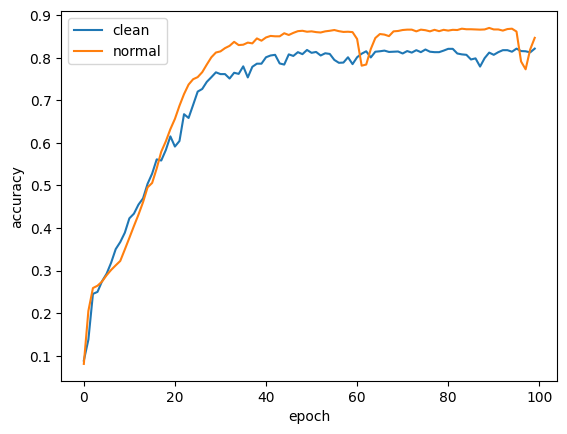

In [ ]:
# Evaluating the model on accuracy
import matplotlib.pyplot as plt
plt.plot(r.history['accuracy'])
plt.plot(a.history['accuracy'])
plt.legend(['clean', 'normal'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

TOKENIZER 200 EPOCH: 4

In [ ]:
df=pd.read_excel("/content/gdrive/My Drive/Deneme/sonuc.xlsx")

In [ ]:
del df["BleuScore"]

In [ ]:
df = df.dropna()

In [ ]:
df

Unnamed: 0                                    True Impression  \
0             0                  acute cardiopulmonary abnormality   
1             1  stable postoperative appearance right lower lo...   
2             2                        acute intrathoracic process   
3             3                      acute cardiopulmonary process   
4             4  pneumonia seen within limitations chest xray s...   
..          ...                                                ...   
195         195  extensive multiple bilateral opacities nonspec...   
196         196  nasogastric tube seen coursing diaphragm tip i...   
197         197  left lung base consolidation appears progresse...   
198         198  acute cardiopulmonary process visualized rib f...   
199         199  right internal jugular central venous catheter...   

                                  Predicted Impression  
0                    acute cardiopulmonary abnormality  
1    right lower lobe opacification right base prov...  
2                                 acute findings chest  
3                          acute intrathoracic process  
4                        acute cardiopulmonary process  
..                                                 ...  
195  1 left ij line slightly distal near cavoatrial...  
196  interval placement nasogastric tube tip projec...  
197  left lower lobe consolidation appears slightly...  
198                      acute cardiopulmonary process  
199  right internal jugular central venous catheter...  

[200 rows x 3 columns]

In [ ]:
del df["Unnamed: 0"]
df = df.dropna()
df

True Impression  \
0                    acute cardiopulmonary abnormality   
1    stable postoperative appearance right lower lo...   
2                          acute intrathoracic process   
3                        acute cardiopulmonary process   
4    pneumonia seen within limitations chest xray s...   
..                                                 ...   
195  extensive multiple bilateral opacities nonspec...   
196  nasogastric tube seen coursing diaphragm tip i...   
197  left lung base consolidation appears progresse...   
198  acute cardiopulmonary process visualized rib f...   
199  right internal jugular central venous catheter...   

                                  Predicted Impression  
0                    acute cardiopulmonary abnormality  
1    right lower lobe opacification right base prov...  
2                                 acute findings chest  
3                          acute intrathoracic process  
4                        acute cardiopulmonary process  
..                                                 ...  
195  1 left ij line slightly distal near cavoatrial...  
196  interval placement nasogastric tube tip projec...  
197  left lower lobe consolidation appears slightly...  
198                      acute cardiopulmonary process  
199  right internal jugular central venous catheter...  

[200 rows x 2 columns]

In [ ]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu


# BLEU skorlarını hesaplama
bleu_scores = []
for index, row in df.iterrows():
    predicted_impression = row["Predicted Impression"]
    true_impression = row["True Impression"]
    bleu_score = sentence_bleu([true_impression], predicted_impression, weights=(0.5, 0.5))
    bleu_scores.append(bleu_score)

# BLEU skorlarının ortalamasını hesaplama
average_bleu_score = sum(bleu_scores) / len(bleu_scores)

# Sonucu yazdırma
print("Ortalama BLEU Skoru:", average_bleu_score)

Ortalama BLEU Skoru: 0.5094172414923426
